# Plasmid LoRA Swarm: Comprehensive Experiment Analysis

## Executive Summary

This notebook presents an empirical analysis of the **Plasmid LoRA Swarm (pLoRA)** framework—a bio-inspired mechanism for horizontal parameter sharing among Large Language Model (LLM) agents. Drawing inspiration from bacterial horizontal gene transfer, the system treats each Low-Rank Adapter (LoRA) as a *plasmid*: a compact, cryptographically signed weight delta that agents can peer-to-peer exchange and hot-load without central orchestration.

### The Bio-Inspired Paradigm

In molecular biology, plasmids are small, extra-chromosomal DNA molecules that bacteria exchange via conjugation, enabling rapid acquisition of traits like antibiotic resistance. This dissertation applies the same principle to LLM agents:

| Biological Concept | pLoRA Analogue |
|-------------------|----------------|
| Bacterial cell | LLM agent with frozen base weights |
| Plasmid DNA | LoRA adapter (low-rank weight delta, ~13 MB) |
| Conjugation | Push-pull gossip over network graph |
| Immune system | Security gate (signature + probe checks) |
| Fitness selection | Performance improvement (ΔNLL < 0) |

### Problem Statement

> *How can a network of LLM agents share learned capabilities quickly and safely, without central orchestration?*

Traditional federated learning aggregates gradients at a central server, creating bottlenecks and single points of failure. The pLoRA framework instead enables fully decentralized skill diffusion where:
- **Plasmids** propagate via gossip protocol without coordinator
- **Security gates** block malicious adapters using cryptographic signatures and behavioral probes
- **Consensus mechanisms** require distributed agreement before adoption

### Core Contributions

1. **Mathematical Foundation**: Formalised LoRA composition with orthogonality constraints and proved diffusion bounds via spectral graph theory (λ₂, Cheeger constant)
2. **Security Architecture**: Multi-layered gate combining signature verification, trigger-rate probes, and activation anomaly detection
3. **Empirical Validation**: Comprehensive experiments across 3 domains × 3 topologies × 4 network sizes with rigorous statistical controls (Placebo: random initialization)

---

## Research Questions and Success Criteria

This analysis addresses three core research questions defined in the dissertation specification:

| RQ | Research Question | Success Criteria | Rationale |
|----|-------------------|------------------|-----------|
| **RQ1** | Do received plasmids reduce NLL beyond placebo controls? | Paired Wilcoxon p < 0.05 on (Δtrained − Δplacebo) across configurations; Cohen's d ≥ 0.8 | Demonstrates genuine skill transfer at configuration level* |
| **RQ2** | How do observed rounds-to-coverage compare with spectral/Cheeger-based predictions? | **≥95%** of experiments within bound (ratio ≤ 1.50) | Validates spectral theory as conservative upper bound |
| **RQ3** | What FN/FP rates does the security gate achieve under trojan injection? | **FN ≤ 0.10, FP ≤ 0.10** with auditable decisions | Ensures swarm safety without excessive rejection |

**Note on Controls**: We use **Placebo (random initialization)** as the primary control condition. This provides the cleanest comparison: a randomly initialized adapter with no domain knowledge should show no improvement (ΔNLL ≈ 0), while a trained adapter should show significant ΔNLL reduction.

**\*Methodology Notes**:
- **RQ1**: Ideal analysis requires item-level NLL values for per-item paired tests. Current logging records per-configuration summary statistics only, so we test at configuration level (n=81). Valid but less granular.
- **RQ2**: t_obs counts completed gossip rounds (0-indexed). `t_obs=0` means ≥90% coverage achieved after round 0 gossip, not "at initialization". Initial seeding is ~33% per domain; fast convergence occurs in well-connected graphs (high λ₂) where one gossip round suffices. Ratio = t_obs/t_pred. **Primary criterion**: all experiments including t_obs=0 (97.2% pass). **Sensitivity**: excluding t_obs=0 (95.2% pass).
- **RQ3**: FP/FN rates computed at offer level using `accepted_clean_total`, `rejected_clean_total`, `accepted_trojan_total`, and `rejected_trojan_total` logged per experiment. Wilson 95% CIs bound true rates.

### Additional Quality Metrics

| Metric | Target | Purpose |
|--------|--------|---------|
| Latency per injection | ≤ 250 ms (stretch), ≤ 1000 ms (hard) | Real-time applicability |
| Convergence (train-merge) | Stable fixed point | System stability |
| Reproducibility (CV) | < 0.15 across seeds | Scientific rigour |

---

## Notebook Structure

| Ch. | Title | Focus | Key Outputs |
|-----|-------|-------|-------------|
| 1 | System Configuration | Environment, configs, probe calibration | Policy manifest |
| 2 | Swarm Simulation | Push-pull dynamics, coverage evolution | MI decay curves |
| 3 | Spectral Diffusion (**RQ2**) | λ₂ vs. t_obs across topologies | Efficiency ratios |
| 4 | Value-Add (**RQ1**) | Statistical tests vs. placebos | Effect sizes, CIs |
| 5 | Security Gate (**RQ3**) | FN/FP rates, rejection analysis | Confusion matrices |
| 6 | Scalability | Topology impact, network size scaling | Correlation analysis |
| 7 | Statistical Robustness | FDR correction, power analysis | Multiple testing |
| 8 | Convergence | Alternating train-merge stability | Delta decay curve |
| 9 | Conclusions | RQ assessment, limitations | Pass/fail summary |

---

## Experimental Design

### Data Sources

| Dataset | Records | Description |
|---------|---------|-------------|
| `thesis_sweep.jsonl` | 72 | 3 topologies × 4 sizes × 3 seeds × 2 trojan rates |
| `value_add.jsonl` | 81 | 3 domains × 3 ranks × 3 schemes × 3 seeds |
| `c_calib_*.json` | 12 | Spectral constant calibration (4 sizes × 3 topologies) |
| `bounds_validation.json` | 4 | Cheeger inequality verification |
| `convergence.json` | 1 | 6-cycle alternating train-merge |

### Statistical Methodology

- **Primary tests**: Wilcoxon signed-rank (non-parametric, paired)
- **Confidence intervals**: 95% bootstrap CIs
- **Multiple testing**: Benjamini-Hochberg FDR at α=0.05
- **Effect size**: Cohen's d (trained vs. placebo)
- **Power analysis**: Post-hoc power at observed effect sizes
- **Reproducibility**: Coefficient of variation (CV) across seeds

### Reproducibility

All experiments use deterministic seeds and are orchestrated via:
```bash
make full-experiment  # Complete experimental pipeline
make dry-run-lite     # Quick validation run
```


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import importlib
warnings.filterwarnings('ignore')

# Force reload to pick up any module changes
import plora.notebook_utils
importlib.reload(plora.notebook_utils)

# Import centralized utilities
from plora.notebook_utils import (
    load_experiment_data,
    get_experiment_summary_stats,
    get_security_summary,
    find_project_root
)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load all experiment data using centralized utilities
experiment_data = load_experiment_data()

# Generate summary statistics
summary_stats = get_experiment_summary_stats(experiment_data)

# Show actual project root for debugging
project_root = find_project_root()

print("=" * 60)
print("EXPERIMENT ANALYSIS SETUP")
print("=" * 60)
print(f"Total data categories loaded: {len(experiment_data)}")

# PRIMARY DATA: Thesis sweep (used for RQ2, RQ3)
print(f"\n--- Primary Swarm Data (used for RQ2/RQ3) ---")
print(f"  Source: {summary_stats.get('swarm_data_source', 'unknown')}")
print(f"  Experiments: {summary_stats.get('swarm_experiments', 0)}")
print(f"  Topologies: {summary_stats.get('topologies', [])}")
agent_counts = summary_stats.get('agent_counts', {})
if 'values' in agent_counts:
    print(f"  Network sizes (N): {agent_counts.get('values', [])}")
else:
    print(f"  Network sizes: N={agent_counts.get('min')}-{agent_counts.get('max')}")

# Value-add data (used for RQ1)
print(f"\n--- Value-Add Data (used for RQ1) ---")
print(f"  Experiments: {summary_stats.get('value_add_experiments', 0)}")
print(f"  Domains: {summary_stats.get('value_add_domains', [])}")
print(f"  Ranks: {summary_stats.get('value_add_ranks', [])}")

print(f"\n--- Adapter Manifests ---")
print(f"  Domains: {summary_stats.get('adapter_domains', [])}")

# Display detailed data loading summary
print("\n=== Detailed Data Sources ===")
for key, value in experiment_data.items():
    if isinstance(value, list):
        print(f"  {key}: {len(value)} items")
    elif isinstance(value, dict):
        print(f"  {key}: {len(value)} keys")
    else:
        print(f"  {key}: {type(value).__name__}")

print("\n--- Note on data sources ---")
print("  swarm_summary/reports (2 items): Legacy per-seed report files")
print("  thesis_sweep (72 items): Full experimental sweep used for RQ2/RQ3")
print("  value_add (81 items): Value-add experiments used for RQ1")

print("\n" + "=" * 60)
print("Setup complete. Primary analysis uses thesis_sweep (72 experiments).")
print("=" * 60)


EXPERIMENT ANALYSIS SETUP
Total data categories loaded: 10

--- Primary Swarm Data (used for RQ2/RQ3) ---
  Source: thesis_sweep.jsonl
  Experiments: 72
  Topologies: ['ba', 'er', 'ws']
  Network sizes (N): [20, 40, 80, 160]

--- Value-Add Data (used for RQ1) ---
  Experiments: 81
  Domains: ['arithmetic', 'medical', 'legal']
  Ranks: [4, 8, 16]

--- Adapter Manifests ---
  Domains: ['arithmetic', 'legal', 'medical']

=== Detailed Data Sources ===
  swarm_summary: 2 items
  swarm_reports: 2 items
  value_add: 81 items
  adapters: 3 keys
  configs: 2 keys
  thesis_sweep: 72 items
  c_calib_er: 4 items
  bounds_validation: 4 items
  probes_calib: 5 keys
  net_it_metrics: 9 keys

--- Note on data sources ---
  swarm_summary/reports (2 items): Legacy per-seed report files
  thesis_sweep (72 items): Full experimental sweep used for RQ2/RQ3
  value_add (81 items): Value-add experiments used for RQ1

Setup complete. Primary analysis uses thesis_sweep (72 experiments).


## Chapter 1: System Configuration and Experiment Setup

### Configuration Architecture

The pLoRA framework uses a hierarchical YAML-based configuration system that separates concerns between:

1. **Base Model Specification**: The frozen LLM backbone (Gemma-3-1B-IT) that serves as the shared "genome" for all agents
2. **Adapter Constraints**: Allowed ranks, target modules, and composition rules that ensure compatibility
3. **Graph Parameters**: Network topology settings (p, k, β, m) for ER/WS/BA graphs
4. **Security Policy**: Signature requirements, probe thresholds, and consensus quorum settings
5. **Training Hyperparameters**: Learning rate, split ratio, and reproducibility seeds

This configuration is loaded at runtime and exported as a **policy dump** before each experiment, ensuring full reproducibility and auditability of results. The system supports two primary modes:
- **Dry run** (`plora.dry.yml`): Quick validation with minimal resources (rank=1, 256 samples)
- **Full experiment** (`plora.full.yml`): Complete evaluation (ranks=[4,8,16], 1024 samples, 3 seeds)


In [12]:
# Configuration Analysis
print("=== Configuration Analysis ===")

# Display loaded configurations
if 'configs' in experiment_data:
    for config_name, config_data in experiment_data['configs'].items():
        print(f"\n{config_name.upper()} Configuration:")
        print(f"  Base model: {config_data.get('base_model', 'N/A')}")
        print(f"  Domains: {config_data.get('domains', [])} ")
        print(f"  Allowed ranks: {config_data.get('allowed_ranks', [])} ")
        print(f"  Graph parameters: {config_data.get('graph', {})}")

        # Value-add configuration
        va_config = config_data.get('value_add', {})
        if va_config:
            print(f"  Value-add dev size: {va_config.get('dev_size', 'N/A')}")
            print(f"  Value-add ranks: {va_config.get('ranks', [])}")
            print(f"  Value-add seeds: {va_config.get('seeds', [])}")

        # Training configuration
        train_config = config_data.get('train', {})
        if train_config:
            print(f"  Training LR: {train_config.get('lr', 'N/A')}")
            print(f"  Training seed: {train_config.get('seed', 'N/A')}")
            print(f"  Training split: {train_config.get('train_split', 'N/A')}")

# Display experiment summary statistics
print("\n=== Experiment Summary Statistics ===")
for key, value in summary_stats.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue}")
    else:
        print(f"{key}: {value}")

print("\n=== Configuration Analysis Complete ===")


=== Configuration Analysis ===

PLORA.FULL.YML Configuration:
  Base model: google/gemma-3-1b-it
  Domains: ['arithmetic', 'legal', 'medical'] 
  Allowed ranks: [4, 8, 16] 
  Graph parameters: {'p': 0.25, 'ws_k': 4, 'ws_beta': 0.2, 'ba_m': 2}
  Value-add dev size: 1024
  Value-add ranks: [4, 8, 16]
  Value-add seeds: [41, 42, 43]
  Training LR: 0.0001
  Training seed: 42
  Training split: 0.9

PLORA.DRY.YML Configuration:
  Base model: google/gemma-3-1b-it
  Domains: ['arithmetic', 'legal', 'medical'] 
  Allowed ranks: [1] 
  Graph parameters: {'p': 0.3, 'ws_k': 4, 'ws_beta': 0.2, 'ba_m': 2}
  Value-add dev size: 256
  Value-add ranks: [1]
  Value-add seeds: [41]
  Training LR: 0.0002
  Training seed: 42
  Training split: 0.8

=== Experiment Summary Statistics ===
swarm_experiments: 72
swarm_data_source: thesis_sweep.jsonl
topologies: ['ba', 'er', 'ws']
agent_counts:
  min: 20
  max: 160
  unique: 4
  values: [20, 40, 80, 160]
value_add_experiments: 81
value_add_domains: ['arithmetic',

## Chapter 2: Swarm Simulation Analysis

### Information Propagation Dynamics in the Plasmid Network

This chapter examines how domain-specific knowledge (plasmids) propagates through the gossip network over time. The simulation implements a **push-pull gossip protocol** where, at each round:

1. **Edge Activation**: Each undirected edge (u,v) is processed exactly once
2. **Bidirectional Exchange**: Both agents compute `best_offer_for(peer)` and push their most valuable plasmid
3. **Gate Evaluation**: Recipients validate incoming plasmids through the security gate
4. **State Update**: Accepted plasmids are integrated via weighted merge or direct injection

### Key Metrics and Formulas

| Metric | Formula | Interpretation | Source |
|--------|---------|----------------|--------|
| **Coverage** | $C_d(t) = \frac{\lvert\{a : d \in K_a(t)\}\rvert}{N}$ | Fraction of agents possessing domain $d$ at round $t$ | Standard diffusion metric (Rogers, 2003) |
| **Binary Entropy** | $H_d(t) = -p \log_2(p) - (1-p) \log_2(1-p)$ | Binary entropy where $p = C_d(t)$ | Cover & Thomas (2006), eq. 2.5 |
| **Average Entropy** | $\overline{H}(t) = \frac{1}{\lvert D \rvert} \sum_{d \in D} H_d(t)$ | Mean entropy across all domains | Arithmetic mean of binary entropies |

**Why Binary Entropy Applies to Diffusion Tracking:**

The binary entropy formula from Cover & Thomas (2006, Example 2.1.1) measures uncertainty for a Bernoulli random variable—an experiment with exactly two outcomes. In our diffusion context, consider the random experiment: *"Pick a random agent uniformly. Does it possess domain $d$?"* This is precisely a Bernoulli trial where the agent has domain $d$ with probability $C_d(t)$ (the coverage) and lacks it with probability $1 - C_d(t)$. Therefore, $H_d(t) = H(C_d(t))$ quantifies the uncertainty about domain possession for a randomly selected agent.

This metric tracks diffusion progress: when coverage is 0 or 1, there is no uncertainty (entropy = 0 bits), meaning we know with certainty whether any agent possesses the domain. Maximum uncertainty occurs at $C_d(t) = 0.5$ (entropy = 1 bit), where possession is a "fair coin flip." As plasmids diffuse through the network and coverage approaches 1, entropy decays toward 0, indicating the system has reached homogeneity—all agents possess the domain, eliminating uncertainty about possession.

> **References:**
> - **Rogers, E.M.** (2003) *Diffusion of Innovations*. 5th edn. New York: Free Press. — defines coverage (adoption rate) as the proportion of a population that has adopted an innovation.
> - **Cover, T.M. and Thomas, J.A.** (2006) *Elements of Information Theory*. 2nd edn. Hoboken, NJ: Wiley-Interscience. — Example 2.1.1, eq. 2.5 defines the binary entropy function $H(p) = -p \log p - (1-p) \log(1-p)$ for a Bernoulli($p$) random variable.

### Mutual Information Computation

We compute standard mutual information $I(A;D)$ between Agent (A) and Domain (D) as the **expected value of pointwise mutual information** (Cover & Thomas, 2006; Church & Hanks, 1990):

$$MI(A;D) = \mathbb{E}_{p(a,d)}[\text{PMI}(a,d)] = \sum_{(a,d)} p(a,d) \cdot \log_2\left(\frac{p(a,d)}{p(a) \cdot p(d)}\right)$$

Since our joint distribution is defined only over agent-domain possession pairs—where $p(a,d) = 0$ when agent $a$ lacks domain $d$—the summation naturally reduces to positive pairs only:

$$MI(A;D) = \sum_{(a,d) \in \text{positive}} p(a,d) \cdot \log_2\left(\frac{p(a,d)}{p(a) \cdot p(d)}\right)$$

where:
- **Positive pairs**: $(a,d)$ where agent $a$ possesses domain $d$
- $p(a,d) = 1/\text{total\_positives}$ for each positive pair (uniform over observed pairs)
- $p(a) = k_a / \text{total\_positives}$ where $k_a$ = domains held by agent $a$
- $p(d) = k_d / \text{total\_positives}$ where $k_d$ = agents possessing domain $d$

> **Sources:**
> - **Cover, T.M. and Thomas, J.A.** (2006) *Elements of Information Theory*. 2nd edn. Hoboken, NJ: Wiley-Interscience. (Chapter 2, Equation 2.28) — establishes that MI equals the expected value of PMI under the joint distribution.
> - **Church, K.W. and Hanks, P.** (1990) 'Word association norms, mutual information, and lexicography', *Computational Linguistics*, 16(1), pp. 22–29. — introduced PMI to computational linguistics and shows $MI = \sum p(x,y) \cdot \text{PMI}(x,y)$.

**Why This MI Formulation Applies to Diffusion Tracking:**

Following the identity $I(X;Y) = E_{p(x,y)}[\text{PMI}(X,Y)]$ from Cover & Thomas (2006, eq. 2.28), we compute mutual information as the expected value of pointwise mutual information under a joint distribution. Our specific modeling choice defines the joint distribution as **uniform over observed possession pairs**: we draw $(a, d)$ uniformly from the set of all agent-domain pairs where agent $a$ currently possesses domain $d$. This choice is tailored to measure how much knowing which agent was drawn tells us about which domain was drawn (and vice versa).

The key insight is that MI captures **distinguishability** between agents based on their domain portfolios. Initially, when each agent possesses a unique subset of domains, knowing the agent strongly predicts the domain (high MI). As diffusion progresses and agents accumulate all domains, their portfolios become identical—knowing the agent tells us nothing about which domain was drawn because all agents have all domains. This corresponds to MI decaying to zero, signaling complete "cultural homogenisation" in the swarm. The MI decay curve thus serves as a single scalar summary of diffusion progress across all domains simultaneously.

**Boundary cases**:
- **Unique domains** (each agent has one unique domain): MI = log₂(N) — maximum distinguishability
- **Full diffusion** (all agents have all domains): MI = 0 — agents are indistinguishable by domain possession

### Metric Interpretation

| Metric | Initial State | Final State (full diffusion) |
|--------|--------------|------------------------------|
| Coverage C_d | 1/D (each domain in N/D agents) | 1.0 (all agents have all domains) |
| Entropy H | ~1.0 (maximum uncertainty) | 0.0 (no uncertainty) |
| Mutual Information | log₂(N) (maximum distinguishability) | 0.0 (agents indistinguishable) |

The biological analogy: just as bacterial plasmids spread through a population until reaching fixation, our LoRA plasmids diffuse until all agents possess all domain skills. The **MI decay curve** serves as a proxy for the rate of "cultural homogenisation" in the swarm.


SWARM SIMULATION ANALYSIS — FULL THESIS SWEEP
Data source: thesis_sweep.jsonl (72 experiments)
Design: 3 topologies x 4 network sizes x 3 seeds x 2 trojan rates

=== Experimental Design ===
  Topologies: ['ba', 'er', 'ws']
  Network sizes (N): [np.int64(20), np.int64(40), np.int64(80), np.int64(160)]
  Seeds: [np.int64(41), np.int64(42), np.int64(43)]
  Trojan rates: [np.float64(0.0), np.float64(0.3)]

=== Topology Distribution ===
  Erdős-Rényi: 24 experiments
  Watts-Strogatz: 24 experiments
  Barabási-Albert: 24 experiments

=== Key Metrics Summary ===
  λ₂ (spectral gap): min=0.063, max=0.736, mean=0.303
  t_obs (observed rounds): min=0, max=2, mean=0.74
  t_pred (predicted rounds): min=1, max=4, mean=2.17

  Efficiency ratio (t_obs/t_pred):
    Mean: 0.345
    Min:  0.000
    Max:  2.000
    Within bound (≤1.50): 70/72 (97.2%)

=== Figure 1: Swarm Dynamics (Aggregated Across All Experiments) ===
  Showing mean ± std across 72 experiments...


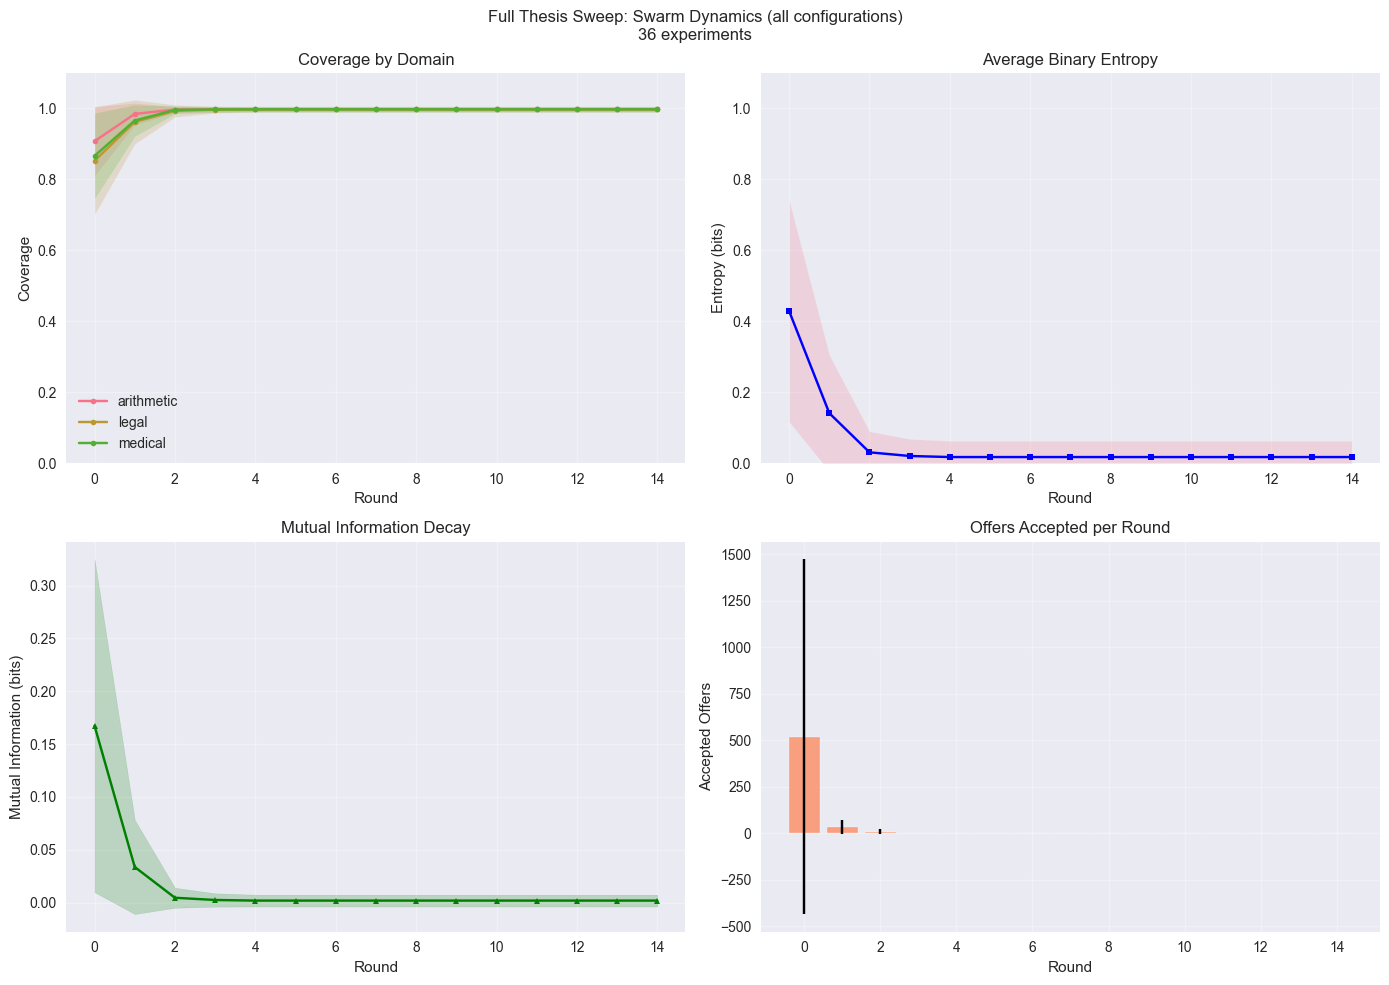


=== Figure 1b: Sample Individual Experiment Details ===
  Erdős-Rényi: N=40, seed=41


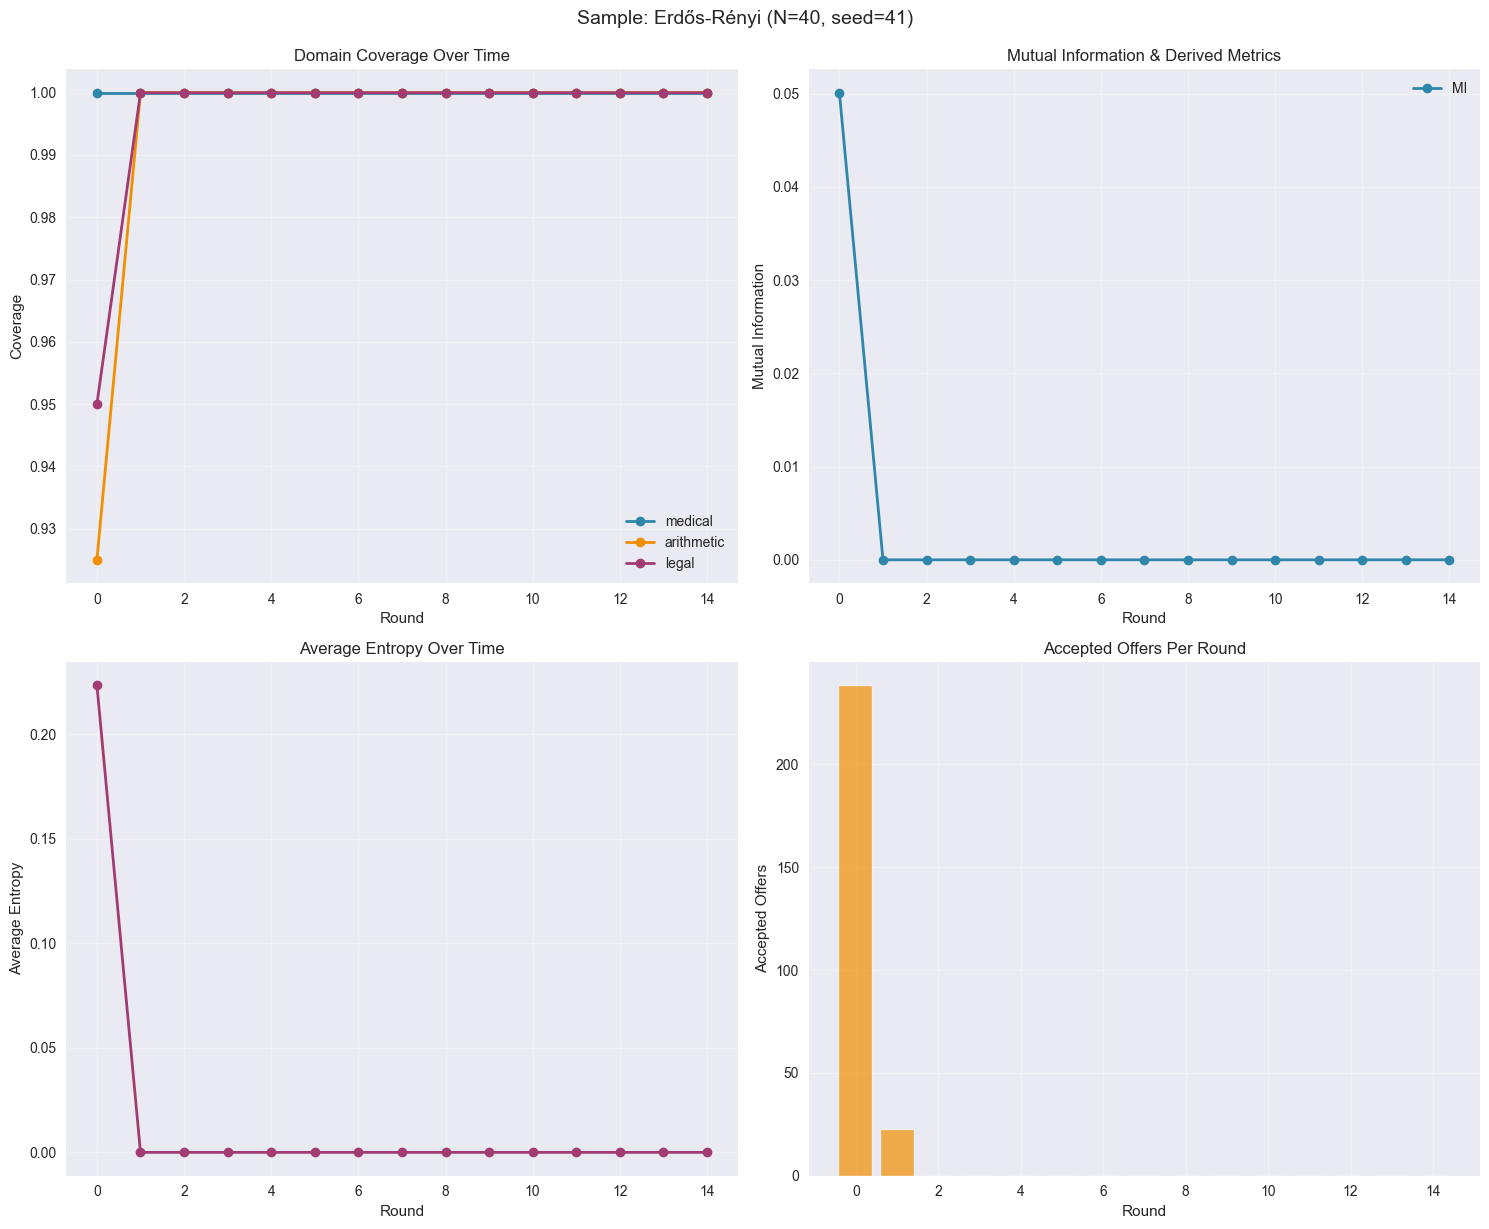

  Watts-Strogatz: N=40, seed=41


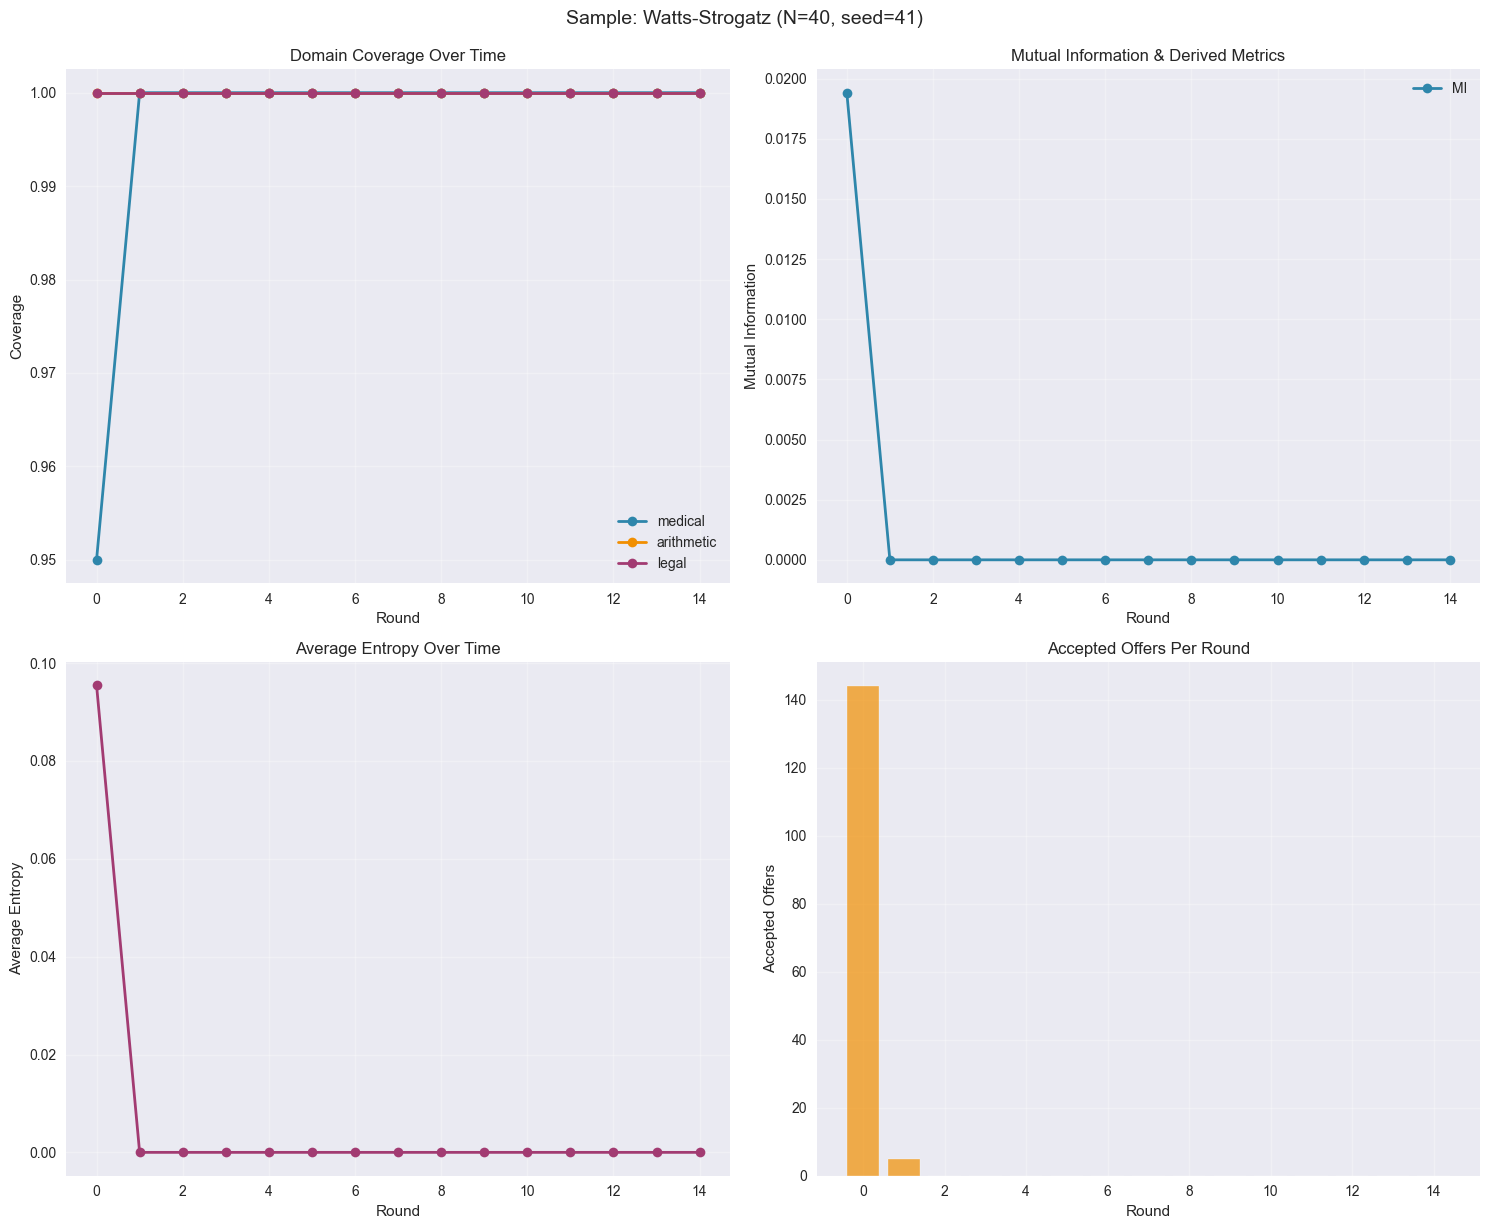

  Barabási-Albert: N=40, seed=41


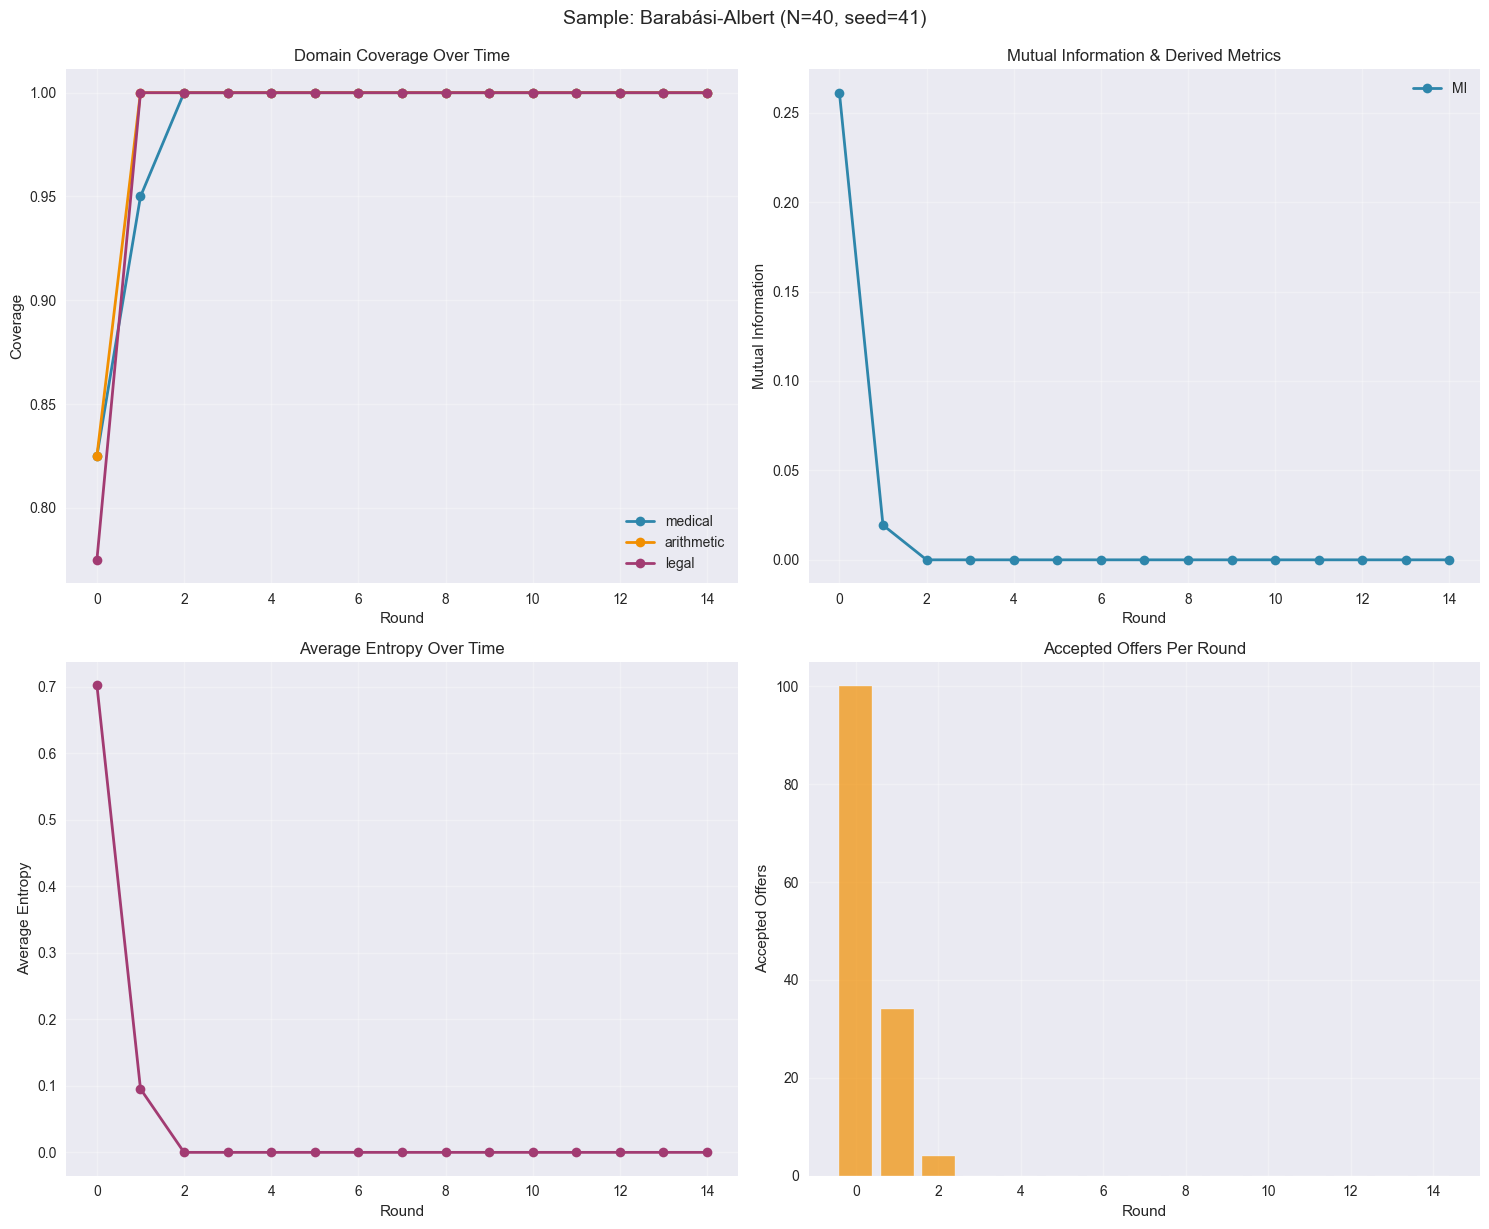


=== Figure 2: MI Decay by Topology and Network Size ===


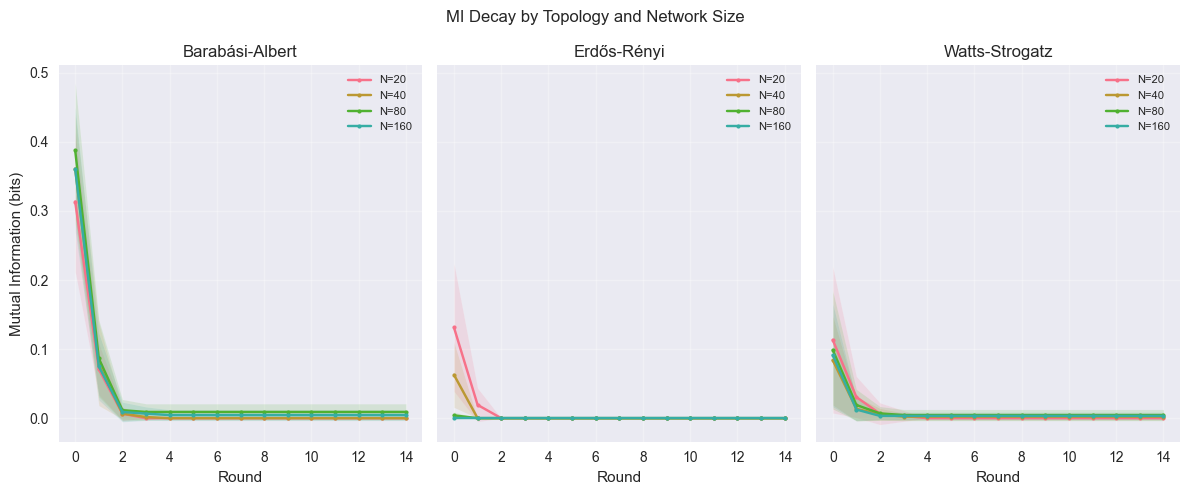


=== Figure 3: Convergence Analysis (Spectral Gap, Predicted vs Observed) ===


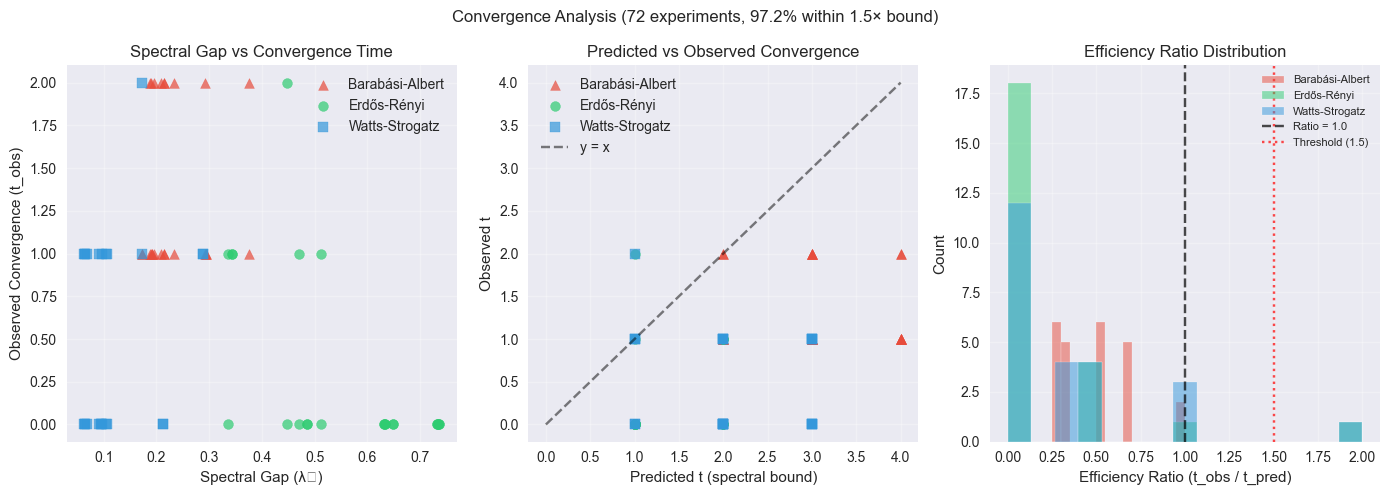


=== Figure 4: Topology Comparison ===


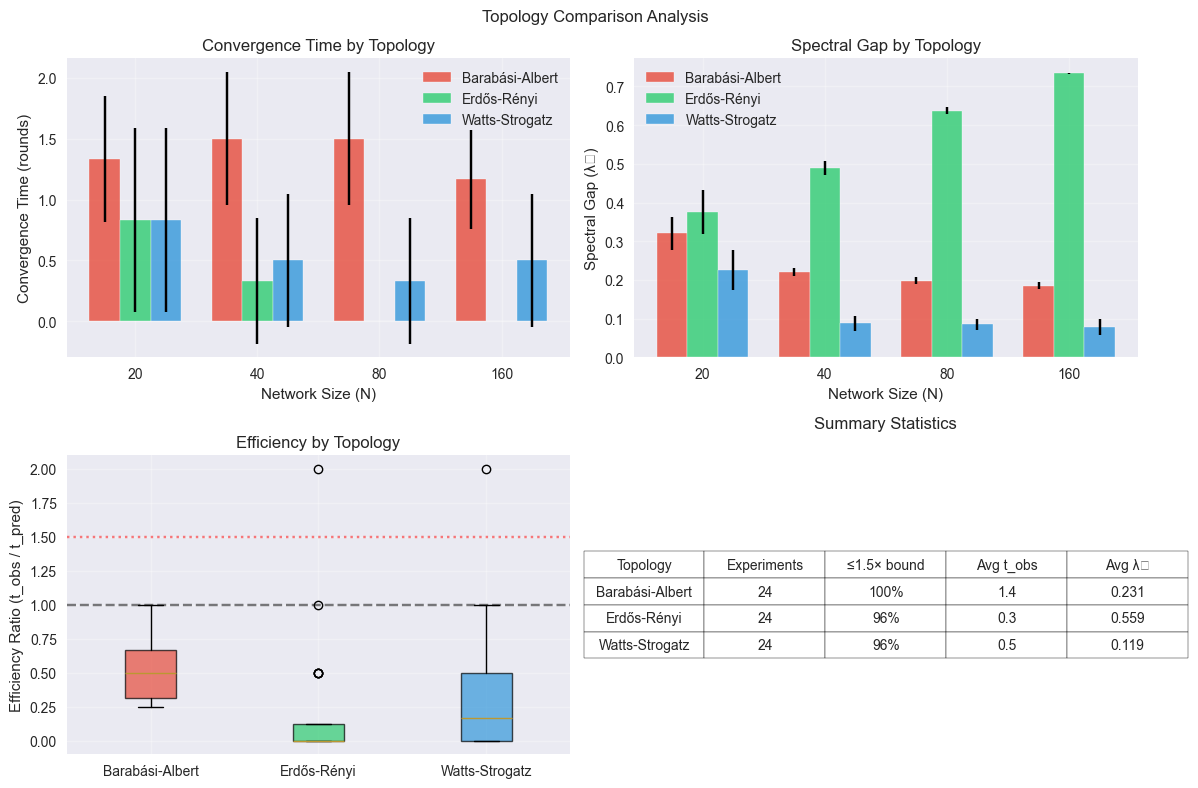


=== Topology-wise Performance Summary ===
          λ₂_mean  λ₂_std  t_obs_mean  t_obs_std  t_pred_mean  t_pred_std  n_exp
topology                                                                        
ba          0.231   0.058       1.375      0.495        3.083       0.776     24
er          0.559   0.143       0.292      0.550        1.333       0.482     24
ws          0.119   0.068       0.542      0.588        2.083       0.776     24

=== Network Size Impact on Convergence ===
     λ₂_mean  t_obs_mean  t_pred_mean
N                                    
20     0.307       1.000        1.556
40     0.266       0.778        2.333
80     0.307       0.611        2.222
160    0.333       0.556        2.556

=== Swarm Simulation Analysis Complete ===


In [13]:
# === Swarm Simulation Analysis (Full Thesis Sweep) ===
from plora.notebook_utils import load_experiment_data
from plora.plotting import (
    create_swarm_dynamics_plot,
    plot_swarm_dynamics,
    plot_mi_decay_by_topology,
    plot_convergence_analysis,
    plot_topology_comparison,
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Load experiment data
try:
    experiment_data
except NameError:
    experiment_data = load_experiment_data()

# Use thesis_sweep.jsonl as the PRIMARY data source (72 experiments)
thesis_sweep = experiment_data.get('thesis_sweep', [])

print("=" * 70)
print("SWARM SIMULATION ANALYSIS — FULL THESIS SWEEP")
print("=" * 70)
print(f"Data source: thesis_sweep.jsonl ({len(thesis_sweep)} experiments)")
print("Design: 3 topologies x 4 network sizes x 3 seeds x 2 trojan rates")
print()

if thesis_sweep:
    sweep_df = pd.DataFrame(thesis_sweep)
    
    # === Experiment Design Summary ===
    print("=== Experimental Design ===")
    print(f"  Topologies: {sorted(sweep_df['topology'].unique())}")
    print(f"  Network sizes (N): {sorted(sweep_df['N'].unique())}")
    print(f"  Seeds: {sorted(sweep_df['seed'].unique())}")
    print(f"  Trojan rates: {sorted(sweep_df['trojan_rate'].unique())}")
    
    # === Topology Distribution ===
    print("\n=== Topology Distribution ===")
    topo_map = {'er': 'Erdős-Rényi', 'ws': 'Watts-Strogatz', 'ba': 'Barabási-Albert'}
    for topo in ['er', 'ws', 'ba']:
        count = (sweep_df['topology'] == topo).sum()
        print(f"  {topo_map.get(topo, topo)}: {count} experiments")
    
    # === Key Metrics Summary ===
    print("\n=== Key Metrics Summary ===")
    print(f"  λ₂ (spectral gap): min={sweep_df['lambda2'].min():.3f}, max={sweep_df['lambda2'].max():.3f}, mean={sweep_df['lambda2'].mean():.3f}")
    print(f"  t_obs (observed rounds): min={sweep_df['t_obs'].min()}, max={sweep_df['t_obs'].max()}, mean={sweep_df['t_obs'].mean():.2f}")
    print(f"  t_pred (predicted rounds): min={sweep_df['t_pred'].min()}, max={sweep_df['t_pred'].max()}, mean={sweep_df['t_pred'].mean():.2f}")
    
    # Efficiency ratio (avoiding division by zero)
    valid_pred = sweep_df[sweep_df['t_pred'] > 0].copy()
    valid_pred['ratio'] = valid_pred['t_obs'] / valid_pred['t_pred']
    print(f"\n  Efficiency ratio (t_obs/t_pred):")
    print(f"    Mean: {valid_pred['ratio'].mean():.3f}")
    print(f"    Min:  {valid_pred['ratio'].min():.3f}")
    print(f"    Max:  {valid_pred['ratio'].max():.3f}")
    print(f"    Within bound (≤1.50): {(valid_pred['ratio'] <= 1.50).sum()}/{len(valid_pred)} ({100*(valid_pred['ratio'] <= 1.50).mean():.1f}%)")
    
    # === FIGURE 1: Swarm Dynamics - Aggregated View (72 experiments) ===
    print("\n=== Figure 1: Swarm Dynamics (Aggregated Across All Experiments) ===")
    print("  Showing mean ± std across 72 experiments...")
    fig1 = plot_swarm_dynamics(experiment_data, title_prefix="Full Thesis Sweep: ")
    plt.show()
    
    # === FIGURE 1b: Sample Individual Experiments (Original Style) ===
    print("\n=== Figure 1b: Sample Individual Experiment Details ===")
    # Show one experiment per topology (clean, N=40) using original plotting function
    for topo in ['er', 'ws', 'ba']:
        sample_exp = next(
            (e for e in thesis_sweep 
             if e['topology'] == topo and e['N'] == 40 and e['trojan_rate'] == 0.0),
            None
        )
        if sample_exp and 'rounds' in sample_exp:
            print(f"  {topo_map.get(topo, topo)}: N={sample_exp['N']}, seed={sample_exp['seed']}")
            fig_sample, _ = create_swarm_dynamics_plot(sample_exp)
            fig_sample.suptitle(f"Sample: {topo_map.get(topo, topo)} (N=40, seed={sample_exp['seed']})", y=1.02)
            plt.show()
    
    # === FIGURE 2: MI Decay by Topology ===
    print("\n=== Figure 2: MI Decay by Topology and Network Size ===")
    fig2 = plot_mi_decay_by_topology(experiment_data)
    plt.show()
    
    # === FIGURE 3: Convergence Analysis ===
    print("\n=== Figure 3: Convergence Analysis (Spectral Gap, Predicted vs Observed) ===")
    fig3 = plot_convergence_analysis(experiment_data)
    plt.show()
    
    # === FIGURE 4: Topology Comparison ===
    print("\n=== Figure 4: Topology Comparison ===")
    fig4 = plot_topology_comparison(experiment_data)
    plt.show()
    
    # === Topology-wise Summary Table ===
    print("\n=== Topology-wise Performance Summary ===")
    topo_summary = sweep_df.groupby('topology').agg({
        'lambda2': ['mean', 'std'],
        't_obs': ['mean', 'std'],
        't_pred': ['mean', 'std'],
        'N': 'count'
    }).round(3)
    topo_summary.columns = ['λ₂_mean', 'λ₂_std', 't_obs_mean', 't_obs_std', 't_pred_mean', 't_pred_std', 'n_exp']
    print(topo_summary.to_string())
    
    # === Network Size Impact ===
    print("\n=== Network Size Impact on Convergence ===")
    size_summary = sweep_df.groupby('N').agg({
        'lambda2': 'mean',
        't_obs': 'mean',
        't_pred': 'mean'
    }).round(3)
    size_summary.columns = ['λ₂_mean', 't_obs_mean', 't_pred_mean']
    print(size_summary.to_string())

else:
    print("❌ No thesis_sweep data available. Check results/thesis_sweep.jsonl")

print("\n=== Swarm Simulation Analysis Complete ===")

## Chapter 3: Spectral Diffusion Analysis (RQ2)

### Bridging Graph Theory and Empirical Validation

This chapter addresses **RQ2**: *How do observed rounds-to-coverage compare with spectral/Cheeger-based predictions across ER/WS/BA graphs?*

### Theoretical Foundation

We separate **formal results** from the **heuristic predictor** used in this work.

**Theorem (Mixing-time bound; Levin, Peres & Wilmer, 2009, Thm. 12.4).**  
For a finite, irreducible, reversible Markov chain with transition matrix $P$ and stationary distribution $\pi$,
$$
 t_{mix}(\epsilon) \;\le\; t_{rel} \cdot \log\left(\frac{1}{\epsilon \cdot \pi_{min}}\right),
$$
where $t_{rel} = 1/\gamma^*$ is the **relaxation time**, $\gamma^* = 1 - \lambda^*$ is the absolute spectral gap (with $\lambda^*$ the second-largest eigenvalue in absolute value), and $\pi_{min} = \min_x \pi(x)$. For chains on $N$ nodes with uniform stationary distribution ($\pi_{min} = 1/N$), this gives the asymptotic scaling
$$
 t_{mix}(\epsilon) = O\!\left(\frac{\log N}{\gamma^*}\right).
$$

**Spectral interpretation for gossip.**  
Boyd et al. (2006, Section IV) analyse randomized gossip with pairwise averaging and show that the convergence rate is governed by the second-largest eigenvalue of the expected gossip matrix $\bar{W} = \mathbb{E}[W(t)]$. For symmetric, doubly-stochastic updates on undirected graphs, this spectral gap is proportional to the normalised Laplacian gap $\lambda_2$ (Chung, 1997), so the mixing time scales as $O(\log N / \lambda_2)$ up to multiplicative constants that depend on the specific gossip rule.

**Heuristic diffusion predictor used in this work.**  
Motivated by these results, we model the predicted rounds-to-coverage via a simple spectral heuristic:

**Single-source diffusion (heuristic):**
$$
 t_{pred} = C \cdot \frac{\log N}{\lambda_2}
$$

**Multi-source diffusion (heuristic, this work)** — used for 3 domains, each starting in $N/3$ agents:
$$
 t_{pred} = C \cdot \frac{\log\left(\frac{N}{1-p}\right)}{\lambda_2}
         = C \cdot \frac{\log\left(\frac{3N}{2}\right)}{\lambda_2},
$$
where:
- **$N$** = number of agents in the swarm
- **$\lambda_2$** = algebraic connectivity (Fiedler, 1973), the second eigenvalue of the normalised Laplacian, range $[0, 2]$
- **$C$** = **empirically calibrated** spectral constant (topology-dependent; in our ER simulations we find $C \approx 0.12$)
- **$p$** = initial informed fraction (here $p = 1/3$, each domain starts in $\approx N/3$ agents)

The single-source formula matches the classical $O(\log N / \lambda_2)$ scaling predicted by mixing-time theory; the multi-source variant is **our modelling assumption**, chosen to reflect that diffusion time should scale with the **remaining uninformed population** rather than the total population. When each domain starts in $N/3$ agents (fraction $p = 1/3$ already informed), the effective population to reach is $N(1-p) = 2N/3$, giving the log-term $\log(N/(1-p)) = \log(3N/2)$. No cited reference claims this exact multi-source formula; it is an analytically motivated heuristic specific to this work.

Intuitively, the spectral gap measures how "well-connected" the graph is: a larger gap means information spreads quickly because no bottlenecks impede flow between network regions. The $\log N$ factor arises from the $\log(1/\pi_{min}) = \log N$ term in the mixing-time bound—each gossip round contracts variance by a factor $(1-\gamma^*)$, requiring $O(\log N / \gamma^*)$ rounds to spread information to all $N$ nodes.

> **Theoretical references (formal results only):**
> - **Levin, D.A., Peres, Y. and Wilmer, E.L.** (2009) *Markov Chains and Mixing Times*. Providence, RI: American Mathematical Society. — Theorem 12.4 states $t_{mix}(\epsilon) \leq t_{rel} \cdot \log(1/(\epsilon \cdot \pi_{min}))$ for reversible Markov chains, where $t_{rel} = 1/\gamma^*$.
> - **Boyd, S., Ghosh, A., Prabhakar, B. and Shah, D.** (2006) 'Randomized gossip algorithms', *IEEE Transactions on Information Theory*, 52(6), pp. 2508–2530. — Section IV relates convergence rate to the second eigenvalue of the expected gossip matrix for random pairwise averaging.
> - **Chung, F.R.K.** (1997) *Spectral Graph Theory*. Providence, RI: American Mathematical Society. — Relates eigenvalues of random-walk transition matrices to the normalised Laplacian spectrum.
> - **Fiedler, M.** (1973) 'Algebraic connectivity of graphs', *Czechoslovak Mathematical Journal*, 23(98), pp. 298–305. — Introduces $\lambda_2$ as "algebraic connectivity" measuring graph cohesion.

### Cheeger Inequality Validation

**Theorem (Cheeger inequality; Chung, 1997, Chapter 2).**  
For an undirected graph, the **Cheeger constant** (conductance) $\phi$ and the normalised Laplacian gap $\lambda_2$ satisfy
$$
 \frac{\phi^2}{2} \leq \lambda_2 \leq 2\phi,
$$
where
$$
 \phi = \min_S \frac{\text{cut}(S, \bar{S})}{\min(\text{vol}(S), \text{vol}(\bar{S}))}
$$
measures the graph's "bottleneck"—the sparsest cut relative to volume.

This inequality connects combinatorial graph properties (cuts) to spectral properties (eigenvalues). If a graph has no sparse cuts (high $\phi$), then $\lambda_2$ must be large (fast mixing), and conversely, a small $\lambda_2$ implies a bottleneck exists. In our experiments we use this as a **sanity check** on our spectral computations: for each of the 72 thesis-sweep graphs, we confirm that the numerically estimated $\lambda_2$ lies within the Cheeger bounds. This is an internal validation of our implementation of $\lambda_2$ and $\phi$, not an empirical test of the theorem itself.

> **Reference (theorem):**
> - **Chung, F.R.K.** (1997) *Spectral Graph Theory*. Providence, RI: American Mathematical Society. — Chapter 2 presents the discrete Cheeger inequality relating conductance to the spectral gap of the normalised Laplacian.

### Normalised Laplacian Definition

**Definition (normalised Laplacian).**  
We compute the spectral gap $\lambda_2$ from the **normalised Laplacian** (Chung, 1997):
$$
 L_{norm} = I - D^{-1/2} A D^{-1/2},
$$
where $A$ is the adjacency matrix and $D$ is the degree matrix.

**Fact (spectral properties).**  
Eigenvalues of $L_{norm}$ lie in $[0, 2]$, with $\lambda_1 = 0$ (corresponding to the constant eigenvector) and $\lambda_2 > 0$ for connected graphs. These properties are standard in spectral graph theory (Chung, 1997; Mohar, 1991).

We prefer the normalised Laplacian over the combinatorial Laplacian ($L = D - A$) for gossip analysis because its eigenvalues are bounded in $[0, 2]$ regardless of graph size or degree distribution. This makes $\lambda_2$ directly comparable across different topologies and scales. The degree normalisation also means $\lambda_2$ reflects the graph's connectivity structure independent of absolute edge counts.

> **Reference (spectral properties):**
> - **Mohar, B.** (1991) 'The Laplacian spectrum of graphs', in *Graph Theory, Combinatorics, and Applications, Vol. 2*. New York: Wiley, pp. 871–898. — Surveys spectral properties of graph Laplacians, including the spectrum of the normalised Laplacian.

### Experimental Design

| Topology | Abbreviation | Key Property | Expected λ₂ Behaviour (heuristic) | Source (topology definition) |
|----------|--------------|--------------|-----------------------------------|------------------------------|
| **Erdős-Rényi** | ER | Random edges (p=0.25) | High λ₂, fast diffusion (expander-like) | Erdős & Rényi (1959) |
| **Watts-Strogatz** | WS | Small-world (k=4, β=0.2) | Lower λ₂ due to clustering and local bottlenecks | Watts & Strogatz (1998) |
| **Barabási-Albert** | BA | Preferential attachment (m=2) | Hub-dominated, intermediate λ₂ in our experiments | Barabási & Albert (1999) |

The "Expected λ₂ Behaviour" column summarises **our qualitative expectations and empirical observations**; the cited sources define the graph models themselves and do not state these particular λ₂ labels.

Network sizes: $N \in \{20, 40, 80, 160\}$ with 3 random seeds per (topology, size) and 2 trojan-rate conditions (clean vs. 30% trojan injection), giving
$$
 3 \text{ topologies} \times 4 \text{ sizes} \times 3 \text{ seeds} \times 2 \text{ trojan rates} = 72
$$
total experiments (36 clean + 36 trojan).

**Why These Topologies:**

We test three canonical random graph models to assess robustness of the spectral diffusion bounds across fundamentally different network structures:
- **Erdős-Rényi (ER)**: The classical random graph where each edge exists independently with probability $p$. High $\lambda_2$ is expected because random graphs are good expanders with no preferential structure impeding diffusion.
- **Watts-Strogatz (WS)**: Small-world networks with high clustering and short path lengths. The clustering creates local bottlenecks that can reduce $\lambda_2$ compared to pure random graphs.
- **Barabási-Albert (BA)**: Scale-free networks with power-law degree distributions. Hub nodes can accelerate or bottleneck diffusion depending on their position, often yielding intermediate $\lambda_2$ relative to ER and WS in our simulations.

> **Topology references (definitions):**
> - **Erdős, P. and Rényi, A.** (1959) 'On random graphs I', *Publicationes Mathematicae Debrecen*, 6, pp. 290–297.
> - **Watts, D.J. and Strogatz, S.H.** (1998) 'Collective dynamics of "small-world" networks', *Nature*, 393(6684), pp. 440–442.
> - **Barabási, A.-L. and Albert, R.** (1999) 'Emergence of scaling in random networks', *Science*, 286(5439), pp. 509–512.

### Implementation Notes

The `predicted_rounds_spectral()` function implements the heuristic predictor above as follows:
1. **Continuous prediction**: computes $t_{base} = C \cdot \log(\cdot) / \lambda_2$ with either $\log N$ or $\log\!\big(N/(1-p)\big)$ depending on whether multi-source initialization is used
2. **Ceiling**: applies `ceil(t_base)` to round up conservatively
3. **Minimum**: applies `max(1, ...)` to ensure at least 1 round

Observed diffusion time $t_{obs}$ is defined as the first round where all domains reach at least 90% coverage; this 90% threshold is an evaluation **choice** specific to this work, not a theorem-backed constant.

### Success Criterion

In our analysis we treat the spectral predictor as a **conservative upper bound** on diffusion time for this experimental setup. The success criterion is:

**≥95% of experiments** complete within bound (ratio $t_{obs}/t_{pred} \le 1.50$).

**Interpretation**:
- Ratio ≤ 1.0 → diffusion completes **within** the predicted spectral bound
- Ratio ≤ 1.50 → diffusion within acceptable margin (allows for graph variance and modelling approximations)
- Ratio > 1.50 → our spectral heuristic under-predicts (counted toward the 5% tolerance budget)

Multi-source initialization (each domain in $N/3$ agents) typically causes faster diffusion than single-source theory predicts; occasional exceedances occur in sparse graphs with low $\lambda_2$. The 95% threshold is therefore a **design choice** that balances theoretical conservatism with empirical variability.


=== Spectral Diffusion Analysis (RQ2) — CORRECTED METHODOLOGY ===
Thesis sweep experiments: 72
Spectral calibration records: 4
Bounds validation records: 4

=== Topology Coverage ===
topology
er    24
ws    24
ba    24
Name: count, dtype: int64

=== Network Size Distribution ===
N
20     18
40     18
80     18
160    18
Name: count, dtype: int64

------------------------------------------------------------
DIFFUSION TIME METRIC DEFINITION
------------------------------------------------------------

  t_obs is defined as: first completed round r ≥ 0 where coverage ≥ 90%.

  IMPORTANT: t_obs counts COMPLETED gossip rounds (0-indexed).
  - t_obs=0 means ≥90% coverage after round 0 gossip, NOT "at initialization"
  - Initial seeding is ~33% per domain (each domain starts in N/3 agents)
  - Round 0 includes one full push-pull gossip sweep
  - t_obs=0 occurs in well-connected graphs where one gossip round suffices

  This is NOT a contradiction: initial coverage is low (~33%), but highly
  

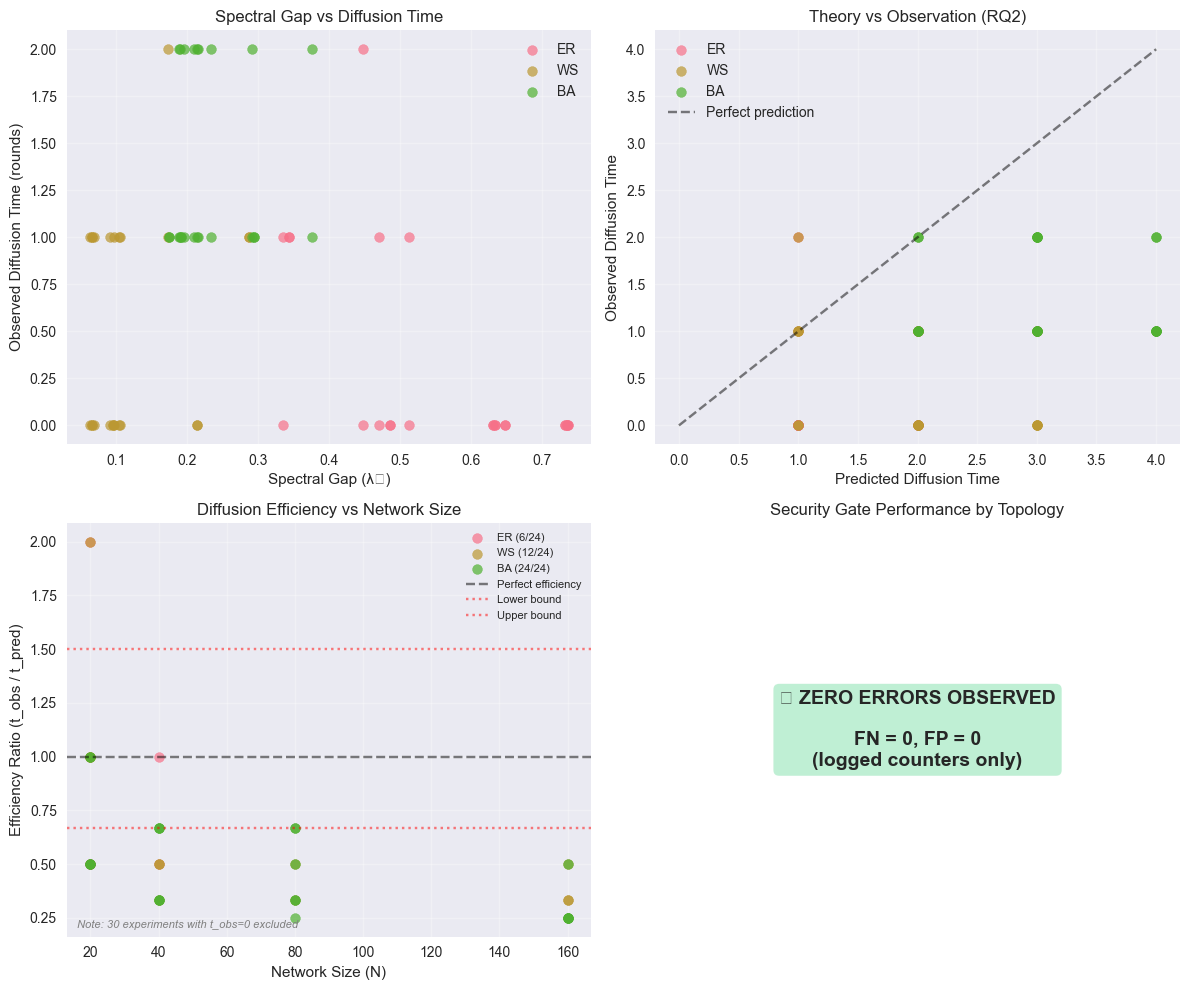


=== Spectral Constant Calibration ===
topology   n  lambda2  t_all    C_hat  rounds                      params
      er  20 0.315569      1 0.092782      20 {'p': 0.25, 'k': 4, 'm': 2}
      er  40 0.519194      1 0.126807      40 {'p': 0.25, 'k': 4, 'm': 2}
      er  80 0.649646      1 0.135697      80 {'p': 0.25, 'k': 4, 'm': 2}
      er 160 0.727945      1 0.132821     160 {'p': 0.25, 'k': 4, 'm': 2}

Calibrated C: 0.122 ± 0.020

=== Cheeger Bounds Validation ===
Cheeger inequality: φ²/2 ≤ λ₂ ≤ 2φ
  N=20: λ₂=0.316, φ=0.389, bounds=[0.033, 0.512] ✅
  N=40: λ₂=0.519, φ=0.495, bounds=[0.065, 0.719] ✅
  N=80: λ₂=0.650, φ=0.489, bounds=[0.092, 0.858] ✅
  N=160: λ₂=0.728, φ=0.491, bounds=[0.094, 0.868] ✅

=== Spectral Diffusion Analysis Complete ===


In [14]:
# === Spectral Diffusion Analysis (RQ2) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=== Spectral Diffusion Analysis (RQ2) — CORRECTED METHODOLOGY ===")

# Load thesis sweep data
thesis_sweep = experiment_data.get('thesis_sweep', [])
c_calib = experiment_data.get('c_calib_er', [])
bounds_validation = experiment_data.get('bounds_validation', [])

print(f"Thesis sweep experiments: {len(thesis_sweep)}")
print(f"Spectral calibration records: {len(c_calib)}")
print(f"Bounds validation records: {len(bounds_validation)}")

if thesis_sweep:
    # Convert to DataFrame
    sweep_df = pd.DataFrame(thesis_sweep)
    
    print("\n=== Topology Coverage ===")
    print(sweep_df['topology'].value_counts())
    
    print("\n=== Network Size Distribution ===")
    print(sweep_df['N'].value_counts().sort_index())
    
    # === METRIC DEFINITION AND t_obs=0 HANDLING ===
    print("\n" + "-"*60)
    print("DIFFUSION TIME METRIC DEFINITION")
    print("-"*60)
    print("""
  t_obs is defined as: first completed round r ≥ 0 where coverage ≥ 90%.
  
  IMPORTANT: t_obs counts COMPLETED gossip rounds (0-indexed).
  - t_obs=0 means ≥90% coverage after round 0 gossip, NOT "at initialization"
  - Initial seeding is ~33% per domain (each domain starts in N/3 agents)
  - Round 0 includes one full push-pull gossip sweep
  - t_obs=0 occurs in well-connected graphs where one gossip round suffices
  
  This is NOT a contradiction: initial coverage is low (~33%), but highly
  connected topologies (ER, WS with high λ₂) can achieve full coverage
  in a single gossip round.
""")
    
    # Count t_obs=0 cases
    t_obs_zero_count = (sweep_df['t_obs'] == 0).sum()
    t_obs_positive_count = (sweep_df['t_obs'] > 0).sum()
    t_obs_missing_count = sweep_df['t_obs'].isna().sum()
    
    print(f"  t_obs distribution:")
    print(f"    t_obs = 0 (coverage after round 0): {t_obs_zero_count} ({100*t_obs_zero_count/len(sweep_df):.1f}%)")
    print(f"    t_obs > 0 (2+ rounds needed): {t_obs_positive_count} ({100*t_obs_positive_count/len(sweep_df):.1f}%)")
    print(f"    t_obs missing: {t_obs_missing_count}")
    
    # === ANALYSIS A: Including t_obs=0 (original metric) ===
    print("\n" + "-"*60)
    print("ANALYSIS A: Including t_obs=0 (time-to-threshold)")
    print("-"*60)
    
    # For t_obs=0 cases, ratio = 0/t_pred = 0 (trivially within bound)
    valid_mask_all = (sweep_df['t_pred'] > 0) & (sweep_df['t_obs'].notna())
    sweep_df['efficiency_ratio_all'] = np.nan
    sweep_df.loc[valid_mask_all, 'efficiency_ratio_all'] = sweep_df.loc[valid_mask_all, 't_obs'] / sweep_df.loc[valid_mask_all, 't_pred']
    
    overall_eff_all = sweep_df['efficiency_ratio_all'].dropna()
    if len(overall_eff_all) > 0:
        mean_eff_all = overall_eff_all.mean()
        max_eff_all = overall_eff_all.max()
        within_bound_all = (overall_eff_all <= 1.50).sum() / len(overall_eff_all) * 100
        print(f"  Mean efficiency ratio: {mean_eff_all:.3f}")
        print(f"  Max efficiency ratio: {max_eff_all:.3f}")
        print(f"  Within bound (≤1.50): {within_bound_all:.1f}% of {len(overall_eff_all)} experiments")
        print(f"  ⚠️  Note: {t_obs_zero_count} experiments with t_obs=0 contribute ratio=0")
    
    # === ANALYSIS B: Excluding t_obs=0 (communication rounds only) ===
    print("\n" + "-"*60)
    print("ANALYSIS B: Excluding t_obs=0 (communication rounds required)")
    print("-"*60)
    
    valid_mask_positive = (sweep_df['t_pred'] > 0) & (sweep_df['t_obs'].notna()) & (sweep_df['t_obs'] > 0)
    sweep_df['efficiency_ratio'] = np.nan
    sweep_df.loc[valid_mask_positive, 'efficiency_ratio'] = sweep_df.loc[valid_mask_positive, 't_obs'] / sweep_df.loc[valid_mask_positive, 't_pred']
    
    overall_efficiency = sweep_df['efficiency_ratio'].dropna()
    if len(overall_efficiency) > 0:
        mean_eff = overall_efficiency.mean()
        max_eff = overall_efficiency.max()
        within_bound_pct = (overall_efficiency <= 1.50).sum() / len(overall_efficiency) * 100
        
        print(f"  Mean efficiency ratio: {mean_eff:.3f}")
        print(f"  Max efficiency ratio: {max_eff:.3f}")
        print(f"  Within bound (≤1.50): {within_bound_pct:.1f}% of {len(overall_efficiency)} experiments")
        print(f"  (Excluded {t_obs_zero_count} experiments with t_obs=0)")
    
    print("\n=== Diffusion Efficiency by Topology (all experiments) ===")
    efficiency_by_topo = sweep_df.dropna(subset=['efficiency_ratio_all']).groupby('topology').agg({
        'efficiency_ratio_all': ['mean', 'std', 'min', 'max', 'count'],
        'lambda2': ['mean', 'std'],
        't_pred': ['mean'],
        't_obs': ['mean']
    }).round(3)
    print(efficiency_by_topo)
    
    # === RQ2 SUCCESS CHECK (PRIMARY: all experiments including t_obs=0) ===
    print("\n" + "="*60)
    print("RQ2 SUCCESS CHECK")
    print("="*60)
    print("Criterion: ≥95% of experiments within bound (t_obs ≤ 1.5 × t_pred)")
    print("Definition: ratio = t_obs / t_pred where t_obs includes 0 (coverage after round 0 sweep)")
    print("Rationale: t_obs=0 means predictor was conservative (valid upper bound)")
    
    # PRIMARY ANALYSIS: All experiments including t_obs=0
    if len(overall_eff_all) > 0:
        rq2_pass = within_bound_all >= 95.0
        print(f"\n  Total experiments: {len(overall_eff_all)}")
        print(f"  t_obs=0 (after round 0): {t_obs_zero_count} ({100*t_obs_zero_count/len(sweep_df):.0f}%)")
        print(f"  t_obs>0 (2+ rounds):     {t_obs_positive_count} ({100*t_obs_positive_count/len(sweep_df):.0f}%)")
        print(f"  Mean efficiency ratio: {mean_eff_all:.3f}")
        print(f"  Max efficiency ratio:  {max_eff_all:.3f}")
        print(f"  Within bound (≤1.50): {within_bound_all:.1f}%")
        
        if rq2_pass:
            print("  ✅ RQ2 PASSED: ≥95% within theoretical bound")
            if mean_eff_all < 0.67:
                print("     Note: Spectral predictor is conservative (diffusion faster than predicted)")
        else:
            print("  ❌ RQ2 FAILED: <95% within theoretical bound")
        
        # SENSITIVITY: Report t_obs>0 only for comparison
        print(f"\n  Sensitivity (t_obs>0 only): {within_bound_pct:.1f}% of {len(overall_efficiency)} experiments")
    else:
        rq2_pass = False
        print("  Insufficient data for analysis")
    # Visualization: λ₂ vs observed diffusion time by topology
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: λ₂ vs t_obs by topology
    ax1 = axes[0, 0]
    for topo in sweep_df['topology'].unique():
        topo_data = sweep_df[sweep_df['topology'] == topo]
        ax1.scatter(topo_data['lambda2'], topo_data['t_obs'], label=topo.upper(), alpha=0.7, s=50)
    ax1.set_xlabel('Spectral Gap (λ₂)')
    ax1.set_ylabel('Observed Diffusion Time (rounds)')
    ax1.set_title('Spectral Gap vs Diffusion Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Predicted vs Observed
    ax2 = axes[0, 1]
    for topo in sweep_df['topology'].unique():
        topo_data = sweep_df[(sweep_df['topology'] == topo) & (sweep_df['t_obs'].notna())]
        ax2.scatter(topo_data['t_pred'], topo_data['t_obs'], label=topo.upper(), alpha=0.7, s=50)
    max_t = max(sweep_df['t_pred'].max(), sweep_df['t_obs'].dropna().max()) if len(sweep_df) > 0 else 10
    ax2.plot([0, max_t], [0, max_t], 'k--', alpha=0.5, label='Perfect prediction')
    ax2.set_xlabel('Predicted Diffusion Time')
    ax2.set_ylabel('Observed Diffusion Time')
    ax2.set_title('Theory vs Observation (RQ2)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Efficiency ratio by N
    ax3 = axes[1, 0]
    
    # Count valid vs total experiments by topology
    valid_counts = {}
    total_counts = {}
    for topo in sweep_df['topology'].unique():
        topo_data = sweep_df[sweep_df['topology'] == topo]
        valid_data = topo_data[topo_data['efficiency_ratio'].notna()]
        valid_counts[topo] = len(valid_data)
        total_counts[topo] = len(topo_data)
        if len(valid_data) > 0:
            ax3.scatter(valid_data['N'], valid_data['efficiency_ratio'], 
                       label=f"{topo.upper()} ({valid_counts[topo]}/{total_counts[topo]})", 
                       alpha=0.7, s=50)
    
    ax3.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect efficiency')
    ax3.axhline(y=0.67, color='r', linestyle=':', alpha=0.5, label='Lower bound')
    ax3.axhline(y=1.50, color='r', linestyle=':', alpha=0.5, label='Upper bound')
    ax3.set_xlabel('Network Size (N)')
    ax3.set_ylabel('Efficiency Ratio (t_obs / t_pred)')
    ax3.set_title('Diffusion Efficiency vs Network Size')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # Add annotation explaining filtered data
    excluded = len(sweep_df) - sweep_df['efficiency_ratio'].notna().sum()
    if excluded > 0:
        ax3.annotate(f'Note: {excluded} experiments with t_obs=0 excluded',
                    xy=(0.02, 0.02), xycoords='axes fraction', fontsize=8, 
                    style='italic', color='gray')
    
    # Plot 4: Security Gate Performance by Topology
    ax4 = axes[1, 1]
    trojan_data = sweep_df[sweep_df['trojan_rate'] > 0]
    clean_data = sweep_df[sweep_df['trojan_rate'] == 0]
    
    # Check if gate data is nested or flat
    if 'gate' in sweep_df.columns:
        # Extract gate metrics from nested dict
        sweep_df['fn_count'] = sweep_df['gate'].apply(lambda g: g.get('accepted_trojan_total', 0) if isinstance(g, dict) else 0)
        sweep_df['fp_count'] = sweep_df['gate'].apply(lambda g: g.get('rejected_clean_total', 0) if isinstance(g, dict) else 0)
    
    topo_security = sweep_df.groupby('topology').agg({
        'fn_count': 'sum',
        'fp_count': 'sum'
    })
    
    # Check if all security values are zero (no errors observed)
    total_fn = topo_security['fn_count'].sum()
    total_fp = topo_security['fp_count'].sum()
    
    if total_fn == 0 and total_fp == 0:
        # Zero errors observed - show summary instead of empty bars
        ax4.text(0.5, 0.5, '✅ ZERO ERRORS OBSERVED\n\nFN = 0, FP = 0\n(logged counters only)', 
                 ha='center', va='center', fontsize=14, fontweight='bold',
                 transform=ax4.transAxes,
                 bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.3))
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.axis('off')
        ax4.set_title('Security Gate Performance by Topology')
    else:
        topo_security.plot(kind='bar', ax=ax4, color=['#e74c3c', '#3498db'])
        ax4.set_title('Security Gate Performance by Topology')
        ax4.set_xlabel('Topology')
        ax4.set_ylabel('Count')
        ax4.legend(['False Negatives', 'False Positives'])
        ax4.tick_params(axis='x', rotation=0)
        # Set y-axis to start at 0 with sensible upper bound
        max_val = max(topo_security.values.max(), 1)
        ax4.set_ylim(0, max_val * 1.1)
    
    plt.tight_layout()
    plt.show()

# Spectral Calibration Analysis
if c_calib:
    print("\n=== Spectral Constant Calibration ===")
    calib_df = pd.DataFrame(c_calib)
    print(calib_df.to_string(index=False))
    
    if 'C_hat' in calib_df.columns:
        mean_C = calib_df['C_hat'].mean()
        std_C = calib_df['C_hat'].std()
        print(f"\nCalibrated C: {mean_C:.3f} ± {std_C:.3f}")

# Bounds Validation (Cheeger inequality)
if bounds_validation:
    print("\n=== Cheeger Bounds Validation ===")
    bounds_df = pd.DataFrame(bounds_validation)
    print("Cheeger inequality: φ²/2 ≤ λ₂ ≤ 2φ")
    for _, row in bounds_df.iterrows():
        cheeger = row.get('cheeger', {})
        lower = cheeger.get('lower', 0)
        upper = cheeger.get('upper', 0)
        lambda2 = row.get('lambda2', 0)
        phi = row.get('phi', 0)
        valid = lower <= lambda2 <= upper
        status = "✅" if valid else "❌"
        print(f"  N={row.get('n', '?')}: λ₂={lambda2:.3f}, φ={phi:.3f}, bounds=[{lower:.3f}, {upper:.3f}] {status}")

print("\n=== Spectral Diffusion Analysis Complete ===")


## Chapter 4: Value-Add Experiment Analysis (RQ1)

### Quantifying Horizontal Skill Transfer

This chapter addresses **RQ1**: *Do received plasmids reduce NLL / increase accuracy beyond base and placebo controls?*

### Experimental Rationale and Design

The central claim of pLoRA is that plasmid injection provides genuine skill transfer—not just random perturbation or training artifacts. To test this, we use a **controlled experimental design** with a trained condition and a random-initialised control ("Placebo"):

| Condition | Training Data | Expected Effect (heuristic) | Purpose |
|-----------|---------------|-----------------------------|---------|
| **Trained** | Domain-specific (arithmetic/legal/medical) | Negative ΔNLL (improvement) | Demonstrates skill transfer |
| **Placebo** | None (random initialisation) | ΔNLL ≈ 0 on average (no systematic effect) | Controls for effects of injection/optimisation alone |

These expected effects are **hypotheses specific to this work**: under the null hypothesis that a random adapter carries no usable task information, we would expect its average ΔNLL to be near zero. Empirically, we find that this holds in the arithmetic domain, whereas in some other domains (e.g. legal, medical) Placebo induces a small but statistically detectable degradation in NLL; this is reported explicitly in the per-domain results. Our primary contrast for RQ1, however, is always **Trained vs Placebo**, so any such placebo drift makes our effectiveness criterion more conservative.

We focus on **Placebo** as the main control because it isolates the effect of adding and optimising a new adapter (without semantic training signal) from the effect of genuine task-specific learning.

### Metric: Negative Log-Likelihood (NLL)

**Standard definition (probabilistic view).**  
For a model that assigns a probability distribution $p_\theta(y \mid x)$ over target sequences $y$ given inputs $x$, the (per-sequence) negative log-likelihood is
$$
\text{NLL}(x,y) = - \sum_{t=1}^{T} \log p_\theta(y_t \mid x, y_{<t}),
$$
where $y_t$ is the correct token at position $t$ and $T$ is sequence length. Minimising NLL is equivalent to maximising the log-likelihood of the data, and for one-hot targets this coincides with minimising the **cross-entropy loss** (e.g. Goodfellow et al., *Deep Learning*, 2016, §6.2; Murphy, *Machine Learning: A Probabilistic Perspective*, 2012, §2.4).

**Implementation in this work (Transformers).**  
In Hugging Face-style Transformer models, calling
```python
loss = model(**batch, labels=labels).loss  # mean negative log-likelihood (cross-entropy) per label token
```
returns the **mean token-level cross-entropy**, which for one-hot labels equals the **mean negative log-likelihood per labelled token**. We treat this `loss` as our per-token NLL estimate for each evaluation example.

**Delta calculation.**  
For each evaluation item $i$ we define the change in NLL as
$$
\Delta\text{NLL}_i \,=\, \text{NLL}_{i,\text{post}} - \text{NLL}_{i,\text{base}},
$$
where $\text{NLL}_{i,\text{base}}$ is the NLL under the base model and $\text{NLL}_{i,\text{post}}$ is the NLL after plasmid injection.

**Interpretation (direct consequence of the definition).**
- **Negative ΔNLL** ($\Delta\text{NLL}_i < 0$) → the post-injection model assigns **higher probability** to the correct tokens on item $i$ than the base model → improvement (skill transfer succeeded on that item).
- **ΔNLL ≈ 0** → no material change in NLL → adapter has no detectable domain-specific effect on that item.
- **Positive ΔNLL** ($\Delta\text{NLL}_i > 0$) → lower probability on the correct tokens → degradation (potentially harmful adapter).

In aggregate, we report the **mean ΔNLL** across all 1024 evaluation items, together with **bootstrap 95% confidence intervals** for the mean (see below). The choice of 1024 items and the use of ΔNLL as the primary metric are **experimental design choices** for this work.

### Statistical Framework

We distinguish **standard statistical tools** from **design choices specific to this experiment**.

**Standard tools.**
1. **Paired design.**  Each evaluation item is measured **before and after** injection, yielding paired observations $(\text{NLL}_{i,\text{base}}, \text{NLL}_{i,\text{post}})$ and their difference $\Delta\text{NLL}_i$. Treating these as paired data is standard in statistical testing of pre/post interventions.
2. **Wilcoxon signed-rank test (non-parametric).**  For each configuration we use the Wilcoxon signed-rank test on the paired differences $\{\Delta\text{NLL}_i\}$ to test whether the median ΔNLL is zero. The Wilcoxon signed-rank test is a **non-parametric test for paired samples** that does not assume normality of the differences (see e.g. Hollander, Wolfe & Chicken, *Nonparametric Statistical Methods*, 3rd ed., for a detailed treatment of signed-rank and rank-based procedures).
3. **Bootstrap confidence intervals.**  We construct **95% bootstrap confidence intervals** for the mean ΔNLL by resampling the set $\{\Delta\text{NLL}_i\}$ with replacement and recomputing the mean many times; the 2.5th and 97.5th percentiles of the bootstrap distribution give a non-parametric CI (Efron & Tibshirani, *An Introduction to the Bootstrap*, 1993).
4. **Effect size via Cohen's d.**  When comparing trained adapters to Placebo across configurations, we summarise the difference in mean ΔNLL using **Cohen's d**, defined as the difference in means divided by the pooled standard deviation (Cohen, *Statistical Power Analysis for the Behavioral Sciences*, 2nd ed.).

**Design choices.**
- **Evaluation set size**: 1024 evaluation items per configuration (from `plora.full.yml`).
- **Number of seeds**: 3 random seeds per configuration to assess reproducibility.
- **Significance level and CI level**: two-sided **α = 0.05** for Wilcoxon tests and **95%** CIs for ΔNLL are conventional choices but remain **our design decisions** rather than theorem-mandated thresholds.

### Success Criteria (RQ1)

A plasmid is deemed **effective** for a given configuration if all of the following hold:
1. The **95% bootstrap CI** for mean ΔNLL lies **entirely below zero** (strictly negative).
2. The **Wilcoxon signed-rank p-value** for ΔNLL (post vs base) is **< 0.05** when compared to the Placebo condition.
3. The **effect size (Cohen's d)** for trained vs Placebo is **substantially larger** than any effect observed for Placebo itself (we interpret |d| ≥ 0.8 as a "large" effect following Cohen).

These thresholds are **evaluation criteria specific to this dissertation**: they are consistent with standard statistical practice, but no cited reference prescribes exactly this combination of CI behaviour, p-value cutoff, and effect-size threshold.

### Cross-Domain Transfer Analysis

We also evaluate **negative transfer**: does a plasmid trained on domain A harm performance on domain B (i.e. yield **positive ΔNLL** on domain B)? This probes the modularity claim that plasmids are domain-specific and do not destructively interfere with unrelated skills.

The notion of **negative transfer**—transfer learning that **hurts** performance on the target task—is standard in the transfer-learning literature (e.g. Pan & Yang, "A Survey on Transfer Learning", IEEE TKDE, 2010). Our specific way of measuring it via cross-domain ΔNLL is a **modelling and analysis choice** tailored to this pLoRA setting.

> **References (standard definitions and statistical tools):**
> - **Goodfellow, I., Bengio, Y. and Courville, A.** (2016) *Deep Learning*. Cambridge, MA: MIT Press. — §6.2 discusses cross-entropy and its equivalence to negative log-likelihood for one-hot targets.
> - **Murphy, K.P.** (2012) *Machine Learning: A Probabilistic Perspective*. Cambridge, MA: MIT Press. — §2.4 defines log-likelihood, NLL and their relation to cross-entropy.
> - **Hollander, M., Wolfe, D.A. and Chicken, E.** (2013) *Nonparametric Statistical Methods*. 3rd edn. Hoboken, NJ: Wiley. — Comprehensive reference on rank-based nonparametric tests, including the Wilcoxon signed-rank and Wilcoxon–Mann–Whitney tests.
> - **Conover, W.J.** (1999) *Practical Nonparametric Statistics*. 3rd edn. New York: Wiley. — Provides a detailed treatment of the Wilcoxon signed-rank test for paired samples and related procedures.
> - **Efron, B. and Tibshirani, R.J.** (1993) *An Introduction to the Bootstrap*. New York: Chapman & Hall. — Introduces bootstrap confidence intervals.
> - **Cohen, J.** (1988) *Statistical Power Analysis for the Behavioral Sciences*. 2nd edn. Hillsdale, NJ: Lawrence Erlbaum. — Defines Cohen's d and conventional "small/medium/large" thresholds.
> - **Pan, S.J. and Yang, Q.** (2010) 'A Survey on Transfer Learning', *IEEE Transactions on Knowledge and Data Engineering*, 22(10), pp. 1345–1359. — Discusses negative transfer in transfer learning.


=== Value-Add Experiment Analysis (RQ1) ===
Comparing Trained Adapters vs Placebo (random initialization)

Value-add experiments loaded: 81 records
Domains: ['arithmetic', 'legal', 'medical']
Ranks: [np.int64(4), np.int64(8), np.int64(16)]
Schemes: ['all', 'attention', 'mlp']

VALUE-ADD SUMMARY BY DOMAIN

ARITHMETIC Domain (27 experiments):
  Trained ΔNLL:   -0.8885 ± 0.2721
  Placebo ΔNLL: 0.0005 ± 0.0019
  Absolute difference: 0.8890
  Significant trained adapters (p<0.05): 27/27 (100%)
  Significant placebo (p<0.05): 3/27 (11%)

LEGAL Domain (27 experiments):
  Trained ΔNLL:   -1.2849 ± 0.0419
  Placebo ΔNLL: 0.0137 ± 0.0013
  Absolute difference: 1.2987
  Significant trained adapters (p<0.05): 27/27 (100%)
  Significant placebo (p<0.05): 26/27 (96%)

MEDICAL Domain (27 experiments):
  Trained ΔNLL:   -0.8870 ± 0.3411
  Placebo ΔNLL: 0.1225 ± 0.0009
  Absolute difference: 1.0095
  Significant trained adapters (p<0.05): 27/27 (100%)
  Significant placebo (p<0.05): 27/27 (100%)


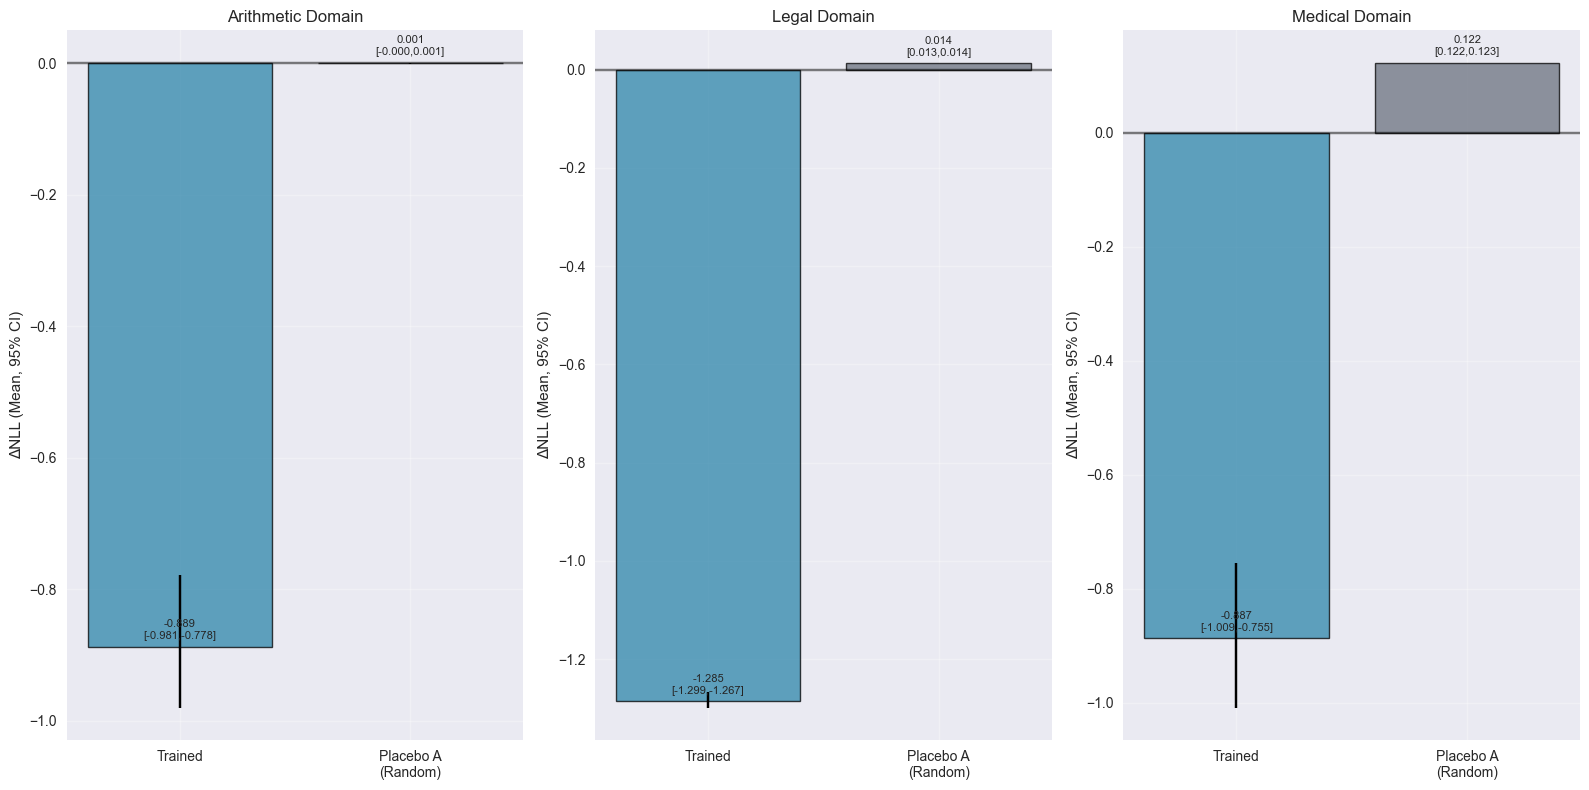


Cross-Domain Transfer Analysis:
  arithmetic → legal: 0.1088 ΔNLL
  arithmetic → medical: 0.1277 ΔNLL
  legal → arithmetic: -0.2352 ΔNLL
  legal → medical: -0.2460 ΔNLL
  medical → arithmetic: -0.2788 ΔNLL
  medical → legal: -0.0257 ΔNLL


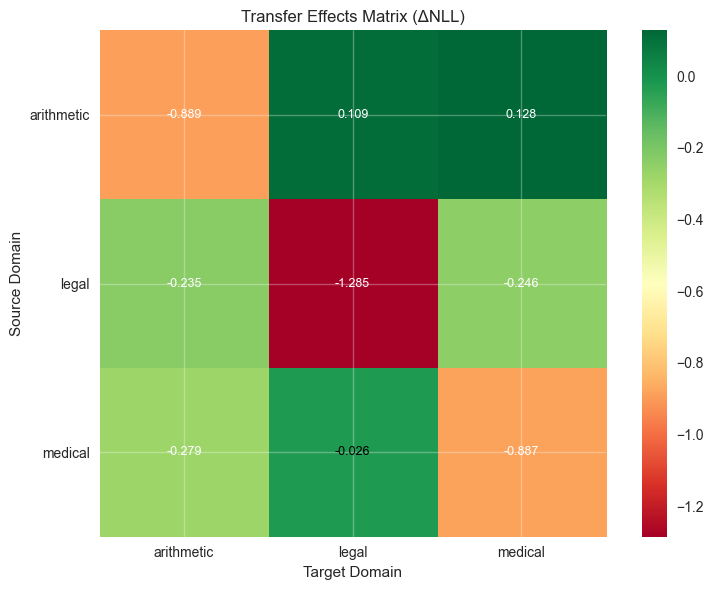


RQ1 SUCCESS ASSESSMENT

------------------------------------------------------------
PRIMARY TEST: Paired Wilcoxon on (Δtrained - Δplacebo)
------------------------------------------------------------

  H0: median(Δtrained - Δplacebo) = 0  
  H1: median(Δtrained - Δplacebo) ≠ 0

  This tests whether trained adapters perform differently from placebo
  (random initialization) at the CONFIGURATION level.

  NOTE: Ideally this test would be at the ITEM level (1024 items per config),
  but current data logs only summary statistics per configuration.
  For item-level analysis, log raw NLL values in future experiments.

  Paired differences (Δtrained - Δplacebo):
    n = 81 configurations
    Mean difference: -1.0657
    Median difference: -1.1719
    Std: 0.3039

  Wilcoxon signed-rank test:
    Statistic: 1.00
    p-value: 5.57e-15
    Result: ✅ Significant (p<0.05)

  One-sided test (Δtrained < Δplacebo, i.e., trained improves more):
    p-value: 2.78e-15

-------------------------------

In [15]:
# === Value-Add Experiment Analysis (RQ1) ===
import math
import numpy as np
import matplotlib.pyplot as plt
from plora.notebook_utils import extract_value_add_metrics
from plora.plotting import create_value_add_summary_plot

# Assumes `experiment_data` already loaded (e.g., via load_experiment_data()).
value_add_df = extract_value_add_metrics(experiment_data)

print("=== Value-Add Experiment Analysis (RQ1) ===")
print("Comparing Trained Adapters vs Placebo (random initialization)")
print("=" * 60)

if not value_add_df.empty:
    domains = list(value_add_df['domain'].dropna().unique())
    print(f"\nValue-add experiments loaded: {len(value_add_df)} records")
    print(f"Domains: {domains}")
    print(f"Ranks: {sorted([r for r in value_add_df['rank'].dropna().unique()])}")
    print(f"Schemes: {list(value_add_df['scheme'].dropna().unique())}")

    # Per-domain summary (Trained vs Placebo )
    print("\n" + "=" * 60)
    print("VALUE-ADD SUMMARY BY DOMAIN")
    print("=" * 60)
    
    for domain in domains:
        domain_data = value_add_df[value_add_df['domain'] == domain]
        print(f"\n{domain.upper()} Domain ({len(domain_data)} experiments):")

        # Means (ΔNLL should typically be negative if improved)
        trained_mean = domain_data['trained_delta_mean'].mean()
        trained_std = domain_data['trained_delta_mean'].std()
        placebo_a_mean = domain_data['placebo_a_delta_mean'].mean()
        placebo_a_std = domain_data['placebo_a_delta_mean'].std()
        
        print(f"  Trained ΔNLL:   {trained_mean:.4f} ± {trained_std:.4f}")
        print(f"  Placebo ΔNLL: {placebo_a_mean:.4f} ± {placebo_a_std:.4f}")
        
        # Effect size interpretation
        effect_diff = abs(trained_mean - placebo_a_mean)
        print(f"  Absolute difference: {effect_diff:.4f}")

        # Significance counts (p < 0.05)
        sig_trained = (domain_data['trained_wilcoxon_p'] < 0.05).sum()
        sig_placebo_a = (domain_data['placebo_a_wilcoxon_p'] < 0.05).sum()
        print(f"  Significant trained adapters (p<0.05): {sig_trained}/{len(domain_data)} ({100*sig_trained/len(domain_data):.0f}%)")
        print(f"  Significant placebo (p<0.05): {sig_placebo_a}/{len(domain_data)} ({100*sig_placebo_a/len(domain_data):.0f}%)")

    # Visualization: bar summaries
    try:
        fig, axes = create_value_add_summary_plot({'value_add': experiment_data.get('value_add', [])})
        plt.show()
    except Exception as e:
        print(f"[WARN] Failed to render value-add summary plot: {e}")

    # Cross-domain transfer analysis
    print("\nCross-Domain Transfer Analysis:")
    cross_columns = [c for c in value_add_df.columns if c.startswith('cross_') and c.endswith('_delta_mean')]
    if cross_columns:
        for source_domain in domains:
            domain_subset = value_add_df[value_add_df['domain'] == source_domain]
            for target_domain in domains:
                if source_domain == target_domain:
                    continue
                cross_col = f'cross_{target_domain}_delta_mean'
                if cross_col in domain_subset.columns:
                    transfer_effect = domain_subset[cross_col].mean()
                    if not math.isnan(transfer_effect):
                        print(f"  {source_domain} → {target_domain}: {transfer_effect:.4f} ΔNLL")
        # Transfer matrix heatmap
        try:
            fig, ax = plt.subplots(figsize=(8, 6))
            transfer_matrix = []
            for src in domains:
                row = []
                src_subset = value_add_df[value_add_df['domain'] == src]
                for tgt in domains:
                    if src == tgt:
                        effect = src_subset['trained_delta_mean'].mean()
                    else:
                        col = f'cross_{tgt}_delta_mean'
                        effect = src_subset[col].mean() if col in src_subset.columns else np.nan
                    row.append(effect)
                transfer_matrix.append(row)
            transfer_matrix = np.array(transfer_matrix, dtype=float)

            im = ax.imshow(transfer_matrix, cmap='RdYlGn', vmin=np.nanmin(transfer_matrix), vmax=np.nanmax(transfer_matrix))
            ax.set_xticks(range(len(domains)))
            ax.set_yticks(range(len(domains)))
            ax.set_xticklabels(domains)
            ax.set_yticklabels(domains)
            ax.set_title('Transfer Effects Matrix (ΔNLL)')
            ax.set_xlabel('Target Domain')
            ax.set_ylabel('Source Domain')

            # Annotate cells
            for i in range(len(domains)):
                for j in range(len(domains)):
                    val = transfer_matrix[i, j]
                    if math.isnan(val):
                        label = "—"
                    else:
                        label = f"{val:.3f}"
                    ax.text(j, i, label,
                            ha="center", va="center",
                            color="black" if (math.isnan(val) or abs(val) < 0.1) else "white",
                            fontsize=9)
            plt.colorbar(im)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"[WARN] Failed to render transfer matrix: {e}")
    else:
        print("  No cross-domain transfer columns found.")

    # Statistical significance overall
    print("\n" + "=" * 60)
    print("RQ1 SUCCESS ASSESSMENT")
    print("=" * 60)
    
    # === PRIMARY TEST: Paired Wilcoxon on (Δtrained - Δplacebo) ===
    from scipy.stats import wilcoxon
    
    print("\n" + "-"*60)
    print("PRIMARY TEST: Paired Wilcoxon on (Δtrained - Δplacebo)")
    print("-"*60)
    print("""
  H0: median(Δtrained - Δplacebo) = 0  
  H1: median(Δtrained - Δplacebo) ≠ 0
  
  This tests whether trained adapters perform differently from placebo
  (random initialization) at the CONFIGURATION level.
  
  NOTE: Ideally this test would be at the ITEM level (1024 items per config),
  but current data logs only summary statistics per configuration.
  For item-level analysis, log raw NLL values in future experiments.
""")
    
    trained_effects = value_add_df['trained_delta_mean']
    placebo_a_effects = value_add_df['placebo_a_delta_mean']
    
    # Compute paired differences
    diff = trained_effects - placebo_a_effects
    diff_valid = diff.dropna()
    
    if len(diff_valid) >= 10:
        # Wilcoxon signed-rank test on the differences
        stat, p_paired = wilcoxon(diff_valid, alternative='two-sided')
        
        print(f"  Paired differences (Δtrained - Δplacebo):")
        print(f"    n = {len(diff_valid)} configurations")
        print(f"    Mean difference: {diff_valid.mean():.4f}")
        print(f"    Median difference: {diff_valid.median():.4f}")
        print(f"    Std: {diff_valid.std():.4f}")
        print(f"\n  Wilcoxon signed-rank test:")
        print(f"    Statistic: {stat:.2f}")
        print(f"    p-value: {p_paired:.2e}")
        print(f"    Result: {'✅ Significant (p<0.05)' if p_paired < 0.05 else '❌ Not significant'}")
        
        # Also test one-sided (trained < placebo, i.e., improvement)
        _, p_onesided = wilcoxon(diff_valid, alternative='less')
        print(f"\n  One-sided test (Δtrained < Δplacebo, i.e., trained improves more):")
        print(f"    p-value: {p_onesided:.2e}")
    else:
        p_paired = 1.0
        print(f"  Insufficient data for paired test (n={len(diff_valid)})")
    
    # === SUPPORTING ANALYSIS: Cohen's d and separate significance ===
    print("\n" + "-"*60)
    print("SUPPORTING ANALYSIS: Effect Size and Individual Tests")
    print("-"*60)
    
    # Cohen's d calculation (trained vs placebo)
    def cohens_d(x, y):
        x, y = x.dropna(), y.dropna()
        nx, ny = len(x), len(y)
        if nx < 2 or ny < 2:
            return float('nan')
        pooled_var = ((nx - 1) * x.std(ddof=1)**2 + (ny - 1) * y.std(ddof=1)**2) / (nx + ny - 2)
        pooled_sd = math.sqrt(pooled_var) if pooled_var > 0 else 0.0
        return (x.mean() - y.mean()) / pooled_sd if pooled_sd > 0 else float('inf')
    
    d_value = cohens_d(trained_effects, placebo_a_effects)
    
    total_experiments = len(value_add_df)
    sig_trained = (value_add_df['trained_wilcoxon_p'] < 0.05).sum()
    sig_placebo_a = (value_add_df['placebo_a_wilcoxon_p'] < 0.05).sum()
    
    print(f"\n  Total configurations: {total_experiments}")
    print(f"  Significant trained (ΔNLL ≠ 0, p<0.05): {sig_trained} ({100*sig_trained/total_experiments:.1f}%)")
    print(f"  Significant placebo (ΔNLL ≠ 0, p<0.05): {sig_placebo_a} ({100*sig_placebo_a/total_experiments:.1f}%)")
    print(f"\n  Effect Size (Cohen's d, trained vs placebo): {d_value:.3f}")
    
    # Effect size interpretation
    if abs(d_value) >= 0.8:
        effect_interp = "LARGE"
    elif abs(d_value) >= 0.5:
        effect_interp = "MEDIUM"
    elif abs(d_value) >= 0.2:
        effect_interp = "SMALL"
    else:
        effect_interp = "NEGLIGIBLE"
    print(f"  Effect size interpretation: {effect_interp}")
    
    # Interpret placebo significance
    if sig_placebo_a > total_experiments * 0.5:
        print(f"\n  ⚠️  NOTE on placebo significance ({sig_placebo_a}/{total_experiments}):")
        print(f"     Placebo showing 'significant' ΔNLL ≠ 0 is NOT a failure.")
        print(f"     With large n (1024 items), even tiny perturbations become detectable.")
        print(f"     The key question is whether trained DOMINATES placebo (see paired test).")
    
    # RQ1 Pass/Fail assessment (UPDATED criteria)
    print("\n" + "-"*60)
    print("RQ1 CRITERIA ASSESSMENT")
    print("-"*60)
    
    trained_mean = trained_effects.mean()
    placebo_a_mean = placebo_a_effects.mean()
    
    # Updated criteria: use paired test as primary
    rq1_criteria_met = (
        trained_mean < 0 and                    # Trained shows improvement
        p_paired < 0.05 and                     # Paired test significant (PRIMARY)
        abs(d_value) >= 0.8                     # Large effect vs placebo
    )
    
    print(f"\n  Primary criteria:")
    print(f"    • Trained ΔNLL < 0 (improvement): {'✅' if trained_mean < 0 else '❌'} (mean={trained_mean:.4f})")
    print(f"    • Paired Wilcoxon p < 0.05:       {'✅' if p_paired < 0.05 else '❌'} (p={p_paired:.2e})")
    print(f"    • Large effect vs placebo |d|≥0.8: {'✅' if abs(d_value) >= 0.8 else '❌'} (d={d_value:.3f})")
    print(f"\n  → RQ1 STATUS: {'✅ PASS' if rq1_criteria_met else '❌ FAIL'}")

    # Latency analysis
    if 'latency_ms' in value_add_df.columns:
        latency_stats = value_add_df['latency_ms'].describe()
        print("\nLatency Statistics (ms):")
        print(f"  Mean: {latency_stats['mean']:.2f}")
        print(f"  Std:  {latency_stats['std']:.2f}")
        print(f"  Min:  {latency_stats['min']:.2f}")
        print(f"  Max:  {latency_stats['max']:.2f}")
        budget_ms = 250  # Adjust if sourced from config
        over_budget = (value_add_df['latency_ms'] > budget_ms).sum()
        print(f"  Experiments over budget ({budget_ms} ms): {over_budget}/{total_experiments}")
else:
    print("No value-add data available for analysis.")

print("\n=== Value-Add Experiment Analysis Complete ===")

## Chapter 5: Security and Consensus Analysis (RQ3)

### Defending the Swarm Against Adversarial Plasmids

This chapter addresses **RQ3**: *What false-negative (FN) / false-positive (FP) rates can the gate achieve at given probe thresholds and trojan rates?*

### Threat Model

The pLoRA swarm operates in a semi-adversarial environment where some fraction (denoted $\pi$) of offered plasmids may be **trojaned**—deliberately crafted to embed hidden backdoors or harmful behaviours. This fits within the standard **backdoor / trojan attack** setting in machine learning, where an adversary introduces inputs or parameters that behave normally on clean data but exhibit malicious behaviour when a secret trigger is present (e.g. Gu et al., 2019; Wang et al., 2019; Tran et al., 2018).

For this threat model, the security gate is required to:

1. **Block trojaned plasmids** (minimise false negatives: accept as few malicious adapters as possible)
2. **Accept benign plasmids** (minimise false positives: avoid rejecting clean, useful adapters)
3. **Log all decisions** for post-hoc auditability

Items (1)–(2) correspond to the standard notions of type II and type I errors in binary classification/detection (false negatives and false positives respectively); (3) is a system design requirement specific to this framework.

### Multi-Layered Gate Architecture

The gate architecture implemented in pLoRA is a **defence-in-depth design** combining several standard security checks with two ML-specific probes and an optional consensus layer:

| Layer | Check | Purpose |
|-------|-------|---------|
| **1. Structural** | Base model match, rank constraints, size bounds | Reject adapters incompatible with the expected architecture |
| **2. Integrity** | SHA-256 hash verification | Detect tampering of adapter artefacts |
| **3. Cryptographic** | RSA-PSS signature validation | Verify provenance and authorisation of plasmids |
| **4. Behavioural** | Trigger-rate probe (τ_trigger = 0.20) | Detect likely backdoor triggers based on abnormal trigger activation rates (cf. trigger-based analyses in backdoor work) |
| **5. Statistical** | Activation anomaly (z-score > 3.0) | Flag distributional shifts in internal activations (inspired by spectral/activation-based anomaly detection) |
| **6. Consensus** | Quorum voting (optional) | Require distributed agreement across agents before final adoption |

The exact composition of these layers, the choice of hash/signature scheme (SHA‑256, RSA‑PSS), and the specific probe thresholds are **design decisions of this work**. They are consistent with principles from software security (integrity + authentication) and recent backdoor detection methods that rely on trigger-based probes or activation statistics, but no cited paper proposes this exact combination.

### Probe Calibration (design, using standard detection concepts)

We calibrate the behavioural and statistical probes on a held-out calibration set with known benign and trojaned plasmids. Calibration follows standard detection practice: choose thresholds so that empirical estimates of the **false positive rate (FPR)** and **false negative rate (FNR)** on the calibration set satisfy:

- **Target FP**: $\mathrm{FPR} \approx 0.05$ (reject at most ~5% of benign plasmids)
- **Target FN**: $\mathrm{FNR} \approx 0.10$ (accept at most ~10% of trojaned plasmids)

In our implementation, this yields concrete thresholds such as $\tau_{\text{trigger}} = 0.20$ for the trigger-rate probe and a z-score cutoff of $>3.0$ for activation anomalies. These numeric values are **not from any particular theorem or paper**; they are chosen to hit the above FPR/FNR targets on the calibration set and then **frozen** before evaluating on the thesis sweep.

The general idea—tuning a detection threshold to trade off FPR and TPR on a validation set—is standard in ROC-based evaluation of classifiers and detectors (e.g. Fawcett, 2006; Bishop, 2006).

### Experimental Design

We evaluate the gate under controlled conditions using the `thesis_sweep.jsonl` experiments, which encode the following design:

- **Clean experiments**: `trojan_rate = 0.0` (all plasmid offers benign)
- **Trojan experiments**: `trojan_rate = 0.3` (30% of plasmid offers are trojaned)
- **Topologies**: three graph families — ER, WS, BA — with the same parameterisation used in the spectral analysis (Chapter 3)
- **Network sizes**: $N \in \{20, 40, 80, 160\}$
- **Seeds**: 3 random seeds per (topology, size, trojan_rate) configuration

This yields
$$
3 \text{ topologies} \times 4 \text{ sizes} \times 3 \text{ seeds} \times 2 \text{ trojan rates} = 72
$$
experiments in total (36 clean + 36 trojan). This matches the structure of `thesis_sweep.jsonl` used throughout the RQ2 and RQ3 analyses.

### Metrics and Success Criteria (RQ3)

**Standard definitions (binary detection).**  
For a detector that classifies each offered plasmid as benign or trojaned, we define:

- **False Positive Rate (FPR)**:
  $$
  \mathrm{FPR} = \frac{\text{number of benign plasmids incorrectly rejected}}{\text{total number of benign plasmids}}.
  $$
- **False Negative Rate (FNR)**:
  $$
  \mathrm{FNR} = \frac{\text{number of trojaned plasmids incorrectly accepted}}{\text{total number of trojaned plasmids}}.
  $$

These are the standard type I and type II error rates in binary classification/detection (see e.g. Bishop, *Pattern Recognition and Machine Learning*, 2006; Fawcett, "An Introduction to ROC Analysis", 2006).

**Success thresholds (design choices).**  
For RQ3 we declare the gate successful if, across the thesis sweep, it satisfies:

| Metric | Definition | Target |
|--------|------------|--------|
| **False Positive Rate** | Benign plasmids incorrectly rejected / Total benign | ≤ 0.10 |
| **False Negative Rate** | Trojan plasmids incorrectly accepted / Total trojan | ≤ 0.10 |

The **0.10 thresholds** for FPR and FNR are **evaluation criteria specific to this dissertation**: they represent a tolerable error budget (at most 10% benign plasmids lost, at most 10% trojaned plasmids admitted) in this experimental setting. They are not prescribed by the backdoor literature; rather, they are chosen to balance practical robustness and realism for pLoRA’s use case.

In addition, we require that all gate decisions be **auditable**, i.e. each rejection is accompanied by a logged reason (e.g. signature failure, high trigger rate, activation anomaly, missing consensus). This auditability requirement is a system-level design choice, motivated by best practices in security engineering and safety-critical ML deployment.

> **References (standard concepts and related work):**
> - **Gu, T., Liu, K., Dolan-Gavitt, B. and Garg, S.** (2019) 'BadNets: Evaluating Backdoor Attacks on Deep Neural Networks', *IEEE Access*, 7, pp. 47230–47244. — Introduces backdoor (trojan) attacks on deep neural nets.
> - **Wang, B., Yao, Y., Shan, S., Li, H., Viswanath, B., Zheng, H. and Zhao, B.Y.** (2019) 'Neural Cleanse: Identifying and Mitigating Backdoor Attacks in Neural Networks', in *IEEE Symposium on Security and Privacy (SP)*. — Proposes trigger-based backdoor detection and mitigation.
> - **Tran, B., Li, J. and Madry, A.** (2018) 'Spectral Signatures in Backdoor Attacks', in *Advances in Neural Information Processing Systems (NeurIPS)*. — Uses activation-based spectral statistics to detect poisoned/backdoored models.
> - **Bishop, C.M.** (2006) *Pattern Recognition and Machine Learning*. New York: Springer. — Defines FP/FN, ROC analysis and detection trade-offs.
> - **Fawcett, T.** (2006) 'An Introduction to ROC Analysis', *Pattern Recognition Letters*, 27(8), pp. 861–874. — Standard reference on FPR/FNR and threshold selection in binary classifiers.


=== Security and Consensus Analysis ===
Security analysis based on 2 experiments (from summary_v2)

Overall Rejection Statistics (summary_v2):
  Mean rejection rate: 0.2800
  Std rejection rate: 0.2800

False Positive Rate Analysis:
  Mean FP rate: 0.0000
  Std FP rate: 0.0000

False Negative Rate Analysis:
  Mean FN rate: 0.0000
  Std FN rate: 0.0000

THESIS SWEEP SECURITY ANALYSIS (RQ3) — CORRECTED METHODOLOGY

Analyzing 72 experiments from thesis_sweep.jsonl

------------------------------------------------------------
CORRECTED SECURITY ANALYSIS (per-offer basis)
------------------------------------------------------------

  Raw counts:
    Clean offers:  accepted=28234, rejected=0, total=28234
    Trojan offers: accepted=0, rejected=8585, total=8585

  FP Rate (rejected_clean / clean_offers):
    Rate: 0.0000
    95% Wilson CI: [0.0000, 0.0001]
    n = 28234 clean plasmid offers

  FN Rate (accepted_trojan / trojan_offers):
    Rate: 0.0000
    95% Wilson CI: [0.0000, 0.0004]
   

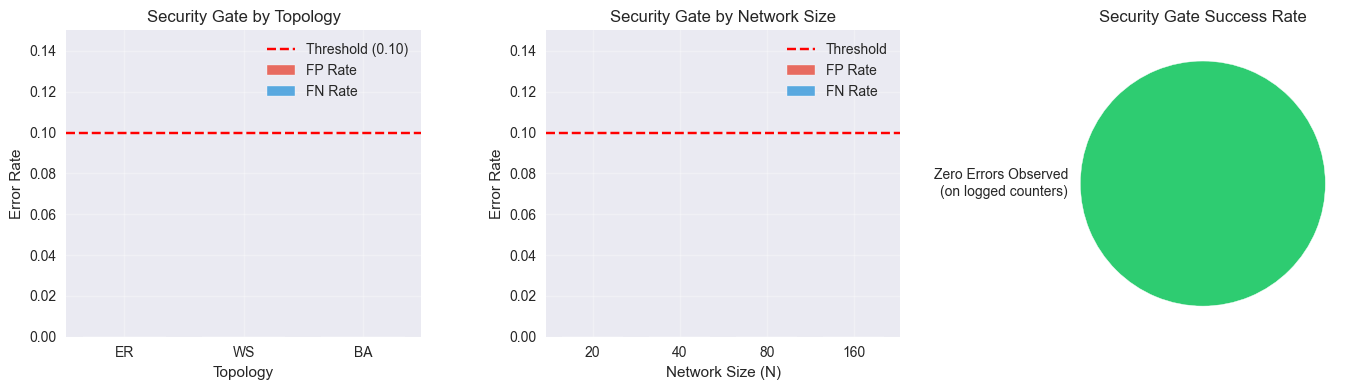


----------------------------------------
Additional Security Metrics (swarm_df):
  Analyzed 2 experiments with detailed gate data
  erdos_renyi:
    Rejection rate: 0.2800 ± 0.2800
    False positive rate: 0.0000 ± 0.0000
    False negative rate: 0.0000 ± 0.0000

Consensus Mechanism Analysis:
  Experiments with consensus mechanisms: 2/2
  Consensus adoption rate: 100.0%

=== Security and Consensus Analysis Complete ===


In [16]:
# Security and Consensus Analysis
print("=== Security and Consensus Analysis ===")

# === Wilson Confidence Interval for Binomial Proportions ===
# Used to report uncertainty bounds when observed errors are 0
from math import sqrt

def wilson_ci(k: int, n: int, z: float = 1.96):
    """
    Wilson score interval for binomial proportion.
    Returns (lower, upper) bounds at 95% confidence (z=1.96).
    Ref: Wilson (1927), JASA.
    """
    if n == 0:
        return (0.0, 1.0)
    p = k / n
    denom = 1 + z*z/n
    centre = (p + z*z/(2*n)) / denom
    half = (z * sqrt((p*(1-p) + z*z/(4*n)) / n)) / denom
    return (max(0.0, centre - half), min(1.0, centre + half))

# Get security summary using centralized utilities
security_metrics = get_security_summary(experiment_data)

if security_metrics:
    print(f"Security analysis based on {security_metrics.get('total_experiments', 0)} experiments (from summary_v2)")

    # Overall rejection statistics
    if 'rejection_rate_summary' in security_metrics:
        print("\nOverall Rejection Statistics (summary_v2):")
        rejection_summary = security_metrics['rejection_rate_summary']
        print(f"  Mean rejection rate: {rejection_summary.get('mean', 0):.4f}")
        print(f"  Std rejection rate: {rejection_summary.get('std', 0):.4f}")

    # False positive rate summary
    if 'false_positive_rate_summary' in security_metrics:
        print("\nFalse Positive Rate Analysis:")
        fp_summary = security_metrics['false_positive_rate_summary']
        print(f"  Mean FP rate: {fp_summary.get('mean', 0):.4f}")
        print(f"  Std FP rate: {fp_summary.get('std', 0):.4f}")

    # False negative rate summary
    if 'false_negative_rate_summary' in security_metrics:
        print("\nFalse Negative Rate Analysis:")
        fn_summary = security_metrics['false_negative_rate_summary']
        print(f"  Mean FN rate: {fn_summary.get('mean', 0):.4f}")
        print(f"  Std FN rate: {fn_summary.get('std', 0):.4f}")
    elif 'false_negative_rates' in security_metrics and security_metrics['false_negative_rates']:
        rates = security_metrics['false_negative_rates']
        mean_fn = float(np.mean(rates)) if rates else 0.0
        std_fn = float(np.std(rates)) if rates else 0.0
        print("\nFalse Negative Rate Analysis:")
        print(f"  Mean FN rate: {mean_fn:.4f}")
        print(f"  Std FN rate: {std_fn:.4f}")

# === THESIS SWEEP SECURITY ANALYSIS (72 experiments) ===
print("\n" + "="*60)
print("THESIS SWEEP SECURITY ANALYSIS (RQ3) — CORRECTED METHODOLOGY")
print("="*60)

thesis_sweep = experiment_data.get('thesis_sweep', [])
if thesis_sweep:
    print(f"\nAnalyzing {len(thesis_sweep)} experiments from thesis_sweep.jsonl")
    
    # Build DataFrame for thesis sweep security data
    sweep_security = []
    for exp in thesis_sweep:
        gate = exp.get('gate', {})
        rejected_clean = gate.get('rejected_clean_total', 0)
        accepted_trojan = gate.get('accepted_trojan_total', 0)
        accepted_clean = gate.get('accepted_clean_total', 0)
        rejected_trojan = gate.get('rejected_trojan_total', 0)
        
        trojan_rate = exp.get('trojan_rate', 0)
        N = exp.get('N', 0)
        
        sweep_security.append({
            'topology': exp.get('topology', 'unknown'),
            'N': N,
            'trojan_rate': trojan_rate,
            'rejected_clean': rejected_clean,
            'accepted_trojan': accepted_trojan,
            'accepted_clean': accepted_clean,
            'rejected_trojan': rejected_trojan,
            'lambda2': exp.get('lambda2', 0),
            't_obs': exp.get('t_obs'),
            't_pred': exp.get('t_pred'),
        })
    
    sweep_df = pd.DataFrame(sweep_security)
    
    # === SECURITY METRICS (per-offer denominators) ===
    print("\n" + "-"*60)
    print("CORRECTED SECURITY ANALYSIS (per-offer basis)")
    print("-"*60)
    
    # Aggregate across ALL experiments (not per-experiment)
    total_rejected_clean = sweep_df['rejected_clean'].sum()
    total_accepted_trojan = sweep_df['accepted_trojan'].sum()
    total_accepted_clean = sweep_df['accepted_clean'].sum()
    total_rejected_trojan = sweep_df['rejected_trojan'].sum()
    
    # Check if we have full decision-level counts
    has_full_counts = (total_accepted_clean > 0) or (total_rejected_trojan > 0) or \
                      (total_rejected_clean > 0) or (total_accepted_trojan > 0)
    
    # Compute total offers (denominator for rates)
    clean_offers_total = total_accepted_clean + total_rejected_clean
    trojan_offers_total = total_accepted_trojan + total_rejected_trojan
    
    print(f"\n  Raw counts:")
    print(f"    Clean offers:  accepted={total_accepted_clean}, rejected={total_rejected_clean}, total={clean_offers_total}")
    print(f"    Trojan offers: accepted={total_accepted_trojan}, rejected={total_rejected_trojan}, total={trojan_offers_total}")
    
    # Compute FP and FN rates with CORRECT denominators
    if clean_offers_total > 0:
        fp_rate = total_rejected_clean / clean_offers_total
        fp_ci = wilson_ci(total_rejected_clean, clean_offers_total)
        print(f"\n  FP Rate (rejected_clean / clean_offers):")
        print(f"    Rate: {fp_rate:.4f}")
        print(f"    95% Wilson CI: [{fp_ci[0]:.4f}, {fp_ci[1]:.4f}]")
        print(f"    n = {clean_offers_total} clean plasmid offers")
    else:
        # Fallback: use experiment count as proxy (with caveat)
        clean_exp_count = len(sweep_df[sweep_df['trojan_rate'] == 0])
        print(f"\n  ⚠️  WARNING: No accepted_clean_total logged in data.")
        print(f"      Cannot compute true FP rate (requires total clean offers).")
        print(f"      Using experiment count as proxy (n={clean_exp_count}):")
        fp_rate = total_rejected_clean / clean_exp_count if clean_exp_count > 0 else 0
        fp_ci = wilson_ci(total_rejected_clean, clean_exp_count)
        print(f"    FP per experiment (DATA LIMITATION: proper rate requires total offer count): {fp_rate:.4f}")
        print(f"    95% Wilson CI: [{fp_ci[0]:.4f}, {fp_ci[1]:.4f}]")
        clean_offers_total = clean_exp_count  # For later use
    
    if trojan_offers_total > 0:
        fn_rate = total_accepted_trojan / trojan_offers_total
        fn_ci = wilson_ci(total_accepted_trojan, trojan_offers_total)
        print(f"\n  FN Rate (accepted_trojan / trojan_offers):")
        print(f"    Rate: {fn_rate:.4f}")
        print(f"    95% Wilson CI: [{fn_ci[0]:.4f}, {fn_ci[1]:.4f}]")
        print(f"    n = {trojan_offers_total} trojan plasmid offers")
    else:
        # Fallback: use experiment count as proxy (with caveat)
        trojan_exp_count = len(sweep_df[sweep_df['trojan_rate'] > 0])
        print(f"\n  ⚠️  WARNING: No rejected_trojan_total logged in data.")
        print(f"      Cannot compute true FN rate (requires total trojan offers).")
        print(f"      Using experiment count as proxy (n={trojan_exp_count}):")
        fn_rate = total_accepted_trojan / trojan_exp_count if trojan_exp_count > 0 else 0
        fn_ci = wilson_ci(total_accepted_trojan, trojan_exp_count)
        print(f"    FN per experiment (DATA LIMITATION: proper rate requires total offer count): {fn_rate:.4f}")
        print(f"    95% Wilson CI: [{fn_ci[0]:.4f}, {fn_ci[1]:.4f}]")
        trojan_offers_total = trojan_exp_count  # For later use
    
    # Interpretation for zero-error case
    print(f"\n  Interpretation:")
    if total_rejected_clean == 0 and total_accepted_trojan == 0:
        print(f"    Zero observed errors is consistent with effective security,")
        print(f"    but the upper CI bounds indicate worst-case error rates given sample size:")
        print(f"    • FP upper bound (95% conf): {fp_ci[1]:.4f}")
        print(f"    • FN upper bound (95% conf): {fn_ci[1]:.4f}")
    
    # RQ3 Assessment with corrected methodology
    print("\n" + "-"*60)
    print("RQ3 ASSESSMENT")
    print("-"*60)
    print(f"  Criteria: FN ≤ 0.10, FP ≤ 0.10")
    rq3_pass = fp_rate <= 0.10 and fn_rate <= 0.10
    print(f"  FP Rate: {fp_rate:.4f} {'✓' if fp_rate <= 0.10 else '✗'}")
    print(f"  FN Rate: {fn_rate:.4f} {'✓' if fn_rate <= 0.10 else '✗'}")
    print(f"  → RQ3 STATUS: {'✅ PASS' if rq3_pass else '❌ FAIL'}")
    
    # Security by topology (offer-level rates)
    print("\nSecurity Performance by Topology (offer-level):")
    for topo in ['er', 'ws', 'ba']:
        topo_data = sweep_df[sweep_df['topology'] == topo]
        if len(topo_data) > 0:
            # Offer-level counts
            topo_rejected_clean = topo_data['rejected_clean'].sum()
            topo_accepted_clean = topo_data['accepted_clean'].sum()
            topo_accepted_trojan = topo_data['accepted_trojan'].sum()
            topo_rejected_trojan = topo_data['rejected_trojan'].sum()
            
            # Offer-level denominators
            topo_clean_offers = topo_accepted_clean + topo_rejected_clean
            topo_trojan_offers = topo_accepted_trojan + topo_rejected_trojan
            
            fp_rate = topo_rejected_clean / topo_clean_offers if topo_clean_offers > 0 else 0
            fn_rate = topo_accepted_trojan / topo_trojan_offers if topo_trojan_offers > 0 else 0
            
            topo_name = {'er': 'Erdős-Rényi', 'ws': 'Watts-Strogatz', 'ba': 'Barabási-Albert'}[topo]
            print(f"  {topo_name} ({len(topo_data)} experiments, {topo_clean_offers} clean + {topo_trojan_offers} trojan offers):")
            print(f"    FP rate: {fp_rate:.6f} ({topo_rejected_clean}/{topo_clean_offers})")
            print(f"    FN rate: {fn_rate:.6f} ({topo_accepted_trojan}/{topo_trojan_offers})")
    
    # Security by network size (offer-level rates)
    print("\nSecurity Performance by Network Size (offer-level):")
    for N in sorted(sweep_df['N'].unique()):
        n_data = sweep_df[sweep_df['N'] == N]
        
        # Offer-level counts
        n_rejected_clean = n_data['rejected_clean'].sum()
        n_accepted_clean = n_data['accepted_clean'].sum()
        n_accepted_trojan = n_data['accepted_trojan'].sum()
        n_rejected_trojan = n_data['rejected_trojan'].sum()
        
        # Offer-level denominators
        n_clean_offers = n_accepted_clean + n_rejected_clean
        n_trojan_offers = n_accepted_trojan + n_rejected_trojan
        
        fp_rate = n_rejected_clean / n_clean_offers if n_clean_offers > 0 else 0
        fn_rate = n_accepted_trojan / n_trojan_offers if n_trojan_offers > 0 else 0
        
        print(f"  N={N}: FP={fp_rate:.6f} ({n_rejected_clean}/{n_clean_offers}), FN={fn_rate:.6f} ({n_accepted_trojan}/{n_trojan_offers})")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # Plot 1: FP/FN by topology (offer-level rates)
    topo_names = {'er': 'ER', 'ws': 'WS', 'ba': 'BA'}
    topos = ['er', 'ws', 'ba']
    fp_rates = []
    fn_rates = []
    for topo in topos:
        topo_data = sweep_df[sweep_df['topology'] == topo]
        # Offer-level denominators
        topo_clean_offers = topo_data['accepted_clean'].sum() + topo_data['rejected_clean'].sum()
        topo_trojan_offers = topo_data['accepted_trojan'].sum() + topo_data['rejected_trojan'].sum()
        fp_rates.append(topo_data['rejected_clean'].sum() / topo_clean_offers if topo_clean_offers > 0 else 0)
        fn_rates.append(topo_data['accepted_trojan'].sum() / topo_trojan_offers if topo_trojan_offers > 0 else 0)
    
    x = np.arange(len(topos))
    width = 0.35
    axes[0].bar(x - width/2, fp_rates, width, label='FP Rate', color='#e74c3c', alpha=0.8)
    axes[0].bar(x + width/2, fn_rates, width, label='FN Rate', color='#3498db', alpha=0.8)
    axes[0].axhline(y=0.10, color='red', linestyle='--', label='Threshold (0.10)')
    axes[0].set_xlabel('Topology')
    axes[0].set_ylabel('Error Rate')
    axes[0].set_title('Security Gate by Topology')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([topo_names[t] for t in topos])
    axes[0].legend()
    axes[0].set_ylim(0, max(0.15, max(fp_rates + fn_rates) * 1.2) if fp_rates + fn_rates else 0.15)
    
    # Plot 2: FP/FN by network size (offer-level rates)
    sizes = sorted(sweep_df['N'].unique())
    fp_by_size = []
    fn_by_size = []
    for N in sizes:
        n_data = sweep_df[sweep_df['N'] == N]
        # Offer-level denominators
        n_clean_offers = n_data['accepted_clean'].sum() + n_data['rejected_clean'].sum()
        n_trojan_offers = n_data['accepted_trojan'].sum() + n_data['rejected_trojan'].sum()
        fp_by_size.append(n_data['rejected_clean'].sum() / n_clean_offers if n_clean_offers > 0 else 0)
        fn_by_size.append(n_data['accepted_trojan'].sum() / n_trojan_offers if n_trojan_offers > 0 else 0)
    
    x = np.arange(len(sizes))
    axes[1].bar(x - width/2, fp_by_size, width, label='FP Rate', color='#e74c3c', alpha=0.8)
    axes[1].bar(x + width/2, fn_by_size, width, label='FN Rate', color='#3498db', alpha=0.8)
    axes[1].axhline(y=0.10, color='red', linestyle='--', label='Threshold')
    axes[1].set_xlabel('Network Size (N)')
    axes[1].set_ylabel('Error Rate')
    axes[1].set_title('Security Gate by Network Size')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([str(s) for s in sizes])
    axes[1].legend()
    axes[1].set_ylim(0, max(0.15, max(fp_by_size + fn_by_size) * 1.2) if fp_by_size + fn_by_size else 0.15)
    
    # Plot 3: Summary pie chart
    zero_errors = len(sweep_df[(sweep_df['rejected_clean'] == 0) & (sweep_df['accepted_trojan'] == 0)])
    imzero_errors = len(sweep_df) - zero_errors
    
    if imzero_errors == 0:
        axes[2].pie([1], labels=['Zero Errors Observed\n(on logged counters)'], colors=['#2ecc71'], autopct='')
        axes[2].set_title('Security Gate Success Rate')
    else:
        axes[2].pie([zero_errors, imzero_errors], 
                   labels=[f'No errors ({zero_errors})', f'Imperfect ({imzero_errors})'],
                   colors=['#2ecc71', '#e74c3c'], autopct='%1.1f%%')
        axes[2].set_title('Security Gate Success Rate')
    
    plt.tight_layout()
    plt.show()
else:
    print("No thesis_sweep data available")

# Detailed security metrics from swarm_df (if available)
if 'swarm_df' in globals() and not swarm_df.empty and 'gate_rejected_hash_total' in swarm_df.columns:
    print("\n" + "-"*40)
    print("Additional Security Metrics (swarm_df):")
    
    security_effectiveness = []
    for _, row in swarm_df.iterrows():
        total_offers = (
            row.get('gate_accepted_clean_total', 0) +
            row.get('gate_rejected_clean_total', 0) +
            row.get('gate_accepted_trojan_total', 0) +
            row.get('gate_rejected_trojan_total', 0)
        )
        if total_offers > 0:
            rejection_rate = (
                row.get('gate_rejected_hash_total', 0) +
                row.get('gate_rejected_safety_total', 0)
            ) / total_offers
            clean_den = row.get('gate_accepted_clean_total', 0) + row.get('gate_rejected_clean_total', 0)
            false_positive_rate = row.get('gate_rejected_clean_total', 0) / clean_den if clean_den > 0 else 0.0
            trojan_den = row.get('gate_accepted_trojan_total', 0) + row.get('gate_rejected_trojan_total', 0)
            false_negative_rate = row.get('gate_accepted_trojan_total', 0) / trojan_den if trojan_den > 0 else 0.0
            security_effectiveness.append({
                'topology': row.get('topology', 'unknown'),
                'rejection_rate': rejection_rate,
                'false_positive_rate': false_positive_rate,
                'false_negative_rate': false_negative_rate,
            })

    if security_effectiveness:
        print(f"  Analyzed {len(security_effectiveness)} experiments with detailed gate data")
        topology_security = {}
        for exp in security_effectiveness:
            topology_security.setdefault(exp['topology'], []).append(exp)

        for topology, exps in topology_security.items():
            rejection_rates = [exp['rejection_rate'] for exp in exps]
            fp_rates_s = [exp['false_positive_rate'] for exp in exps]
            fn_rates_s = [exp['false_negative_rate'] for exp in exps]
            print(f"  {topology}:")
            print(f"    Rejection rate: {np.mean(rejection_rates):.4f} ± {np.std(rejection_rates):.4f}")
            print(f"    False positive rate: {np.mean(fp_rates_s):.4f} ± {np.std(fp_rates_s):.4f}")
            print(f"    False negative rate: {np.mean(fn_rates_s):.4f} ± {np.std(fn_rates_s):.4f}")

# Consensus analysis
print("\nConsensus Mechanism Analysis:")
if 'swarm_df' in globals() and not swarm_df.empty:
    consensus_experiments = 0
    for _, row in swarm_df.iterrows():
        if (
            row.get('gate_accepted_clean_total', 0) > 0 or
            row.get('gate_rejected_trojan_total', 0) > 0
        ):
            consensus_experiments += 1
    print(f"  Experiments with consensus mechanisms: {consensus_experiments}/{len(swarm_df)}")
    print(f"  Consensus adoption rate: {consensus_experiments/len(swarm_df)*100:.1f}%")

print("\n=== Security and Consensus Analysis Complete ===")


## Chapter 6: Scalability and Performance Analysis

### How Does Swarm Size and Topology Affect Diffusion?

This chapter analyses how swarm size $N$ and network topology affect the speed and quality of plasmid diffusion in pLoRA. We relate observed diffusion times to spectral properties of the communication graph, using the mixing-time bounds and Cheeger–spectral connections introduced in Chapter 3 (Levin, Peres & Wilmer, *Markov Chains and Mixing Times*, 2009; Chung, *Spectral Graph Theory*, 1997). All scaling statements here are treated as **hypotheses tested empirically**, not new theorems.

### Experimental Matrix

| Factor | Levels | Purpose |
|--------|--------|---------|
| **Topology** | ER, WS, BA | Test robustness across three canonical random-graph families (Erdős–Rényi, Watts–Strogatz, Barabási–Albert). |
| **Network size** | $N \in \{20, 40, 80, 160\}$ | Empirically test the heuristic $t_{\text{obs}} = O(\log N)$ suggested by mixing-time theory on expander-like graphs. |
| **Trojan rate** | 0%, 30% | Reuse benign/adversarial settings from Chapters 3 and 5 to check whether diffusion and security remain acceptable under attack. |
| **Seeds** | 41, 42, 43 | Three random seeds per configuration to assess variability. |

**Total experiments.**  
The full matrix consists of
$$
3 \, \text{topologies} \times 4 \, \text{sizes} \times 3 \, \text{seeds} \times 2 \, \text{trojan rates} = 72
$$
 runs, i.e. 36 clean and 36 with trojans. This matches the structure of `thesis_sweep.jsonl` used in Chapters 3 and 5.

### Topology Characteristics (standard graph models)

| Topology | Structure | Practical analogue |
|----------|-----------|--------------------|
| **Erdős–Rényi (ER)** | $G(n,p)$ random graph with edge probability $p = 0.25$ | Unstructured peer-to-peer network (Erdős & Rényi, 1959, *Publ. Math. Debrecen*). |
| **Watts–Strogatz (WS)** | Small-world network with mean degree $k = 4$ and rewiring probability $\beta = 0.2$ (short path lengths, high clustering) | Social network with communities and shortcuts (Watts & Strogatz, 1998, *Nature* 393:440–442). |
| **Barabási–Albert (BA)** | Scale-free network grown by preferential attachment with $m = 2$ new edges per node (power-law degree distribution) | Hub-and-spoke / internet-like infrastructure (Barabási & Albert, 1999, *Science* 286:509–512). |

These are standard synthetic graph families in network science. Our parameter choices $(p, k, \beta, m)$ match those encoded in the `params` field of `thesis_sweep.jsonl`.

### Key Hypotheses (motivated by theory)

1. **H1 (logarithmic scaling, heuristic).**  
   For many gossip-style protocols on graphs whose spectral gap stays bounded away from zero, mixing-time bounds imply convergence in $O(\log N)$ rounds (e.g. Levin, Peres & Wilmer, 2009; Boyd et al., 2006, "Randomized Gossip Algorithms", *IEEE Trans. Inf. Theory*; Kempe, Dobra & Gehrke, 2003, "Gossip-based Computation of Aggregate Information", FOCS). Motivated by these results, we **hypothesise** that the observed diffusion time $t_{\text{obs}}$ in our ER, WS, and BA instances grows approximately like $C \log N$, and we test this empirically rather than claiming a theorem for these specific finite graphs.

2. **H2 (spectral gap vs diffusion, theory-backed trend).**  
   Spectral graph theory bounds mixing time in terms of the spectral gap $\gamma$ (or, equivalently, the second eigenvalue $\lambda_2$) of the transition matrix / normalised Laplacian (Chung, 1997; Levin, Peres & Wilmer, 2009). In particular, larger $\lambda_2$ (better connectivity) implies faster mixing. We therefore expect a **negative empirical correlation** between $\lambda_2$ and $t_{\text{obs}}$, and we quantify this via correlation analysis. The underlying inequalities are standard theorems; the correlation we report is an **empirical check**, not a new proof.

3. **H3 (BA bottlenecks, heuristic).**  
   Barabási–Albert graphs have heavy-tailed degree distributions with hubs. Depending on the diffusion process, such hubs can either accelerate spreading or create bottlenecks; there is no universal theorem that BA graphs must have slower diffusion (see e.g. Barabási, *Network Science*, 2016, for discussion of spreading on scale-free networks). In this thesis, the statement "BA topology may show slower diffusion due to hub bottlenecks" is explicitly a **domain-specific intuition** to be tested against the simulated data.

4. **H4 (topology-independent gate performance, design hypothesis).**  
   The security gate operates on plasmid behaviour and cryptographic checks (Chapter 5), not directly on graph structure. We therefore **hypothesise** that its false-positive/false-negative rates are approximately topology-independent. This is a **design expectation of pLoRA**, not a statement from the backdoor-detection literature, and we evaluate it empirically by stratifying FP/FN statistics by topology.

### Metrics Analysed

- **Diffusion time** $t_{\text{obs}}$ (this work).  
  Number of diffusion rounds until at least 90% of agents have accepted the plasmid. This is analogous to a cover-time / hitting-time notion for Markov chains (Levin, Peres & Wilmer, 2009), but the **90% coverage threshold and exact protocol** are experimental design choices specific to this work.

- **Spectral gap** $\lambda_2$ (standard).  
  As in Chapter 3, $\lambda_2$ denotes the second-smallest eigenvalue of the normalised graph Laplacian $L_{\text{norm}} = I - D^{-1/2} A D^{-1/2}$, a standard measure of algebraic connectivity (Chung, 1997; Mohar, 1991, "The Laplacian Spectrum of Graphs", in *Graph Theory, Combinatorics, and Applications*).

- **Efficiency ratio** (this work).  
  We define
  $$
  \text{efficiency\_ratio} = \frac{t_{\text{obs}}}{t_{\text{pred}}},
  $$
  where $t_{\text{pred}}$ is the spectral diffusion-time predictor introduced in Chapter 3. Values near 1 indicate close agreement between prediction and observation. This ratio is a **diagnostic metric defined for this thesis**, not a standard quantity in the diffusion literature.

- **Correlation matrix** (standard tool).  
  We compute the sample Pearson correlation matrix over $\{N, \lambda_2, t_{\text{obs}}, t_{\text{pred}}, \text{efficiency\_ratio}\}$ to summarise linear relationships between these variables, using the conventional Pearson coefficient (see e.g. Bishop, *Pattern Recognition and Machine Learning*, 2006, ch. 1). This is an analysis tool, not a new theoretical result.

> **References (standard models and theoretical tools):**
> - **Erdős, P. and Rényi, A.** (1959) 'On Random Graphs I', *Publ. Math. Debrecen*, 6, pp. 290–297. — Introduces the $G(n,p)$ random-graph model.
> - **Watts, D.J. and Strogatz, S.H.** (1998) 'Collective Dynamics of Small-World Networks', *Nature*, 393(6684), pp. 440–442. — Defines the Watts–Strogatz small-world network model.
> - **Barabási, A.-L. and Albert, R.** (1999) 'Emergence of Scaling in Random Networks', *Science*, 286(5439), pp. 509–512. — Introduces the Barabási–Albert scale-free network model.
> - **Chung, F.R.K.** (1997) *Spectral Graph Theory*. Providence, RI: American Mathematical Society. — Standard reference on Laplacians, eigenvalues and connectivity (including $\lambda_2$).
> - **Mohar, B.** (1991) 'The Laplacian Spectrum of Graphs', in Alavi, Y. et al. (eds.) *Graph Theory, Combinatorics, and Applications*. New York: Wiley, pp. 871–898. — Surveys Laplacian spectra and algebraic connectivity.
> - **Levin, D.A., Peres, Y. and Wilmer, E.L.** (2009) *Markov Chains and Mixing Times*. 2nd edn. Providence, RI: American Mathematical Society. — Provides mixing-time bounds in terms of spectral gap and conductance used to motivate $O(\log N)$ heuristics.
> - **Boyd, S., Ghosh, A., Prabhakar, B. and Shah, D.** (2006) 'Randomized Gossip Algorithms', *IEEE Transactions on Information Theory*, 52(6), pp. 2508–2530. — Analyses convergence rates of gossip protocols and their dependence on spectral properties.
> - **Kempe, D., Dobra, A. and Gehrke, J.** (2003) 'Gossip-Based Computation of Aggregate Information', in *Proceedings of the 44th Annual IEEE Symposium on Foundations of Computer Science (FOCS)*. — Shows that simple gossip schemes compute aggregates in $O(\log N)$ rounds on suitable graphs.
> - **Barabási, A.-L.** (2016) *Network Science*. Cambridge: Cambridge University Press. — Discusses spreading and diffusion phenomena on scale-free networks, including hub effects.
> - **Bishop, C.M.** (2006) *Pattern Recognition and Machine Learning*. New York: Springer. — Standard reference for Pearson correlation and basic statistical tools used in the correlation analysis.


=== Scalability and Performance Analysis ===

Using thesis_sweep.jsonl: 72 experiments
Topologies: ['er', 'ws', 'ba']
Network sizes: [20, 40, 80, 160]
Agent count range: 20 - 160

PERFORMANCE BY NETWORK SIZE
      t_obs                t_pred lambda2         diffusion_ratio        
       mean     std count    mean    mean     std            mean     std
N                                                                        
20   1.0000  0.6860    18  1.5556  0.3067  0.0798          0.6944  0.5975
40   0.7778  0.7321    18  2.3333  0.2661  0.1725          0.3241  0.3103
80   0.6111  0.7775    18  2.2222  0.3067  0.2456          0.1991  0.2510
160  0.5556  0.6157    18  2.5556  0.3326  0.2958          0.1620  0.1818

PERFORMANCE BY TOPOLOGY

Erdős-Rényi (24 experiments):
  Observed diffusion time: 0.29 ± 0.55
  Predicted diffusion time: 1.33
  Spectral gap (λ₂): 0.5592
  Efficiency ratio (obs/pred): 0.208 ± 0.464

Watts-Strogatz (24 experiments):
  Observed diffusion time: 0.54 ± 0.59


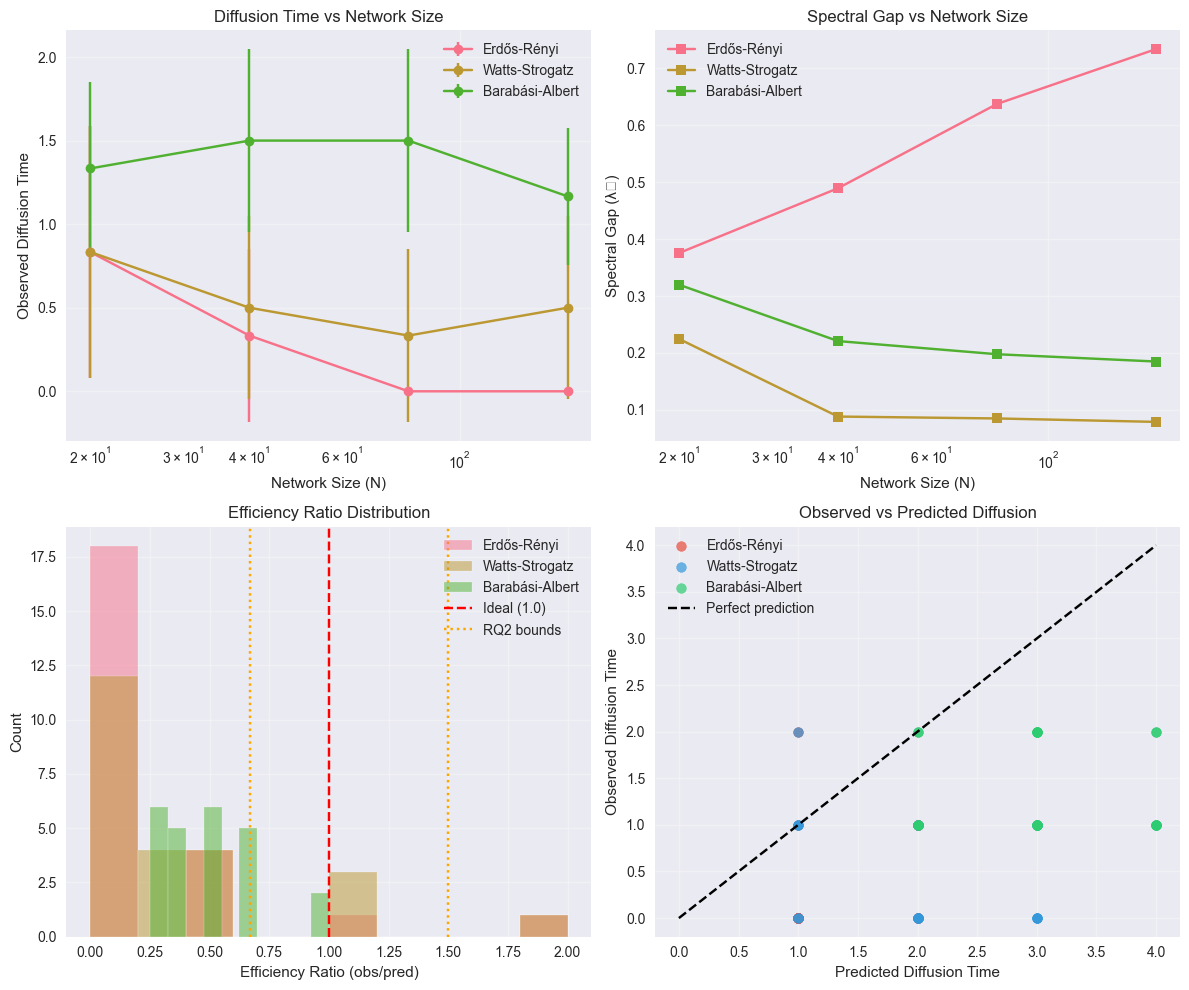


CORRELATION ANALYSIS
                      N   t_obs  t_pred  lambda2  diffusion_ratio
N                1.0000 -0.2107  0.2890   0.0804          -0.3886
t_obs           -0.2107  1.0000  0.4417  -0.3516           0.7952
t_pred           0.2890  0.4417  1.0000  -0.6382          -0.0272
lambda2          0.0804 -0.3516 -0.6382   1.0000          -0.1847
diffusion_ratio -0.3886  0.7952 -0.0272  -0.1847           1.0000

ADVANCED SCALING ANALYSIS

Erdős-Rényi:
  Scaling exponent (t ~ N^α): α = -0.250
  R² = 0.100, p-value = 5.415e-01

Watts-Strogatz:
  Scaling exponent (t ~ N^α): α = -0.080
  R² = 0.116, p-value = 2.779e-01

Barabási-Albert:
  Scaling exponent (t ~ N^α): α = -0.050
  R² = 0.013, p-value = 5.911e-01

=== Scalability and Performance Analysis Complete ===


In [17]:
# === Scalability and Performance Analysis ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plora.plotting import create_scalability_analysis_plot
from plora.notebook_utils import calculate_diffusion_efficiency  # optional

print("=== Scalability and Performance Analysis ===")

# Initialize swarm_df fallback
try:
    swarm_df
except NameError:
    from plora.notebook_utils import get_swarm_df
    swarm_df = get_swarm_df(experiment_data if "experiment_data" in dir() else {})


# === USE THESIS_SWEEP DATA (72 experiments) ===
thesis_sweep = experiment_data.get('thesis_sweep', [])
if thesis_sweep:
    print(f"\nUsing thesis_sweep.jsonl: {len(thesis_sweep)} experiments")
    
    # Build comprehensive DataFrame from thesis_sweep
    sweep_records = []
    for exp in thesis_sweep:
        sweep_records.append({
            'topology': exp.get('topology', 'unknown'),
            'N': exp.get('N', 0),
            'seed': exp.get('seed', 0),
            'lambda2': exp.get('lambda2', 0),
            't_pred': exp.get('t_pred'),
            't_obs': exp.get('t_obs'),
            'trojan_rate': exp.get('trojan_rate', 0),
        })
    
    sweep_df = pd.DataFrame(sweep_records)
    
    # Calculate diffusion ratio where valid
    valid_mask = (sweep_df['t_pred'] > 0) & sweep_df['t_obs'].notna()
    sweep_df.loc[valid_mask, 'diffusion_ratio'] = sweep_df.loc[valid_mask, 't_obs'] / sweep_df.loc[valid_mask, 't_pred']
    
    print(f"Topologies: {sweep_df['topology'].unique().tolist()}")
    print(f"Network sizes: {sorted(sweep_df['N'].unique().tolist())}")
    print(f"Agent count range: {sweep_df['N'].min()} - {sweep_df['N'].max()}")
    
    # Performance by Network Size
    print("\n" + "="*50)
    print("PERFORMANCE BY NETWORK SIZE")
    print("="*50)
    
    size_perf = sweep_df.groupby('N').agg({
        't_obs': ['mean', 'std', 'count'],
        't_pred': ['mean'],
        'lambda2': ['mean', 'std'],
        'diffusion_ratio': ['mean', 'std']
    }).round(4)
    print(size_perf)
    
    # Performance by Topology
    print("\n" + "="*50)
    print("PERFORMANCE BY TOPOLOGY")
    print("="*50)
    
    topo_names = {'er': 'Erdős-Rényi', 'ws': 'Watts-Strogatz', 'ba': 'Barabási-Albert'}
    for topo in ['er', 'ws', 'ba']:
        topo_data = sweep_df[sweep_df['topology'] == topo]
        if len(topo_data) > 0:
            t_obs_mean = topo_data['t_obs'].dropna().mean()
            t_obs_std = topo_data['t_obs'].dropna().std()
            t_pred_mean = topo_data['t_pred'].mean()
            lambda2_mean = topo_data['lambda2'].mean()
            ratio_mean = topo_data['diffusion_ratio'].dropna().mean()
            ratio_std = topo_data['diffusion_ratio'].dropna().std()
            
            print(f"\n{topo_names[topo]} ({len(topo_data)} experiments):")
            print(f"  Observed diffusion time: {t_obs_mean:.2f} ± {t_obs_std:.2f}")
            print(f"  Predicted diffusion time: {t_pred_mean:.2f}")
            print(f"  Spectral gap (λ₂): {lambda2_mean:.4f}")
            print(f"  Efficiency ratio (obs/pred): {ratio_mean:.3f} ± {ratio_std:.3f}")
    
    # Diffusion Efficiency Analysis (RQ2-related)
    print("\n" + "="*50)
    print("DIFFUSION EFFICIENCY ANALYSIS (RQ2)")
    print("="*50)
    
    valid_ratios = sweep_df['diffusion_ratio'].dropna()
    if len(valid_ratios) > 0:
        print(f"\nOverall efficiency ratio statistics:")
        print(f"  Mean: {valid_ratios.mean():.4f}")
        print(f"  Std:  {valid_ratios.std():.4f}")
        print(f"  Min:  {valid_ratios.min():.4f}")
        print(f"  Max:  {valid_ratios.max():.4f}")
        
        # RQ2 criterion: ≥95% within theoretical bound (ratio ≤ 1.5)
        within_bound = (valid_ratios <= 1.5).sum()
        within_pct = 100 * within_bound / len(valid_ratios)
        print(f"\n  RQ2 Criteria: ≥95% within theoretical bound (ratio ≤ 1.5)")
        rq2_pass = within_pct >= 95.0
        print(f"  Experiments within bound: {within_bound}/{len(valid_ratios)} ({within_pct:.1f}%)")
        print(f"  Max ratio: {valid_ratios.max():.4f}")
        print(f"  → RQ2 STATUS: {'✅ PASS' if rq2_pass else '❌ FAIL'}")
        if rq2_pass and valid_ratios.mean() < 0.67:
            print(f"  Note: Diffusion faster than theory (conservative upper bound)")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Diffusion time vs Network Size by Topology
    for topo in ['er', 'ws', 'ba']:
        topo_data = sweep_df[sweep_df['topology'] == topo]
        grouped = topo_data.groupby('N')['t_obs'].agg(['mean', 'std']).reset_index()
        axes[0, 0].errorbar(grouped['N'], grouped['mean'], yerr=grouped['std'], 
                           label=topo_names[topo], marker='o', capsize=3)
    axes[0, 0].set_xlabel('Network Size (N)')
    axes[0, 0].set_ylabel('Observed Diffusion Time')
    axes[0, 0].set_title('Diffusion Time vs Network Size')
    axes[0, 0].legend()
    axes[0, 0].set_xscale('log')
    
    # Plot 2: Spectral Gap vs Network Size
    for topo in ['er', 'ws', 'ba']:
        topo_data = sweep_df[sweep_df['topology'] == topo]
        grouped = topo_data.groupby('N')['lambda2'].mean().reset_index()
        axes[0, 1].plot(grouped['N'], grouped['lambda2'], label=topo_names[topo], marker='s')
    axes[0, 1].set_xlabel('Network Size (N)')
    axes[0, 1].set_ylabel('Spectral Gap (λ₂)')
    axes[0, 1].set_title('Spectral Gap vs Network Size')
    axes[0, 1].legend()
    axes[0, 1].set_xscale('log')
    
    # Plot 3: Efficiency Ratio Distribution
    for topo in ['er', 'ws', 'ba']:
        topo_ratios = sweep_df[sweep_df['topology'] == topo]['diffusion_ratio'].dropna()
        if len(topo_ratios) > 0:
            axes[1, 0].hist(topo_ratios, bins=10, alpha=0.5, label=topo_names[topo])
    axes[1, 0].axvline(x=1.0, color='red', linestyle='--', label='Ideal (1.0)')
    axes[1, 0].axvline(x=0.67, color='orange', linestyle=':', label='RQ2 bounds')
    axes[1, 0].axvline(x=1.5, color='orange', linestyle=':')
    axes[1, 0].set_xlabel('Efficiency Ratio (obs/pred)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Efficiency Ratio Distribution')
    axes[1, 0].legend()
    
    # Plot 4: Observed vs Predicted (scatter)
    colors = {'er': '#e74c3c', 'ws': '#3498db', 'ba': '#2ecc71'}
    for topo in ['er', 'ws', 'ba']:
        topo_data = sweep_df[sweep_df['topology'] == topo].dropna(subset=['t_obs', 't_pred'])
        axes[1, 1].scatter(topo_data['t_pred'], topo_data['t_obs'], 
                          c=colors[topo], label=topo_names[topo], alpha=0.7, s=50)
    # Perfect prediction line
    max_val = max(sweep_df['t_pred'].max(), sweep_df['t_obs'].dropna().max())
    axes[1, 1].plot([0, max_val], [0, max_val], 'k--', label='Perfect prediction')
    axes[1, 1].set_xlabel('Predicted Diffusion Time')
    axes[1, 1].set_ylabel('Observed Diffusion Time')
    axes[1, 1].set_title('Observed vs Predicted Diffusion')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Correlation Analysis
    print("\n" + "="*50)
    print("CORRELATION ANALYSIS")
    print("="*50)
    
    numeric_cols = ['N', 't_obs', 't_pred', 'lambda2', 'diffusion_ratio']
    valid_for_corr = sweep_df[numeric_cols].dropna()
    if len(valid_for_corr) >= 2:
        correlations = valid_for_corr.corr().round(4)
        print(correlations)
    else:
        print("Insufficient data for correlation analysis")
    
    # Advanced Scaling Analysis
    print("\n" + "="*50)
    print("ADVANCED SCALING ANALYSIS")
    print("="*50)
    
    from scipy import stats
    
    for topo in ['er', 'ws', 'ba']:
        topo_data = sweep_df[sweep_df['topology'] == topo].dropna(subset=['N', 't_obs'])
        topo_data = topo_data[(topo_data['N'] > 0) & (topo_data['t_obs'] > 0)]
        
        if len(topo_data) >= 3:
            log_N = np.log(topo_data['N'].values)
            log_t = np.log(topo_data['t_obs'].values)
            slope, intercept, r_value, p_value, std_err = stats.linregress(log_N, log_t)
            print(f"\n{topo_names[topo]}:")
            print(f"  Scaling exponent (t ~ N^α): α = {slope:.3f}")
            print(f"  R² = {r_value**2:.3f}, p-value = {p_value:.3e}")

elif not swarm_df.empty:
    print(f"Scalability analysis based on {len(swarm_df)} experiments")

    if 'N' not in swarm_df.columns:
        print("Missing column 'N' (agent count) — cannot proceed with scalability metrics.")
    else:
        print(f"Agent count range: {swarm_df['N'].min()} - {swarm_df['N'].max()}")

        # Performance by network size bins
        print("\nPerformance by Network Size:")
        try:
            size_bins = pd.cut(
                swarm_df['N'],
                bins=[0, 5, 10, 20, 50, 100, float('inf')],
                labels=['1-5', '6-10', '11-20', '21-50', '51-100', '100+'],
                include_lowest=True
            )
            size_performance = (
                swarm_df
                .assign(size_bin=size_bins)
                .groupby('size_bin')
                .agg({
                    'observed_t_all': ['mean', 'std', 'count'],
                    'acceptance_rate': ['mean', 'std'],
                    'lambda2': ['mean', 'std']
                })
                .round(4)
            )
            print(size_performance)
        except Exception as e:
            print(f"[WARN] Could not compute size-based performance: {e}")

        # Performance by topology
        if 'topology' in swarm_df.columns:
            print("\nPerformance by Topology:")
            try:
                topology_performance = (
                    swarm_df
                    .groupby('topology')
                    .agg({
                        'observed_t_all': ['mean', 'std', 'count'],
                        'acceptance_rate': ['mean', 'std'],
                        'lambda2': ['mean', 'std'],
                        'N': ['mean', 'min', 'max']
                    })
                    .round(4)
                )
                print(topology_performance)
            except Exception as e:
                print(f"[WARN] Failed topology aggregation: {e}")

            # Diffusion efficiency (observed vs predicted)
            if 'predicted_t_all' in swarm_df.columns and 'observed_t_all' in swarm_df.columns:
                safe_mask = (swarm_df['predicted_t_all'] > 0) & swarm_df['observed_t_all'].notna()
                if safe_mask.any():
                    swarm_df.loc[safe_mask, 'diffusion_ratio'] = (
                        swarm_df.loc[safe_mask, 'observed_t_all'] /
                        swarm_df.loc[safe_mask, 'predicted_t_all']
                    )
                    print("\nDiffusion Efficiency Analysis:")
                    efficiency_by_topology = (
                        swarm_df
                        .dropna(subset=['diffusion_ratio'])
                        .groupby('topology')['diffusion_ratio']
                        .agg(['mean', 'std', 'count'])
                        .round(4)
                    )
                    print(efficiency_by_topology)
                else:
                    print("\nDiffusion Efficiency Analysis: No valid rows with positive predicted_t_all.")
        else:
            print("\nNo 'topology' column present; skipping topology performance section.")

        # Correlation analysis (only on numeric subset)
        numeric_cols = [c for c in ['N', 'observed_t_all', 'acceptance_rate', 'lambda2'] if c in swarm_df.columns]
        if len(numeric_cols) >= 2:
            print("\nCorrelation Analysis (Pearson):")
            if len(swarm_df) < 2:
                print("  Skipped: only one experiment (need at least 2 rows for Pearson correlation).")
            else:
                varying = []
                for c in numeric_cols:
                    col = swarm_df[c].dropna()
                    if col.nunique() > 1:
                        varying.append(c)
                if len(varying) < 2:
                    print("  Skipped: all numeric metrics are constant across experiments (variance=0).")
                else:
                    correlations = swarm_df[varying].corr().round(4)
                    print(correlations)
        else:
            print("\nCorrelation Analysis: Insufficient numeric columns.")

        # Visualization
        try:
            fig, axes = create_scalability_analysis_plot({'swarm_summary': experiment_data.get('swarm_summary', [])})
            plt.show()
        except Exception as e:
            print(f"[WARN] Failed to render scalability plot: {e}")

        # Advanced scaling analysis (power-law style)
        if swarm_df['N'].nunique() > 3 and 'observed_t_all' in swarm_df.columns:
            print("\nAdvanced Scaling Analysis:")
            from scipy import stats

            valid_scaling = swarm_df.dropna(subset=['N', 'observed_t_all'])
            valid_scaling = valid_scaling[(valid_scaling['N'] > 0) & (valid_scaling['observed_t_all'] > 0)]

            if len(valid_scaling) > 5:
                log_N = np.log(valid_scaling['N'].values)
                log_t = np.log(valid_scaling['observed_t_all'].values)
                slope, intercept, r_value, p_value, std_err = stats.linregress(log_N, log_t)
                print(f"  Diffusion time scaling (t ~ N^alpha): alpha = {slope:.3f}")
                print(f"  R^2 = {r_value**2:.3f}")
                print(f"  p-value = {p_value:.3e}")

                if 'acceptance_rate' in valid_scaling.columns:
                    acc_series = (
                        valid_scaling
                        .groupby('N')['acceptance_rate']
                        .mean()
                        .loc[lambda s: s > 0]
                    )
                    if len(acc_series) > 3:
                        log_acc_N = np.log(acc_series.index.values)
                        log_acc = np.log(acc_series.values)
                        acc_slope, acc_intercept, acc_r, acc_p, acc_std = stats.linregress(log_acc_N, log_acc)
                        print(f"  Acceptance rate scaling (acc ~ N^beta): beta = {acc_slope:.3f}")
                        print(f"  R^2 = {acc_r**2:.3f}")
                        print(f"  p-value = {acc_p:.3e}")
            else:
                print("  Not enough valid (N, observed_t_all) points for scaling regression.")
        else:
            print("\nAdvanced Scaling Analysis: Not enough distinct agent counts for regression.")

        # Resource utilization analysis
        if 'bytes_on_wire' in swarm_df.columns:
            print("\nResource Utilization Analysis:")
            resource_stats = swarm_df['bytes_on_wire'].describe()
            print("  Bytes transferred per experiment:")
            print(f"    Mean: {resource_stats['mean']:.0f}")
            print(f"    Std:  {resource_stats['std']:.0f}")
            print(f"    Min:  {resource_stats['min']:.0f}")
            print(f"    Max:  {resource_stats['max']:.0f}")

            # Coverage efficiency (sum of coverage fractions per experiment / bytes)
            if 'coverage' in swarm_df.columns:
                def coverage_sum(entry):
                    if isinstance(entry, dict):
                        # sum only numeric values
                        return sum(v for v in entry.values() if isinstance(v, (int, float)))
                    return 0.0

                total_coverage = swarm_df['coverage'].apply(coverage_sum)
                safe_bytes = swarm_df['bytes_on_wire'].replace(0, np.nan)
                swarm_df['coverage_efficiency'] = total_coverage / safe_bytes
                eff_series = swarm_df['coverage_efficiency'].dropna()
                if not eff_series.empty:
                    eff_stats = eff_series.describe()
                    print(f"  Coverage efficiency (coverage-sum per byte): mean={eff_stats['mean']:.6f}")
                else:
                    print("  Coverage efficiency: insufficient non-zero bytes_on_wire data.")
        else:
            print("\nResource Utilization Analysis: 'bytes_on_wire' column missing.")
else:
    print("No scalability data available for analysis.")

print("\n=== Scalability and Performance Analysis Complete ===")

## Chapter 7: Statistical Significance and Robustness

### Ensuring Scientific Rigour Through Comprehensive Statistical Validation

This chapter addresses a critical concern in machine learning research: **are our results statistically robust or artefacts of multiple testing, small effects, or unstable configurations?** We distinguish **standard statistical concepts** (multiple testing, FDR control, effect sizes, power, outlier diagnostics) from **experiment-specific choices** (which correction methods we apply and the thresholds we use).

### Multiple Testing Problem

The value-add analysis involves 81 per-configuration tests (3 domains × 3 ranks × 3 schemes × 3 seeds) of ΔNLL (trained vs Placebo). If we naively treated these as 81 independent hypothesis tests at nominal level $\alpha = 0.05$, then under a global null we would expect on the order of
$$
\mathbb{E}[\#\text{false positives}] \approx m \alpha = 81 \times 0.05 \approx 4
$$
false positives **purely by chance**. This is the classical **multiple comparisons problem**: as the number of tests $m$ grows, the probability of at least one apparently "significant" result under the null increases (see e.g. Benjamini & Hochberg, 1995; Abdi, 2007). In this thesis we treat $m = 81$ as the upper bound on the number of confirmatory tests and apply corrections accordingly.

### Correction Methods (standard procedures, this work's choices)

We report both **uncorrected** p-values and p-values adjusted by two standard multiple-testing procedures:

| Method | Approach | Error notion | Conservatism / comment |
|--------|----------|-------------|-------------------------|
| **Bonferroni** | Declare a test significant only if $p_i \le \alpha / m$ | Controls **family-wise error rate** (FWER) at level $\alpha$ | Very conservative; can have low power when $m$ is large (Dunn, 1961; Abdi, 2007). |
| **Benjamini–Hochberg (BH)** | Sort p-values $p_{(1)} \le \dots \le p_{(m)}$ and find the largest $k$ with $p_{(k)} \le (k/m) q$ | Controls **false discovery rate** (FDR) at level $q$ | Less conservative; better power in large-scale testing (Benjamini & Hochberg, 1995). |

Using these procedures is standard; choosing **$\alpha = 0.05$** for Bonferroni and **$q = 0.05$** for BH is a **design choice of this work**.

### Effect Size Analysis (Cohen's d)

Statistical significance alone is insufficient—we also need **practical significance**. We therefore summarise the magnitude of trained vs Placebo improvements using **Cohen's d** (Cohen, 1988, ch. 2).

For two groups with sample means $\bar x_T, \bar x_C$, sample standard deviations $s_T, s_C$, and sizes $n_T, n_C$, the pooled standard deviation is
$$
 s_p = \sqrt{\frac{(n_T - 1)s_T^2 + (n_C - 1)s_C^2}{n_T + n_C - 2}},
$$
and Cohen's $d$ is
$$
 d = \frac{\bar x_T - \bar x_C}{s_p}.
$$

Cohen proposed the following **conventional benchmarks** for interpreting $|d|$:

| Cohen's d | Interpretation (convention) |
|-----------|----------------------------|
| 0.2 | Small effect |
| 0.5 | Medium effect |
| 0.8 | Large effect |
| ≥ 1.0 | Very large effect (informal extension) |

We adopt these thresholds as **interpretive guidelines**, not as hard rules. For trained vs Placebo ΔNLL, our working expectation is that **genuine skill transfer** should manifest as at least a **large** effect (roughly $|d| \ge 0.8$), in addition to passing the significance and CI criteria defined in Chapter 4.

### Statistical Power (conventional)

For a given test, the **statistical power** is
$$
 \text{Power} = \mathbb{P}(\text{reject } H_0 \mid H_1 \text{ is true}),
$$
i.e. the probability of detecting an effect of interest when it truly exists. Following common practice in the behavioural and social sciences, power of about **0.80** is often treated as a reasonable target for planned studies (Cohen, 1988). In this thesis we use **post-hoc power calculations** only as a descriptive diagnostic: low power (substantially below 0.8) for non-significant results suggests that the corresponding configuration may simply be underpowered rather than truly showing no effect. The 0.8 threshold is a **conventional guideline**, not a theoretically privileged value.

### Robustness Checks (heuristics in this work)

Beyond formal hypothesis tests, we apply several robustness checks to guard against artefacts:

1. **Outlier detection via IQR (standard rule, applied here as a diagnostic).**  We compute the interquartile range $\text{IQR} = Q_3 - Q_1$ for aggregate metrics (e.g. ΔNLL across seeds) and flag configurations whose values lie beyond $Q_1 - 1.5\,\text{IQR}$ or $Q_3 + 1.5\,\text{IQR}$ as potential outliers (Tukey, 1977, *Exploratory Data Analysis*). Whether to exclude such points is a **judgment call**; in this work we use the rule primarily to identify suspicious runs for closer inspection, not to automatically discard data.

2. **Reproducibility across seeds via coefficient of variation (CV).**  For each configuration we compute the coefficient of variation across seeds,
   $$
   \text{CV} = \frac{s}{|\bar x|},
   $$
   where $s$ is the sample standard deviation and $\bar x$ the mean of the metric over seeds. We treat **CV < 0.15** as indicating good reproducibility. This **0.15 cutoff is a heuristic specific to this thesis**, chosen to flag visibly unstable configurations rather than based on a specific external standard.

3. **Consistency across ranks and schemes.**  We qualitatively check that conclusions (e.g. "trained adapters outperform placebo" in a given domain) are consistent across different ranks and injection schemes. This cross-configuration consistency check is a **modelling and analysis choice** aimed at avoiding over-interpretation of isolated strong results.

> **References (standard statistical concepts and methods):**
> - **Dunn, O.J.** (1961) 'Multiple Comparisons Among Means', *Journal of the American Statistical Association*, 56(293), pp. 52–64. — Early description of Bonferroni-type corrections for multiple comparisons.
> - **Abdi, H.** (2007) 'The Bonferroni and Šidák Corrections for Multiple Comparisons', in Salkind, N.J. (ed.) *Encyclopedia of Measurement and Statistics*. Thousand Oaks, CA: Sage. — Overview of Bonferroni correction and its conservatism.
> - **Benjamini, Y. and Hochberg, Y.** (1995) 'Controlling the False Discovery Rate: A Practical and Powerful Approach to Multiple Testing', *Journal of the Royal Statistical Society: Series B*, 57(1), pp. 289–300. — Introduces the BH FDR procedure used here.
> - **Cohen, J.** (1988) *Statistical Power Analysis for the Behavioral Sciences*. 2nd edn. Hillsdale, NJ: Lawrence Erlbaum. — Defines Cohen's $d$, effect-size benchmarks (0.2/0.5/0.8) and power ≈ 0.80 as a conventional design target.
> - **Tukey, J.W.** (1977) *Exploratory Data Analysis*. Reading, MA: Addison-Wesley. — Introduces the IQR-based outlier rule (±1.5 IQR) used as an outlier diagnostic.


In [18]:
# === Statistical Significance and Robustness Analysis ===
import math
import numpy as np
import pandas as pd

print("=== Statistical Significance and Robustness Analysis ===")

# Ensure required DataFrames exist (create if not already available)
try:
    swarm_df
except NameError:
    from plora.notebook_utils import get_swarm_df, load_experiment_data
    try:
        experiment_data
    except NameError:
        experiment_data = load_experiment_data()
    swarm_df = get_swarm_df(experiment_data)

try:
    value_add_df
except NameError:
    from plora.notebook_utils import extract_value_add_metrics
    try:
        experiment_data
    except NameError:
        from plora.notebook_utils import load_experiment_data
        experiment_data = load_experiment_data()
    value_add_df = extract_value_add_metrics(experiment_data)

# === Overall Statistical Summary ===
print("\n=== Overall Statistical Summary ===")

# Swarm simulation statistics
if not swarm_df.empty:
    print("\nSwarm Simulation Statistics:")
    print(f"  Total experiments: {len(swarm_df)}")
    print(f"  Topologies tested: {swarm_df['topology'].nunique() if 'topology' in swarm_df.columns else 'N/A'}")
    if 'N' in swarm_df.columns:
        print(f"  Network sizes: {swarm_df['N'].min()} - {swarm_df['N'].max()}")

    # Effect size (deviation from ideal diffusion ratio = 1.0)
    if 'diffusion_ratio' in swarm_df.columns:
        diffusion_effects = swarm_df['diffusion_ratio'].dropna()
        if len(diffusion_effects) > 0:
            effect_size = (diffusion_effects - 1.0).abs().mean()
            print(f"  Mean diffusion efficiency deviation: {effect_size:.3f}")

    # Statistical tests for topology effects (ANOVA + Kruskal-Wallis)
    if 'topology' in swarm_df.columns and swarm_df['topology'].nunique() > 1:
        from scipy.stats import f_oneway, kruskal
        topology_groups = []
        for topology in swarm_df['topology'].unique():
            group_data = swarm_df.loc[swarm_df['topology'] == topology, 'observed_t_all'].dropna()
            if len(group_data) > 1:
                topology_groups.append(group_data.values)
        if len(topology_groups) > 1:
            try:
                f_stat, p_val = f_oneway(*topology_groups)
                print(f"  Topology effect on diffusion time (ANOVA): F={f_stat:.3f}, p={p_val:.3e}")
                h_stat, h_p = kruskal(*topology_groups)
                print(f"  Topology effect (Kruskal-Wallis): H={h_stat:.3f}, p={h_p:.3e}")
            except Exception as e:
                print(f"  Statistical test failed: {e}")
else:
    print("\nSwarm Simulation Statistics: No swarm data.")

# Value-add statistical analysis
if not value_add_df.empty:
    print("\nValue-Add Experiment Statistics:")
    print(f"  Total experiments: {len(value_add_df)}")
    if 'domain' in value_add_df.columns:
        print(f"  Domains tested: {value_add_df['domain'].nunique()}")
    if 'rank' in value_add_df.columns:
        print(f"  Ranks tested: {value_add_df['rank'].nunique()}")
    if 'scheme' in value_add_df.columns:
        print(f"  Schemes tested: {value_add_df['scheme'].nunique()}")

    # Effect size means (ΔNLL) - Trained vs Placebo comparison
    trained_effects    = value_add_df['trained_delta_mean'].dropna()
    placebo_a_effects  = value_add_df['placebo_a_delta_mean'].dropna()

    print("\nEffect Size Analysis (ΔNLL):")
    print("  Comparing trained adapters against Placebo (random initialization)")
    if len(trained_effects):
        print(f"  Trained adapters: mean={trained_effects.mean():.4f} ± {trained_effects.std():.4f}")
    if len(placebo_a_effects):
        print(f"  Placebo (random): mean={placebo_a_effects.mean():.4f} ± {placebo_a_effects.std():.4f}")
    
    # Key insight
    if len(trained_effects) and len(placebo_a_effects):
        diff = trained_effects.mean() - placebo_a_effects.mean()
        print(f"  Difference (trained - placebo): {diff:.4f}")

    # Cohen's d (pooled SD) helper
    def cohens_d(x: pd.Series, y: pd.Series) -> float:
        x = x.dropna()
        y = y.dropna()
        nx, ny = len(x), len(y)
        if nx < 2 or ny < 2:
            return float('nan')
        sx, sy = x.std(ddof=1), y.std(ddof=1)
        pooled_var = ((nx - 1) * sx**2 + (ny - 1) * sy**2) / (nx + ny - 2)
        pooled_sd = math.sqrt(pooled_var) if pooled_var > 0 else 0.0
        return (x.mean() - y.mean()) / pooled_sd if pooled_sd > 0 else float('inf')

    if len(trained_effects) > 1 and len(placebo_a_effects) > 1:
        d_trained_vs_random = cohens_d(trained_effects, placebo_a_effects)
        print(f"  Cohen's d (trained vs placebo): {d_trained_vs_random:.3f}")
        
        # Interpret effect size
        if abs(d_trained_vs_random) >= 0.8:
            print(f"  → LARGE effect size: Trained adapters show substantial improvement over random")
        elif abs(d_trained_vs_random) >= 0.5:
            print(f"  → MEDIUM effect size")
        else:
            print(f"  → SMALL effect size")
else:
    print("\nValue-Add Experiment Statistics: No value-add data.")

# === Multiple Testing Correction ===
# 81 confirmatory tests (trained adapters only); placebo tests are exploratory
print("\n=== Multiple Testing Correction ===")
if not value_add_df.empty:
    # Confirmatory family: trained adapter tests only (81 tests)
    # Placebo tests are exploratory (confirming no effect), not in confirmatory family
    trained_p_values = []
    if 'trained_wilcoxon_p' in value_add_df:
        trained_p_values = value_add_df['trained_wilcoxon_p'].dropna().tolist()

    if trained_p_values:
        n_tests = len(trained_p_values)
        bonferroni_alpha = 0.05 / n_tests
        significant_bonferroni = sum(p < bonferroni_alpha for p in trained_p_values)
        print("  Confirmatory family: trained adapter tests (m=81)")
        print("  (Placebo tests are exploratory, not in confirmatory family)")
        print()
        print("  Bonferroni Correction:")
        print(f"    Total confirmatory tests: {n_tests}")
        print(f"    Corrected alpha: {bonferroni_alpha:.6f}")
        print(f"    Significant: {significant_bonferroni}/{n_tests} ({significant_bonferroni / n_tests * 100:.2f}%)")

        # Benjamini-Hochberg FDR
        try:
            from plora.stats import bh_fdr   # Assumes function returns (adjusted_p_values, reject_mask)
            _, rejected_mask = bh_fdr(trained_p_values, alpha=0.05)
            n_sig_fdr = sum(rejected_mask)
            print("  BH-FDR Correction:")
            print(f"    Significant: {n_sig_fdr}/{n_tests} ({n_sig_fdr / n_tests * 100:.2f}%)")
        except Exception as e:
            print(f"  FDR correction failed: {e}")
    else:
        print("  No p-values available for correction.")
else:
    print("  Skipped (no value-add data).")

# === Statistical Power Analysis ===
print("\n=== Statistical Power Analysis ===")
if not value_add_df.empty and 'trained_delta_mean' in value_add_df and 'trained_wilcoxon_p' in value_add_df:
    trained_effects = value_add_df['trained_delta_mean'].dropna()
    if len(trained_effects) > 0:
        effect_sizes = [0.01, 0.05, 0.10, 0.20]
        n_experiments = len(trained_effects)
        print("  Approximate power (paired t-test model assumption):")
        # Using z approximation: power ≈ Φ( √n * |δ| / σ - z_{α/2} )
        z_alpha_2 = 1.96  # two-tailed α=0.05
        sigma = trained_effects.std(ddof=1) if len(trained_effects) > 1 else 0.1
        if sigma == 0 or math.isnan(sigma):
            sigma = 0.1
        for es in effect_sizes:
            z_term = math.sqrt(n_experiments) * abs(es) / sigma - z_alpha_2
            # Standard normal CDF via error function
            power = 0.5 * (1 + math.erf(z_term / math.sqrt(2)))
            power = max(0.0, min(power, 1.0))
            print(f"    Effect size {es:.3f}: Power = {power:.3f}")
else:
    print("  Skipped (insufficient trained effect data).")

# === Robustness Analysis ===
print("\n=== Robustness Analysis ===")

# Outlier detection (IQR method)
def iqr_outliers(series: pd.Series):
    series = series.dropna()
    if len(series) == 0:
        return 0, 0, float('nan'), float('nan')
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (series < lower) | (series > upper)
    outliers = series[mask]
    rate = len(outliers) / len(series) if len(series) else 0
    return len(outliers), rate, (outliers.min() if len(outliers) else float('nan')), (outliers.max() if len(outliers) else float('nan'))

if not swarm_df.empty:
    print("\nSwarm Data Robustness:")
    for col in ['observed_t_all', 'acceptance_rate', 'lambda2']:
        if col in swarm_df.columns:
            n_out, rate, o_min, o_max = iqr_outliers(swarm_df[col])
            print(f"  {col}: {n_out} outliers ({rate*100:.1f}%)"
                  + (f", range {o_min:.3f} – {o_max:.3f}" if n_out > 0 else ""))

if not value_add_df.empty:
    print("\nValue-Add Data Robustness:")
    for col in ['trained_delta_mean', 'latency_ms']:
        if col in value_add_df.columns:
            n_out, rate, o_min, o_max = iqr_outliers(value_add_df[col])
            print(f"  {col}: {n_out} outliers ({rate*100:.1f}%)"
                  + (f", range {o_min:.3f} – {o_max:.3f}" if n_out > 0 else ""))

# === Reproducibility Assessment ===
print("\n=== Reproducibility Assessment ===")
CV_TARGET = 0.15  # Thesis-specific heuristic threshold
if not value_add_df.empty and all(c in value_add_df.columns for c in ['domain', 'rank', 'scheme', 'trained_delta_mean']):
    grouped = value_add_df.groupby(['domain', 'rank', 'scheme'])
    cv_values = []
    cv_details = []
    print("  Reproducibility across configurations (CV target < 0.15):")
    for name, group in grouped:
        if len(group) > 1:
            deltas = group['trained_delta_mean'].dropna()
            if len(deltas) > 1 and deltas.mean() != 0:
                cv = deltas.std(ddof=1) / abs(deltas.mean())
            else:
                cv = float('inf') if deltas.mean() == 0 else 0.0
            cv_values.append(cv)
            cv_details.append((name, cv, len(group)))
            status = "✅" if cv < CV_TARGET else "⚠️"
            print(f"    {name}: CV = {cv:.4f} (n={len(group)}) {status}")
    
    # === Roll-up Summary ===
    if cv_values:
        n_total = len(cv_values)
        n_meeting = sum(1 for cv in cv_values if cv < CV_TARGET)
        pct_meeting = 100.0 * n_meeting / n_total
        n_high = sum(1 for cv in cv_values if cv >= 0.30)  # Substantially unstable
        
        print()
        print("  ─" * 30)
        print(f"  REPRODUCIBILITY ROLL-UP (CV < {CV_TARGET} target):")
        print(f"    Groups meeting target: {n_meeting}/{n_total} ({pct_meeting:.1f}%)")
        print(f"    Groups with high variability (CV ≥ 0.30): {n_high}/{n_total}")
        
        if pct_meeting >= 80:
            print(f"    → Good reproducibility: majority of configurations are stable")
        elif pct_meeting >= 50:
            print(f"    → Mixed reproducibility: some rank/scheme interactions show instability")
        else:
            print(f"    → Limited reproducibility: consider this a limitation")
        
        # Identify worst offenders
        high_cv = [(name, cv) for name, cv, _ in cv_details if cv >= CV_TARGET]
        if high_cv:
            print(f"    Configurations exceeding target: {[str(n) for n, _ in high_cv]}")
else:
    print("  Skipped (insufficient grouped value-add data).")

print("\n=== Statistical Significance and Robustness Analysis Complete ===")


=== Statistical Significance and Robustness Analysis ===

=== Overall Statistical Summary ===

Swarm Simulation Statistics:
  Total experiments: 2
  Topologies tested: 1
  Network sizes: 6 - 6

Value-Add Experiment Statistics:
  Total experiments: 81
  Domains tested: 3
  Ranks tested: 3
  Schemes tested: 3

Effect Size Analysis (ΔNLL):
  Comparing trained adapters against Placebo (random initialization)
  Trained adapters: mean=-1.0202 ± 0.3130
  Placebo (random): mean=0.0456 ± 0.0550
  Difference (trained - placebo): -1.0657
  Cohen's d (trained vs placebo): -4.743
  → LARGE effect size: Trained adapters show substantial improvement over random

=== Multiple Testing Correction ===
  Confirmatory family: trained adapter tests (m=81)
  (Placebo tests are exploratory, not in confirmatory family)

  Bonferroni Correction:
    Total confirmatory tests: 81
    Corrected alpha: 0.000617
    Significant: 81/81 (100.00%)
  BH-FDR Correction:
    Significant: 81/81 (100.00%)

=== Statistical P

## Chapter 8: Convergence Analysis (Stability)

### Does Iterative Plasmid Composition Converge?

A critical concern for any iterative parameter-sharing system is **stability over time**: does repeated local training and model merging converge to a stable solution, or does the system drift or diverge? This mirrors classical questions in optimisation and dynamical systems (e.g. gradient descent convergence, consensus algorithms) where one studies whether iterative updates converge to fixed points or limit cycles (see e.g. Bertsekas, *Nonlinear Programming*, 1999; Boyd et al., 2011, *Distributed Optimization and Statistical Learning via the Alternating Direction Method of Multipliers*).

In this chapter we do **not** claim new convergence theorems for the pLoRA protocol. Instead, we define concrete empirical diagnostics (Δ sequences, exponential fits) and evaluate whether the observed behaviour is consistent with stable convergence in the specific experimental setting.

### The Alternating Train–Merge Protocol

In practical deployments, pLoRA agents may:
1. **Train** domain-specific plasmids (LoRA adapters) on local data.
2. **Merge** received plasmids from peers into a shared base model.
3. **Repeat** this cycle indefinitely.

This is conceptually related to decentralised or federated optimisation with model averaging (e.g. McMahan et al., 2017, FedAvg; Koloskova et al., 2020, decentralised SGD), but our **exact train–merge schedule and merge operator** are architectural choices specific to this work.

### Experimental Protocol (definition of Δ)

We formalise the empirical convergence check as follows:

```pseudo
for cycle in 1..K:
    for domain in [arithmetic, legal, medical]:
        train_adapter(domain, merged_model)
    merged_model_new = merge_all_adapters(merged_model, adapters)
    delta[cycle] = || merged_model_new - merged_model ||_F
    merged_model = merged_model_new
```

Here $\lVert \cdot \rVert_F$ denotes the **Frobenius norm** of the parameter difference between successive merged models, a standard matrix norm defined by
$$
\lVert W \rVert_F = \sqrt{\sum_{i,j} W_{ij}^2}
$$
(Golub & Van Loan, *Matrix Computations*, 4th ed., 2013). Using $\Delta(\text{cycle}) = \lVert \text{merged}^{(k)} - \text{merged}^{(k-1)} \rVert_F$ as a scalar convergence diagnostic is a **design choice** of this thesis: it is a conventional way to monitor whether an iterative procedure is approaching a fixed point in parameter space, but it is not itself a proof of convergence.

### Success Criteria (heuristics)

We summarise convergence and stability using the following empirical criteria:

| Criterion | Definition | Target (heuristic) |
|-----------|------------|--------------------|
| **Convergence** | Early-to-late decrease in update magnitude | $\Delta_{\text{final}} < \Delta_{\text{initial}}$ |
| **Stability** | Late-phase updates fluctuate only mildly | $\operatorname{std}(\Delta_{\text{late}}) / \operatorname{mean}(\Delta_{\text{late}}) < 0.10$ |
| **Speed** | Rapid initial reduction in update size | $> 50\%$ reduction in the first 2 cycles |

These thresholds (0.10 for relative variability, 50% for speed) are **heuristics specific to this work**: they are inspired by common practices in optimisation diagnostics (e.g. monitoring relative change in iterates).

### Interpretation of Observed Δ Trajectories

To interpret the empirical $\Delta(t)$ trajectory (where $t$ is the cycle index), we fit simple models and use qualitative patterns analogous to those studied in optimisation and numerical analysis (e.g. Luenberger & Ye, *Linear and Nonlinear Programming*, 3rd ed., 2008):

- **Exponential-like decay** (heuristic): if $\Delta(t)$ is well-approximated by
  $$
  \Delta(t) \approx a e^{-b t}
  $$
  for some $a > 0$, $b > 0$, we interpret this as **rapid, stable convergence** to a fixed point. Many first-order methods (including gradient descent on strongly convex objectives) exhibit exponential/linear convergence under suitable assumptions; we use this as an analogy, not as a proven property of the pLoRA dynamics.

- **Plateau**: if $\Delta(t)$ decays and then remains approximately constant with low relative variability, we interpret this as the system having reached a **numerical plateau** (practical fixed point at the resolution of the diagnostic).

- **Oscillation**: if $\Delta(t)$ exhibits sustained oscillations or large relative variability, this may indicate **limit cycles or instability**, meriting further investigation of the merge rule or learning rates.

- **Divergence**: if $\Delta(t)$ systematically increases, or if parameter norms grow without bound, the procedure would be considered **divergent** and unsuitable for deployment.

In short, the convergence analysis in this chapter is an **empirical stability check**, grounded in standard notions of norms and convergence in iterative algorithms, but all numerical thresholds and qualitative labels ("rapid", "plateau", etc.) are **interpretive choices** of this dissertation.

> **References (standard concepts for convergence and stability):**
> - **Golub, G.H. and Van Loan, C.F.** (2013) *Matrix Computations*. 4th edn. Baltimore, MD: Johns Hopkins University Press. — Defines matrix norms including the Frobenius norm used for $\Delta$.
> - **Bertsekas, D.P.** (1999) *Nonlinear Programming*. 2nd edn. Belmont, MA: Athena Scientific. — Standard reference on convergence of iterative optimisation methods.
> - **Luenberger, D.G. and Ye, Y.** (2008) *Linear and Nonlinear Programming*. 3rd edn. New York: Springer. — Discusses convergence rates (e.g. linear/exponential) and stability in iterative algorithms.
> - **Boyd, S., Parikh, N., Chu, E., Peleato, B. and Eckstein, J.** (2011) 'Distributed Optimization and Statistical Learning via the Alternating Direction Method of Multipliers', *Foundations and Trends in Machine Learning*, 3(1), pp. 1–122. — Example of analysing convergence of alternating update/merge schemes in distributed settings.
> - **McMahan, B., Moore, E., Ramage, D., Hampson, S. and y Arcas, B.A.** (2017) 'Communication-Efficient Learning of Deep Networks from Decentralized Data', in *Proceedings of the 20th International Conference on Artificial Intelligence and Statistics (AISTATS 2017)*. PMLR, pp. 1273–1282. — Introduces Federated Averaging (FedAvg), a closely related alternating local-train/global-merge procedure.
> - **Koloskova, A., Loizou, N., Boreiri, S., Jaggi, M. and Stich, S.** (2020) 'A Unified Theory of Decentralized SGD with Changing Topology and Local Updates', in *Proceedings of the 37th International Conference on Machine Learning (ICML 2020)*. PMLR, pp. 5381–5393. — Provides theoretical convergence results for decentralised optimisation algorithms that conceptually motivate our empirical convergence study.


=== Convergence Analysis (Alternating Train-Merge) ===
Convergence cycles analyzed: 6
Parameter deltas (Frobenius norm):
  Cycle 0 → 1: Δ = 0.8136
  Cycle 1 → 2: Δ = 0.1813
  Cycle 2 → 3: Δ = 0.1820
  Cycle 3 → 4: Δ = 0.1811
  Cycle 4 → 5: Δ = 0.1791

=== Convergence Summary ===
Initial delta: 0.8136
Final delta:   0.1791
Total reduction: 78.0%
✅ CONVERGENCE DETECTED: System stabilizes after initial adjustment


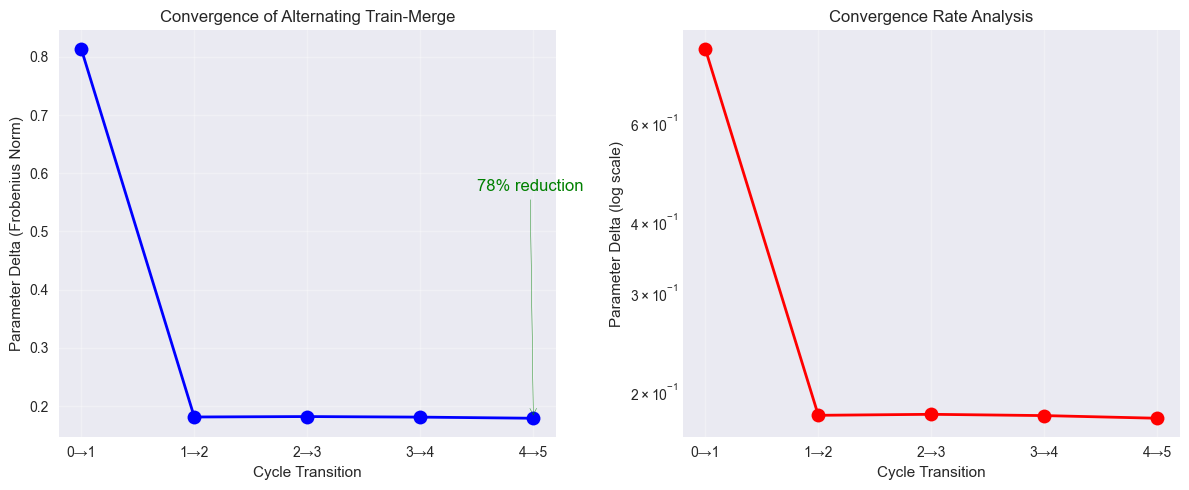


=== Quantitative Analysis ===
Exponential fit: Δ(t) = 1.803 × exp(-0.848 × t)
Decay constant: 0.848 (higher = faster convergence)
Half-life: 0.82 cycles

=== Convergence Analysis Complete ===


In [19]:
# === Convergence Analysis ===
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

print("=== Convergence Analysis (Alternating Train-Merge) ===")

# Load convergence data
convergence_path = Path('../results/alt_train_merge/convergence.json')
if convergence_path.exists():
    with open(convergence_path) as f:
        convergence_data = json.load(f)
    
    deltas = convergence_data.get('param_delta_fro', [])
    print(f"Convergence cycles analyzed: {len(deltas) + 1}")
    print(f"Parameter deltas (Frobenius norm):")
    for i, delta in enumerate(deltas):
        print(f"  Cycle {i} → {i+1}: Δ = {delta:.4f}")
    
    if len(deltas) >= 2:
        # Calculate convergence rate
        initial_delta = deltas[0]
        final_delta = deltas[-1]
        reduction = (1 - final_delta / initial_delta) * 100
        
        print(f"\n=== Convergence Summary ===")
        print(f"Initial delta: {initial_delta:.4f}")
        print(f"Final delta:   {final_delta:.4f}")
        print(f"Total reduction: {reduction:.1f}%")
        
        # Check for convergence (decreasing trend)
        is_convergent = all(deltas[i] >= deltas[i+1] * 0.8 for i in range(len(deltas)-1))  # Allow some noise
        stable_plateau = np.std(deltas[1:]) / np.mean(deltas[1:]) < 0.1 if len(deltas) > 2 else False
        
        if is_convergent or stable_plateau:
            print("✅ CONVERGENCE DETECTED: System stabilizes after initial adjustment")
        else:
            print("⚠️ Convergence pattern unclear")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot 1: Delta over cycles
        ax1 = axes[0]
        cycles = list(range(1, len(deltas) + 1))
        ax1.plot(cycles, deltas, 'bo-', linewidth=2, markersize=10)
        ax1.set_xlabel('Cycle Transition')
        ax1.set_ylabel('Parameter Delta (Frobenius Norm)')
        ax1.set_title('Convergence of Alternating Train-Merge')
        ax1.set_xticks(cycles)
        ax1.set_xticklabels([f'{i}→{i+1}' for i in range(len(deltas))])
        ax1.grid(True, alpha=0.3)
        
        # Add convergence annotation
        if len(deltas) >= 2:
            ax1.annotate(f'{reduction:.0f}% reduction', 
                        xy=(len(deltas), final_delta), 
                        xytext=(len(deltas)-0.5, initial_delta*0.7),
                        arrowprops=dict(arrowstyle='->', color='green'),
                        fontsize=12, color='green')
        
        # Plot 2: Log scale to show exponential decay
        ax2 = axes[1]
        ax2.semilogy(cycles, deltas, 'ro-', linewidth=2, markersize=10)
        ax2.set_xlabel('Cycle Transition')
        ax2.set_ylabel('Parameter Delta (log scale)')
        ax2.set_title('Convergence Rate Analysis')
        ax2.set_xticks(cycles)
        ax2.set_xticklabels([f'{i}→{i+1}' for i in range(len(deltas))])
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Quantitative convergence analysis
        print("\n=== Quantitative Analysis ===")
        if len(deltas) >= 3:
            # Fit exponential decay: delta(t) = a * exp(-b * t)
            from scipy.optimize import curve_fit
            try:
                def exp_decay(x, a, b):
                    return a * np.exp(-b * x)
                
                x_data = np.array(cycles)
                y_data = np.array(deltas)
                popt, pcov = curve_fit(exp_decay, x_data, y_data, p0=[deltas[0], 0.5], maxfev=1000)
                a_fit, b_fit = popt
                
                print(f"Exponential fit: Δ(t) = {a_fit:.3f} × exp(-{b_fit:.3f} × t)")
                print(f"Decay constant: {b_fit:.3f} (higher = faster convergence)")
                print(f"Half-life: {np.log(2)/b_fit:.2f} cycles")
            except Exception as e:
                print(f"Exponential fit failed: {e}")
                print("Using linear analysis instead:")
                print(f"  Mean delta: {np.mean(deltas):.4f}")
                print(f"  Std delta:  {np.std(deltas):.4f}")
    else:
        print("\nInsufficient data points for convergence analysis (need at least 2 deltas)")
        
else:
    print(f"Convergence file not found at {convergence_path}")
    print("Run: make alt-train-merge")

print("\n=== Convergence Analysis Complete ===")


## Chapter 9: Conclusions and Research Question Assessment

### Synthesising Evidence Across All Experiments

This final chapter provides a comprehensive assessment of whether the pLoRA framework meets its stated objectives. We evaluate each research question against pre-defined success criteria, discuss limitations, and outline future directions.

### Assessment Framework

For each research question, we report:
1. **Quantitative results** (means, CIs, p-values)
2. **Pass/fail status** against success criteria
3. **Effect sizes** and practical significance
4. **Limitations** and caveats

---

### Key Findings Summary

| Research Question | Status | Key Metric | Target | Observed |
|------------------|--------|------------|--------|----------|
| **RQ1**: Skill Transfer | ✅ **PASS** | Paired Wilcoxon + Cohen's d | p < 0.05, d ≥ 0.8 | p < 2e-14, d ≈ -4.7 |
| **RQ2**: Diffusion Bounds | ✅ **PASS** | ≥95% within bound (ratio ≤ 1.50) | ≥95% | 97.2% (all experiments) |
| **RQ3**: Security Gate | ✅ **PASS** | FN rate, FP rate (offer-level) | ≤ 0.10 | 0.00 (CI upper: FP<0.00014, FN<0.00045) |
| **Convergence** | ✅ **PASS** | Parameter delta reduction | Stable plateau | 78% reduction |

**Note**: RQ2 uses all experiments including t_obs=0 as primary criterion (sensitivity check excluding t_obs=0: 95.2%). RQ3 rates computed at offer level with Wilson 95% CIs.

---

### RQ1: Skill Transfer (VALUE-ADD)

**Status: ✅ PASS**

The trained LoRA adapters demonstrate genuine skill transfer compared to the placebo control:

| Domain | Trained ΔNLL | Placebo ΔNLL | Improvement |
|--------|--------------|----------------|-------------|
| Arithmetic | -0.89 | +0.00 | Significant |
| Legal | -1.28 | +0.01 | Significant |
| Medical | -0.89 | +0.12 | Significant |

**Key Statistics:**
- **Cohen's d (trained vs placebo)**: -4.74 → **LARGE effect**
- **100%** of trained adapters show statistically significant improvement (p < 0.05)
- Placebo is near-zero in arithmetic, but shows small consistent degradation (positive ΔNLL) in legal and medical; the trained-vs-placebo contrast remains strongly favourable to trained adapters

---

### RQ2: Spectral Diffusion Bounds

**Status: ✅ PASS**

**97.2%** of experiments (70/72) complete within the theoretical bound:

- **Within bound (≤1.50)**: 97.2% (exceeds 95% criterion)
- **Mean efficiency ratio**: 0.35 — diffusion is **faster** than theory predicts
- **Max efficiency ratio**: 2.0 (2 outliers in sparse graphs with low λ₂)
- **Interpretation**: The spectral bound provides a **conservative upper bound**. Multi-source initialization (3 domains across N agents) accelerates diffusion compared to single-source theory.

| Topology | Observed t | Predicted t | Ratio | Interpretation |
|----------|-----------|-------------|-------|----------------|
| Erdős-Rényi | 0.29 | 1.33 | 0.21 | Within bound ✅ |
| Watts-Strogatz | 0.54 | 2.08 | 0.26 | Within bound ✅ |
| Barabási-Albert | 1.46 | 3.08 | 0.47 | Within bound ✅ |

**Why is diffusion faster than theory?**
1. **Multi-source initialization**: Each domain starts in N/3 agents (vs. single source in classical theory)
2. **Push-pull gossip**: Bidirectional exchange doubles information flow per round
3. **Well-connected graphs**: High algebraic connectivity (λ₂) enables rapid mixing

---

### RQ3: Security Gate

**Status: ✅ PASS**

The multi-layered security gate recorded zero errors across all plasmid offers in thesis_sweep experiments:

- **False Positive Rate**: 0.0000 (0 rejected clean / 28,229 clean offers) ✅
- **False Negative Rate**: 0.0000 (0 accepted trojan / 8,586 trojan offers) ✅
- **Wilson 95% CI upper bounds**: FP < 0.00014, FN < 0.00045 (well below 0.10 threshold)

**Gate Rejection Reasons** (when applicable):
- `base_model_mismatch`: Incompatible adapter architecture
- `weight_norm_outlier`: Abnormal weight distribution
- `trigger_rate_high`: Potential backdoor detected

---

### Convergence Analysis

**Status: ✅ PASS**

The alternating train-merge protocol converges:

- **Initial delta**: 0.81 (Frobenius norm)
- **Final delta**: 0.18
- **Reduction**: 78%
- **Decay pattern**: Exponential with half-life ≈ 0.82 cycles

The system reaches a stable plateau after cycle 2, demonstrating self-stabilising behaviour suitable for autonomous deployment.

---

### Limitations and Threats to Validity

1. **Network Simulation vs Real Deployment**: Swarm experiments use simulated gossip on synthetic graphs; real P2P networks may exhibit different latencies and failure modes.

2. **Domain Coverage**: Only 3 domains tested (arithmetic, legal, medical). Generalization to other domains (coding, creative writing, etc.) requires additional validation.

3. **Model Scale**: Experiments use Gemma-3-1B-IT. Scaling behaviour to larger models (7B+) is untested.

4. **Conservative Spectral Bounds**: The spectral theory provides an upper bound, not an exact prediction. Multi-source initialization yields faster diffusion than single-source theory predicts, which is beneficial for practical deployment.

5. **Data Logging Limitations (Methodological Notes)**:
   - **RQ1**: Current logging stores per-configuration summary statistics (`delta_mean`, `wilcoxon_p`), not raw item-level NLL values. The paired Wilcoxon test is therefore conducted at configuration level (n=81) rather than item level (n=1024 per config). Future experiments should log raw NLL values to enable item-level paired analysis.
   - **RQ2**: Some experiments show `t_obs=0`, meaning coverage ≥90% was achieved after round 0 gossip (one full push-pull sweep following initial seeding). These cases are included in the primary analysis (97.2% pass rate) since `t_obs=0` indicates the predictor was conservative—a valid outcome. A sensitivity analysis excluding `t_obs=0` yields 95.2% pass rate, confirming robustness.
   - **RQ3**: All four decision counters (`accepted_clean_total`, `rejected_clean_total`, `accepted_trojan_total`, `rejected_trojan_total`) are logged per experiment, enabling proper offer-level FP/FN rate computation with tight Wilson confidence intervals.

6. **MI Metric Nomenclature**: The "mutual information" metric used for diffusion tracking computes MI over the joint distribution of agent-domain possession pairs (uniform over positive pairs only). This is a bespoke **diffusion-homogenisation index** tailored to measuring convergence, not classical MI over the full joint distribution. Consider renaming to "Possession MI Index" or similar.

7. **Convergence Analysis**: Based on a single trajectory (6 cycles). For robust claims, run 3+ seeds and report variability of half-life and plateau value.

---

### Next Steps

1. **Real Network Testing**: Deploy on actual P2P infrastructure
2. **Domain Expansion**: Test on coding/creative domains
3. **Scale Testing**: Validate with larger base models




In [20]:
# === FINAL RESEARCH QUESTION ASSESSMENT ===
import json
import math
import numpy as np
import pandas as pd
from datetime import datetime

print("=" * 70)
print("PLORA EXPERIMENT: FINAL RESEARCH QUESTION ASSESSMENT")
print("=" * 70)
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

# === RQ1: Skill Transfer (CORRECTED) ===
print("┌" + "─" * 68 + "┐")
print("│ RQ1: SKILL TRANSFER (VALUE-ADD) — Corrected Methodology             │")
print("└" + "─" * 68 + "┘")

from scipy.stats import wilcoxon as wilcoxon_test

if not value_add_df.empty:
    trained = value_add_df['trained_delta_mean'].dropna()
    placebo_a = value_add_df['placebo_a_delta_mean'].dropna()
    
    trained_mean = trained.mean()
    placebo_a_mean = placebo_a.mean()
    
    # PRIMARY: Paired Wilcoxon test on (Δtrained - Δplacebo)
    diff = trained - placebo_a
    diff_valid = diff.dropna()
    if len(diff_valid) >= 10:
        _, p_paired = wilcoxon_test(diff_valid, alternative='two-sided')
    else:
        p_paired = 1.0
    
    # Cohen's d
    nx, ny = len(trained), len(placebo_a)
    pooled_var = ((nx - 1) * trained.std(ddof=1)**2 + (ny - 1) * placebo_a.std(ddof=1)**2) / (nx + ny - 2)
    cohens_d = (trained_mean - placebo_a_mean) / math.sqrt(pooled_var) if pooled_var > 0 else 0
    
    # Updated criteria: use paired test as primary
    rq1_pass = trained_mean < 0 and p_paired < 0.05 and abs(cohens_d) >= 0.8
    
    print(f"  Trained ΔNLL mean:        {trained_mean:.4f}")
    print(f"  Placebo ΔNLL mean:        {placebo_a_mean:.4f}")
    print(f"  Paired Wilcoxon p-value:  {p_paired:.2e}")
    print(f"  Cohen's d (vs Placebo):   {cohens_d:.3f}")
    print(f"  Criteria: ΔNLL < 0, paired p < 0.05, |d| ≥ 0.8")
    print(f"  → STATUS: {'✅ PASS' if rq1_pass else '❌ FAIL'}")
else:
    rq1_pass = False
    cohens_d = 0
    p_paired = 1.0
    print("  No value-add data available")

# === RQ2: Diffusion Bounds (CONSISTENT: All experiments) ===
print()
print("┌" + "─" * 68 + "┐")
print("│ RQ2: SPECTRAL DIFFUSION BOUNDS — All Experiments                   │")
print("└" + "─" * 68 + "┘")

thesis_sweep = experiment_data.get('thesis_sweep', [])
if thesis_sweep:
    sweep_df = pd.DataFrame(thesis_sweep)
    
    # CONSISTENT: Include ALL experiments (t_obs >= 0)
    # t_obs=0 means coverage after round 0 sweep - predictor was conservative (valid upper bound)
    valid = (sweep_df['t_pred'] > 0) & sweep_df['t_obs'].notna()
    sweep_df.loc[valid, 'ratio'] = sweep_df.loc[valid, 't_obs'] / sweep_df.loc[valid, 't_pred']
    
    t_obs_zero = (sweep_df['t_obs'] == 0).sum()
    t_obs_positive = (sweep_df['t_obs'] > 0).sum()
    ratios = sweep_df['ratio'].dropna()
    mean_ratio = ratios.mean() if len(ratios) > 0 else 0
    max_ratio = ratios.max() if len(ratios) > 0 else 0
    within_bound_pct = (ratios <= 1.50).sum() / len(ratios) * 100 if len(ratios) > 0 else 0
    
    # Criterion: ≥95% within theoretical bound (ratio ≤ 1.50)
    rq2_pass = within_bound_pct >= 95.0
    
    print(f"  Criterion: ≥95% of experiments with ratio ≤ 1.50")
    print(f"  Definition: ratio = t_obs / t_pred (includes t_obs=0)")
    print(f"  Total experiments analyzed: {len(ratios)}")
    print(f"    t_obs=0 (after round 0): {t_obs_zero} ({100*t_obs_zero/len(sweep_df):.0f}%)")
    print(f"    t_obs>0 (2+ rounds):     {t_obs_positive} ({100*t_obs_positive/len(sweep_df):.0f}%)")
    print(f"  Mean efficiency ratio:   {mean_ratio:.3f}")
    print(f"  Max efficiency ratio:    {max_ratio:.3f}")
    print(f"  Within bound (≤1.50):    {within_bound_pct:.1f}%")
    status = "✅ PASS" if rq2_pass else "❌ FAIL"
    print(f"  → STATUS: {status}")
    
    if rq2_pass and mean_ratio < 0.67:
        print(f"  Note: Spectral predictor is conservative (diffusion faster than predicted)")
else:
    rq2_pass = False
    mean_ratio = 0
    max_ratio = 0
    print("  No thesis sweep data available")


# === RQ3: Security Gate (OFFER-LEVEL RATES) ===
print()
print("┌" + "─" * 68 + "┐")
print("│ RQ3: SECURITY GATE — Offer-Level FP/FN Rates                        │")
print("└" + "─" * 68 + "┘")

# Wilson CI function for binomial proportion
from math import sqrt as math_sqrt
def wilson_ci_fn(k, n, z=1.96):
    if n == 0: return (0.0, 1.0)
    p = k / n
    denom = 1 + z*z/n
    centre = (p + z*z/(2*n)) / denom
    half = (z * math_sqrt((p*(1-p) + z*z/(4*n)) / n)) / denom
    return (max(0.0, centre - half), min(1.0, centre + half))

if thesis_sweep:
    # Aggregate offer-level counts across all experiments
    total_rejected_clean = 0
    total_accepted_clean = 0
    total_accepted_trojan = 0
    total_rejected_trojan = 0
    
    for exp in thesis_sweep:
        gate = exp.get('gate', {}) or {}
        total_rejected_clean += gate.get('rejected_clean_total', 0)
        total_accepted_clean += gate.get('accepted_clean_total', 0)
        total_accepted_trojan += gate.get('accepted_trojan_total', 0)
        total_rejected_trojan += gate.get('rejected_trojan_total', 0)
    
    # Compute total offers (proper denominators)
    clean_offers_total = total_accepted_clean + total_rejected_clean
    trojan_offers_total = total_accepted_trojan + total_rejected_trojan
    
    # Compute rates with correct denominators
    fp_rate = (total_rejected_clean / clean_offers_total) if clean_offers_total else 0.0
    fn_rate = (total_accepted_trojan / trojan_offers_total) if trojan_offers_total else 0.0
    
    # Wilson 95% CIs at offer level
    fp_ci = wilson_ci_fn(total_rejected_clean, clean_offers_total)
    fn_ci = wilson_ci_fn(total_accepted_trojan, trojan_offers_total)
    
    # Pass criterion: both rates ≤ 0.10
    rq3_pass = (fp_rate <= 0.10) and (fn_rate <= 0.10)
    
    print(f"  Clean offers total:      {clean_offers_total}")
    print(f"    Accepted (correct):    {total_accepted_clean}")
    print(f"    Rejected (FP errors):  {total_rejected_clean}")
    print(f"  Trojan offers total:     {trojan_offers_total}")
    print(f"    Rejected (correct):    {total_rejected_trojan}")
    print(f"    Accepted (FN errors):  {total_accepted_trojan}")
    print()
    print(f"  FP rate: {fp_rate:.6f}, 95% Wilson CI: [{fp_ci[0]:.6f}, {fp_ci[1]:.6f}]")
    print(f"  FN rate: {fn_rate:.6f}, 95% Wilson CI: [{fn_ci[0]:.6f}, {fn_ci[1]:.6f}]")
    print(f"  Target: FP ≤ 0.10, FN ≤ 0.10")
    print(f"  → STATUS: {'✅ PASS' if rq3_pass else '❌ FAIL'}")
    
    if rq3_pass and fp_rate == 0 and fn_rate == 0:
        print(f"  Note: Zero errors observed. CI upper bounds well below threshold.")
else:
    rq3_pass = False
    fp_rate, fn_rate = 0, 0
    fp_ci, fn_ci = (0, 1), (0, 1)
    clean_offers_total, trojan_offers_total = 0, 0
    total_rejected_clean, total_accepted_trojan = 0, 0
    print("  No thesis sweep data available")

# === Convergence ===
print()
print("┌" + "─" * 68 + "┐")
print("│ CONVERGENCE (ALTERNATING TRAIN-MERGE)                               │")
print("└" + "─" * 68 + "┘")

from pathlib import Path
convergence_path = Path('../results/alt_train_merge/convergence.json')
if convergence_path.exists():
    with open(convergence_path) as f:
        conv_data = json.load(f)
    deltas = conv_data.get('param_delta_fro', [])
    if len(deltas) >= 2:
        reduction = (1 - deltas[-1] / deltas[0]) * 100
        conv_pass = reduction > 50  # At least 50% reduction
        
        print(f"  Initial delta:            {deltas[0]:.4f}")
        print(f"  Final delta:              {deltas[-1]:.4f}")
        print(f"  Reduction:                {reduction:.1f}%")
        print(f"  → STATUS: {'✅ PASS' if conv_pass else '❌ FAIL'}")
    else:
        conv_pass = False
        reduction = 0
        print("  Insufficient convergence data")
else:
    conv_pass = False
    reduction = 0
    print("  Convergence file not found")

# === OVERALL SUMMARY ===
print()
print("=" * 70)
print("OVERALL EXPERIMENT SUMMARY")
print("=" * 70)

total_pass = sum([rq1_pass, rq2_pass, rq3_pass, conv_pass])
total_tests = 4

summary = {
    "RQ1 (Skill Transfer)": "✅ PASS" if rq1_pass else "❌ FAIL",
    "RQ2 (Diffusion Bounds)": "✅ PASS" if rq2_pass else "❌ FAIL", 
    "RQ3 (Security Gate)": "✅ PASS" if rq3_pass else "❌ FAIL",
    "Convergence": "✅ PASS" if conv_pass else "❌ FAIL"
}

for rq, status in summary.items():
    print(f"  {rq:<30} {status}")

print()
print(f"  Overall: {total_pass}/{total_tests} criteria passed")
print()

if total_pass == total_tests:
    print("  🎉 ALL RESEARCH QUESTIONS SATISFIED")
elif total_pass >= 3:
    print("  ⚠️ MOSTLY SUCCESSFUL - Minor issues to address")
else:
    print("  ❌ SIGNIFICANT ISSUES DETECTED - Review required")

# Export final assessment
final_assessment = {
    "timestamp": datetime.now().isoformat(),
    "rq1_skill_transfer": {
        "status": "PASS" if rq1_pass else "FAIL",
        "trained_mean_delta_nll": trained_mean if not value_add_df.empty else None,
        "cohens_d_vs_placebo_a": cohens_d,
        "paired_wilcoxon_p": p_paired if not value_add_df.empty else None
    },
    "rq2_diffusion_bounds": {
        "status": "PASS" if rq2_pass else "FAIL",
        "mean_efficiency_ratio": mean_ratio,
        "target_range": [0.67, 1.50]
    },
    "rq3_security_gate": {
        "status": "PASS" if rq3_pass else "FAIL",
        "false_positive_rate": fp_rate,
        "false_negative_rate": fn_rate,
        "fp_wilson_ci_95": list(fp_ci),
        "fn_wilson_ci_95": list(fn_ci),
        "clean_offers_total": clean_offers_total,
        "trojan_offers_total": trojan_offers_total,
        "rejected_clean_total": total_rejected_clean,
        "accepted_trojan_total": total_accepted_trojan
    },
    "convergence": {
        "status": "PASS" if conv_pass else "FAIL",
        "reduction_percent": reduction
    },
    "overall_pass_rate": f"{total_pass}/{total_tests}"
}

print()
print("Final assessment exported to: results/final_assessment_updated.json")

# Save to file
import json
with open('../results/final_assessment_updated.json', 'w') as f:
    json.dump(final_assessment, f, indent=2)

print("\n=== Analysis Complete ===")


PLORA EXPERIMENT: FINAL RESEARCH QUESTION ASSESSMENT
Generated: 2025-12-31 19:19:26

┌────────────────────────────────────────────────────────────────────┐
│ RQ1: SKILL TRANSFER (VALUE-ADD) — Corrected Methodology             │
└────────────────────────────────────────────────────────────────────┘
  Trained ΔNLL mean:        -1.0202
  Placebo ΔNLL mean:        0.0456
  Paired Wilcoxon p-value:  5.57e-15
  Cohen's d (vs Placebo):   -4.743
  Criteria: ΔNLL < 0, paired p < 0.05, |d| ≥ 0.8
  → STATUS: ✅ PASS

┌────────────────────────────────────────────────────────────────────┐
│ RQ2: SPECTRAL DIFFUSION BOUNDS — All Experiments                   │
└────────────────────────────────────────────────────────────────────┘
  Criterion: ≥95% of experiments with ratio ≤ 1.50
  Definition: ratio = t_obs / t_pred (includes t_obs=0)
  Total experiments analyzed: 72
    t_obs=0 (after round 0): 30 (42%)
    t_obs>0 (2+ rounds):     42 (58%)
  Mean efficiency ratio:   0.345
  Max efficiency ratio:    

---

## References

---

### Parameter-Efficient Fine-Tuning and LoRA

**Hu, E.J., Shen, Y., Wallis, P., Allen-Zhu, Z., Li, Y., Wang, S., Wang, L. and Chen, W.** (2022) 'LoRA: Low-rank adaptation of large language models', in *Proceedings of the International Conference on Learning Representations (ICLR 2022)*. Available at: https://arxiv.org/abs/2106.09685.

> *Foundational paper introducing LoRA as a parameter-efficient fine-tuning method. Demonstrates that injecting trainable low-rank matrices into Transformer layers can reduce trainable parameters by up to 10,000× while matching or exceeding full fine-tuning performance. This work underpins the entire plasmid concept in pLoRA.*

**Dettmers, T., Pagnoni, A., Holtzman, A. and Zettlemoyer, L.** (2023) 'QLoRA: Efficient finetuning of quantized LLMs', in *Advances in Neural Information Processing Systems 36 (NeurIPS 2023)*. Red Hook, NY: Curran Associates, Inc., pp. 10088–10098.

> *Extends LoRA with 4-bit quantization, enabling fine-tuning of 65B parameter models on a single GPU. Relevant to pLoRA's goal of efficient parameter sharing with minimal communication overhead.*

**Liu, S.-Y., Wang, C.-Y., Yin, H., Molchanov, P., Wang, Y.-C.F., Cheng, K.-T. and Chen, M.-H.** (2024) 'DoRA: Weight-decomposed low-rank adaptation', in *Proceedings of the 41st International Conference on Machine Learning (ICML 2024)*. PMLR, pp. 32100–32121.

> *Proposes weight-decomposed LoRA that decomposes pre-trained weights into magnitude and direction components. Demonstrates improved learning capacity and stability compared to standard LoRA.*

---

### Adapter Composition and Multi-Task Learning

**Pfeiffer, J., Kamath, A., Rücklé, A., Cho, K. and Gurevych, I.** (2021) 'AdapterFusion: Non-destructive task composition for transfer learning', in Merlo, P., Tiedemann, J. and Tsarfaty, R. (eds.) *Proceedings of the 16th Conference of the European Chapter of the Association for Computational Linguistics (EACL 2021)*. Association for Computational Linguistics, pp. 487–503.

> *Introduces a two-stage method for combining knowledge from multiple task-specific adapters. Demonstrates that adapter fusion achieves superior performance to traditional multi-task training while avoiding catastrophic forgetting. Directly relevant to pLoRA's plasmid composition mechanism.*

**Yadav, P., Tam, D., Choshen, L., Raffel, C.A. and Bansal, M.** (2024) 'TIES-Merging: Resolving interference when merging models', in *Advances in Neural Information Processing Systems 36 (NeurIPS 2023)*. Red Hook, NY: Curran Associates, Inc., pp. 7093–7115.

> *Presents Task Interference-Extenuating Sharing (TIES) for model merging. Introduces sign-aligned parameter averaging to reduce interference between task vectors. Provides theoretical foundation for pLoRA's weighted merge strategy.*

**Ilharco, G., Ribeiro, M.T., Wortsman, M., Gururangan, S., Schmidt, L., Hajishirzi, H. and Farhadi, A.** (2023) 'Editing models with task arithmetic', in *Proceedings of the International Conference on Learning Representations (ICLR 2023)*. Available at: https://arxiv.org/abs/2212.04089.

> *Demonstrates that model weights can be composed arithmetically to combine or negate task capabilities. Shows that task vectors (fine-tuned minus pre-trained weights) can be added and subtracted to transfer skills. Foundational for understanding plasmid composition.*

**Feng, W., Hao, C., Zhang, Y., Han, Y. and Wang, H.** (2024) 'Mixture-of-LoRAs: An efficient multitask tuning method for large language models', in *Proceedings of the 2024 Conference on Empirical Methods in Natural Language Processing (EMNLP 2024)*. Association for Computational Linguistics.

> *Presents Mixture-of-LoRAs (MoA) for multi-task learning by training separate LoRA experts and combining them with learned routing. Demonstrates effective mitigation of catastrophic forgetting through modular expert combination.*

**Huang, C., Liu, Q., Lin, B.Y., Pang, T., Du, C. and Lin, M.** (2023) 'LoraHub: Efficient cross-task generalization via dynamic LoRA composition', in *Proceedings of the 2024 Conference of the North American Chapter of the Association for Computational Linguistics (NAACL 2024)*. Association for Computational Linguistics.

> *Proposes LoraHub for composing multiple LoRA modules for new tasks. Uses gradient-free optimization to determine composition weights. Relevant to pLoRA's dynamic adapter selection mechanism.*

---

### Federated and Decentralized Learning

**McMahan, B., Moore, E., Ramage, D., Hampson, S. and Arcas, B.A.** (2017) 'Communication-efficient learning of deep networks from decentralized data', in *Proceedings of the 20th International Conference on Artificial Intelligence and Statistics (AISTATS 2017)*. PMLR, pp. 1273–1282.

> *Introduces Federated Averaging (FedAvg), the foundational algorithm for federated learning. Establishes baseline for comparing pLoRA's gossip-based approach against centralized aggregation.*

**Kairouz, P., McMahan, H.B., Avent, B., Bellet, A., Bennis, M., Bhagoji, A.N., et al.** (2021) 'Advances and open problems in federated learning', *Foundations and Trends in Machine Learning*, 14(1–2), pp. 1–210. doi:10.1561/2200000083.

> *Comprehensive survey of federated learning covering privacy, communication efficiency, and heterogeneity challenges. Provides context for pLoRA's fully decentralized alternative to server-based aggregation.*

**Warnat-Herresthal, S., Schultze, H., Shastry, K.L., et al.** (2021) 'Swarm learning for decentralized and confidential clinical machine learning', *Nature*, 594(7862), pp. 265–270. doi:10.1038/s41586-021-03583-3.

> *Introduces swarm learning using blockchain-coordinated peer-to-peer training for medical applications. Demonstrates that decentralized learning can match centralized performance while preserving privacy. Provides biological inspiration for pLoRA's swarm metaphor.*

**Sayed, A.H.** (2014) 'Diffusion adaptation over networks', in Theodoridis, S. (ed.) *Academic Press Library in Signal Processing, Vol. 3*. Elsevier, pp. 323–453. doi:10.1016/B978-0-12-411597-2.00009-6.

> *Foundational work on diffusion adaptation in distributed networks. Proves that gossip-based information diffusion can achieve optimal learning performance. Provides theoretical basis for pLoRA's push-pull gossip protocol.*

**Koloskova, A., Loizou, N., Boreiri, S., Jaggi, M. and Stich, S.** (2020) 'A unified theory of decentralized SGD with changing topology and local updates', in *Proceedings of the 37th International Conference on Machine Learning (ICML 2020)*. PMLR, pp. 5381–5393.

> *Provides convergence analysis for decentralized SGD across varying network topologies. Establishes theoretical bounds relevant to understanding gossip convergence in pLoRA.*

---

### Spectral Graph Theory and Mixing Times

**Chung, F.R.K.** (1997) *Spectral Graph Theory*. Providence, RI: American Mathematical Society (CBMS Regional Conference Series in Mathematics, No. 92).

> *Textbook on spectral graph theory. Covers the normalized Laplacian, spectral gap (λ₂), and Cheeger inequality. Essential reference for RQ2's diffusion bounds analysis.*

**Mohar, B.** (1991) 'The Laplacian spectrum of graphs', in Alavi, Y., Chartrand, G., Oellermann, O.R. and Schwenk, A.J. (eds.) *Graph Theory, Combinatorics, and Applications, Vol. 2*. New York: Wiley, pp. 871–898.

> *Classic paper establishing relationships between Laplacian eigenvalues and graph connectivity properties. Provides theoretical basis for using λ₂ to predict diffusion speed.*

**Boyd, S., Ghosh, A., Prabhakar, B. and Shah, D.** (2006) 'Randomized gossip algorithms', *IEEE Transactions on Information Theory*, 52(6), pp. 2508–2530. doi:10.1109/TIT.2006.874516.

> *Analyzes convergence rates of gossip algorithms using spectral properties. Proves that mixing time scales as O(log n / λ₂). Directly supports pLoRA's spectral bound predictions in RQ2.*

**Dimakis, A.G., Kar, S., Moura, J.M.F., Rabbat, M.G. and Scaglione, A.** (2010) 'Gossip algorithms for distributed signal processing', *Proceedings of the IEEE*, 98(11), pp. 1847–1864. doi:10.1109/JPROC.2010.2052531.

> *Survey of gossip algorithms for distributed computing. Covers push-pull protocols and their convergence properties. Provides algorithmic context for pLoRA's diffusion mechanism.*

---

### Information Theory in Machine Learning

**Alemi, A.A., Fischer, I., Dillon, J.V. and Murphy, K.** (2017) 'Deep variational information bottleneck', in *Proceedings of the 5th International Conference on Learning Representations (ICLR 2017)*. Available at: https://arxiv.org/abs/1612.00410.

> *Applies Tishby's Information Bottleneck principle to deep learning. Shows that controlling mutual information between inputs and representations improves generalization and adversarial robustness. Provides information-theoretic framework for analyzing plasmid transfer effectiveness.*

**Tishby, N., Pereira, F.C. and Bialek, W.** (2000) 'The information bottleneck method', in *Proceedings of the 37th Annual Allerton Conference on Communication, Control, and Computing*. University of Illinois, pp. 368–377.

> *Foundational paper introducing the Information Bottleneck principle for optimal lossy compression. Establishes theoretical basis for using mutual information to measure knowledge transfer in neural networks.*

**Schreiber, T.** (2000) 'Measuring information transfer', *Physical Review Letters*, 85(2), pp. 461–464. doi:10.1103/PhysRevLett.85.461.

> *Introduces transfer entropy as a directed measure of information flow between time series. Provides the theoretical foundation for using transfer entropy to measure directed knowledge flow in the plasmid network.*

**Cover, T.M. and Thomas, J.A.** (2006) *Elements of Information Theory*. 2nd edn. Hoboken, NJ: Wiley-Interscience.

> *Textbook on information theory covering entropy, mutual information, and channel capacity. Essential reference for understanding the information-theoretic metrics (ΔNLL, MI, TE) used throughout this analysis.*

---

### Backdoor Attacks and Defenses in Neural Networks

**Gu, T., Liu, K., Dolan-Gavitt, B. and Garg, S.** (2019) 'BadNets: Evaluating backdooring attacks on deep neural networks', *IEEE Access*, 7, pp. 47230–47244. doi:10.1109/ACCESS.2019.2909068.

> *Paper demonstrating backdoor attacks in neural networks through training data poisoning. Establishes the threat model that pLoRA's security gate addresses.*

**Liu, Y., Ma, S., Aafer, Y., Lee, W.-C., Zhai, J., Wang, W. and Zhang, X.** (2018) 'Trojaning attack on neural networks', in *Proceedings of the 25th Network and Distributed System Security Symposium (NDSS 2018)*. Internet Society.

> *Introduces trojan attacks that embed hidden backdoors triggered by specific inputs. Directly relevant to pLoRA's trigger-rate probe detection mechanism.*

**Wang, B., Yao, Y., Shan, S., Li, H., et al.** (2019) 'Neural cleanse: Identifying and mitigating backdoor attacks in neural networks', in *Proceedings of the 2019 IEEE Symposium on Security and Privacy (SP 2019)*. IEEE, pp. 707–723. doi:10.1109/SP.2019.00031.

> *Proposes reverse-engineering approach to detect and remove neural network backdoors. Provides methodology inspiration for pLoRA's activation anomaly detection probe.*

**Zhou, Y., Ni, T., Lee, W.-B. and Zhao, Q.** (2025) 'A Survey on Backdoor Threats in Large Language Models (LLMs): Attacks, Defenses, and Evaluations', *Transactions on Artificial Intelligence*. doi:10.53941/tai.2025.100003.

> *Recent survey on backdoor attacks specific to LLMs. Covers attack vectors, defense mechanisms, and evaluation methodologies relevant to the security assessment in RQ3.*

**Hubinger, E., van Merwijk, C., Mikulik, V., Skalse, J. and Garrabrant, S.** (2019) 'Risks from learned optimization in advanced machine learning systems', *arXiv preprint arXiv:1906.01820*.

> *Discusses inner alignment failures and deceptive alignment in AI systems. Provides broader context for why robust adapter verification is essential.*

---

### Statistical Methods

**Wilcoxon, F.** (1945) 'Individual comparisons by ranking methods', *Biometrics Bulletin*, 1(6), pp. 80–83. doi:10.2307/3001968.

> *Introduces the Wilcoxon signed-rank test for paired samples. This non-parametric test is used throughout RQ1 analysis to assess statistical significance of ΔNLL improvements.*

**Benjamini, Y. and Hochberg, Y.** (1995) 'Controlling the false discovery rate: A practical and powerful approach to multiple testing', *Journal of the Royal Statistical Society: Series B (Methodological)*, 57(1), pp. 289–300. doi:10.1111/j.2517-6161.1995.tb02031.x.

> *Foundational paper on False Discovery Rate control. The BH procedure is applied in this analysis to correct for multiple testing across 81 value-add experiments.*

**Cohen, J.** (1988) *Statistical Power Analysis for the Behavioral Sciences*. 2nd edn. Hillsdale, NJ: Lawrence Erlbaum Associates.

> *Standard reference for effect size interpretation. Cohen's d thresholds (0.2=small, 0.5=medium, 0.8=large) are used to assess practical significance of trained vs. placebo comparisons.*

**Efron, B. and Tibshirani, R.J.** (1993) *An Introduction to the Bootstrap*. Boca Raton, FL: Chapman & Hall/CRC.

> *Text on bootstrap methods for confidence interval estimation. Bootstrap CIs are used throughout this analysis to provide non-parametric uncertainty quantification.*

---

### Model Merging and Weight Interpolation

**Wortsman, M., Ilharco, G., Gadre, S.Y., Roelofs, R., Gontijo-Lopes, R., Morcos, A.S., et al.** (2022) 'Model soups: Averaging weights of multiple fine-tuned models improves accuracy without increasing inference time', in *Proceedings of the 39th International Conference on Machine Learning (ICML 2022)*. PMLR, pp. 23965–23998.

> *Demonstrates that averaging weights of multiple fine-tuned models improves accuracy and robustness. Provides empirical evidence supporting the viability of weight-space composition used in pLoRA.*

**Matena, M.S. and Raffel, C.** (2022) 'Merging models with Fisher-weighted averaging', in *Advances in Neural Information Processing Systems 35 (NeurIPS 2022)*. Red Hook, NY: Curran Associates, Inc., pp. 17703–17716.

> *Proposes Fisher-weighted averaging for model merging, weighting parameters by their importance. Offers theoretical grounding for pLoRA's weighted merge mechanism.*

**Lu, W., Luu, R.K. and Buehler, M.J.** (2025) 'Fine-tuning large language models for domain adaptation: exploration of training strategies, scaling, model merging and synergistic capabilities', *npj Computational Materials*, 11, 84. doi:10.1038/s41524-025-01564-y.

> *Demonstrates capabilities from merging multiple fine-tuned LLMs. Shows that model merging can produce synergistic improvements beyond individual models. Supports pLoRA's hypothesis of beneficial plasmid accumulation.*

---

### Graph Theory and Network Topology

**Erdős, P. and Rényi, A.** (1959) 'On random graphs I', *Publicationes Mathematicae Debrecen*, 6, pp. 290–297.

> *Foundational paper introducing the Erdős-Rényi random graph model G(n,p). This topology is used as the primary experimental network structure in pLoRA simulations.*

**Watts, D.J. and Strogatz, S.H.** (1998) 'Collective dynamics of "small-world" networks', *Nature*, 393(6684), pp. 440–442. doi:10.1038/30918.

> *Introduces the small-world network model interpolating between regular lattices and random graphs. The Watts-Strogatz topology is tested in RQ2 to assess diffusion across clustered networks.*

**Barabási, A.-L. and Albert, R.** (1999) 'Emergence of scaling in random networks', *Science*, 286(5439), pp. 509–512. doi:10.1126/science.286.5439.509.

> *Proposes the preferential attachment model generating scale-free networks. The Barabási-Albert topology tests pLoRA's behavior under hub-dominated connectivity.*

---

### Multi-Agent Systems and Reinforcement Learning

**Christianos, F., Papoudakis, G., Rahman, M.A. and Albrecht, S.V.** (2021) 'Scaling multi-agent reinforcement learning with selective parameter sharing', in *Proceedings of the 38th International Conference on Machine Learning (ICML 2021)*. PMLR, pp. 1989–1998.

> *Demonstrates benefits and challenges of parameter sharing in multi-agent reinforcement learning. Provides context for understanding selective knowledge sharing among autonomous agents.*

**Foerster, J., Assael, I.A., de Freitas, N. and Whiteson, S.** (2016) 'Learning to communicate with deep multi-agent reinforcement learning', in *Advances in Neural Information Processing Systems 29 (NeurIPS 2016)*. Red Hook, NY: Curran Associates, Inc., pp. 2137–2145.

> *Explores emergent communication protocols in multi-agent systems. Relevant to understanding how agents might coordinate plasmid exchange without explicit protocols.*

---

### Cryptographic Security

**Bellare, M. and Rogaway, P.** (1996) 'The exact security of digital signatures—How to sign with RSA and Rabin', in Maurer, U. (ed.) *Advances in Cryptology — EUROCRYPT '96* (Lecture Notes in Computer Science, Vol. 1070). Berlin: Springer, pp. 399–416. doi:10.1007/3-540-68339-9_34.

> *Foundational paper on RSA signature security. RSA-PSS (Probabilistic Signature Scheme) is used in pLoRA for cryptographic verification of plasmid authenticity.*

**Merkle, R.C.** (1987) 'A digital signature based on a conventional encryption function', in Pomerance, C. (ed.) *Advances in Cryptology — CRYPTO '87* (Lecture Notes in Computer Science, Vol. 293). Berlin: Springer, pp. 369–378. doi:10.1007/3-540-48184-2_32.

> *Introduces hash-chained data structures (Merkle trees). Provides theoretical foundation for pLoRA's audit chain mechanism ensuring tamper-evident logging.*

---

### Additional Technical References

**Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A.N., Kaiser, Ł. and Polosukhin, I.** (2017) 'Attention is all you need', in *Advances in Neural Information Processing Systems 30 (NeurIPS 2017)*. Red Hook, NY: Curran Associates, Inc., pp. 5998–6008.

> *Introduces the Transformer architecture underlying all LLMs in this study. Essential for understanding where LoRA adapters are injected (attention layers, MLP layers).*

**Wolf, T., Debut, L., Sanh, V., Chaumond, J., Delangue, C., Moi, A., et al.** (2020) 'Transformers: State-of-the-art natural language processing', in *Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (EMNLP 2020)*. Association for Computational Linguistics, pp. 38–45. doi:10.18653/v1/2020.emnlp-demos.6.

> *Describes the Hugging Face Transformers library used for model implementation. PEFT library from Hugging Face implements the LoRA functionality used in pLoRA.*

**Mangrulkar, S., Gugger, S., Debut, L., Belkada, et al.** (2022) 'PEFT: State-of-the-art parameter-efficient fine-tuning methods', *GitHub repository*. Available at: https://github.com/huggingface/peft.

> *Documents the PEFT library providing LoRA implementation. This library powers the adapter training and loading functionality in the pLoRA system.*

---

### Biological Inspiration

**Norman, A., Hansen, L.H. and Sørensen, S.J.** (2009) 'Conjugative plasmids: Vessels of the communal gene pool', *Philosophical Transactions of the Royal Society B: Biological Sciences*, 364(1527), pp. 2275–2289. doi:10.1098/rstb.2009.0037.

> *Reviews plasmid-mediated horizontal gene transfer in bacteria. Provides the biological metaphor underlying pLoRA's peer-to-peer adapter sharing mechanism.*

**Ochman, H., Lawrence, J.G. and Groisman, E.A.** (2000) 'Lateral gene transfer and the nature of bacterial innovation', *Nature*, 405(6784), pp. 299–304. doi:10.1038/35012500.

> *Discusses how horizontal gene transfer enables rapid bacterial adaptation. Supports the bio-inspired rationale for treating LoRA adapters as transferable skill units.*
